In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Common Voice

In [ ]:
!gdown  --id  1HzNFciQ62g64QMjlKlKeBaJ-jm3XmwZF

Permission denied: https://drive.google.com/uc?id=1HzNFciQ62g64QMjlKlKeBaJ-jm3XmwZF
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
!tar -xf "/content/cv-corpus-7.0-2021-07-21-ru.tar.gz"

In [ ]:
!tar -C "/content/" -xf  "/content/gdrive/MyDrive/AUDIO_DLA/cv-corpus-7.0-2021-07-21-ru.tar.gz" 

# Golas daraset

In [ ]:
!gdown --id 1-3hkx6vHy-jd8PfaITjEMljfXHRHcPb8

Permission denied: https://drive.google.com/uc?id=1-3hkx6vHy-jd8PfaITjEMljfXHRHcPb8
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
!tar -C "/content/" -xf  "/content/gdrive/MyDrive/AUDIO_DLA/dataset/golos_opus.tar" 

In [ ]:
!pip install torchaudio

### Pipeline


In [ ]:
!pip install wandb -q

In [ ]:
!pip install torchaudio-augmentations

In [ ]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm
from itertools import islice
import wandb
from torchaudio_augmentations import *

In [ ]:
# !pip install audiomentations
# !pip install pydub
# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift


In [ ]:
wandb.init(project='QUARTZNET_voice', entity='mishaya')

cer,█▅▆▅▃▅▄▂▅▅▃▃▅▃▄▄▂▂▇▄▆▁▂▂▃▃▄▂▂▃▄▁▃▄▄▄▁▃▃▃
loss,█▅▆▄▃▅▄▁▅▃▄▃▄▃▄▄▃▃▇▄▅▁▂▂▂▅▃▂▃▂▄▁▃▄▃▄▁▂▂▃
norm,▆▃▅▂▁▅▂▂▃▃▃▄▃▃▂▅▃▃▆▃▄▂▁▂▂▆▃▃▄▂█▁▂▃▂▅▂▃▃▃
val_cer,▅▂▅▅▄▇▃▅▄▄▄▃▅▆▄▅▂▄▁█▆▄▅▅▅▆▆▄▄▄▁▄▅▁▄▃▆▃▅▅
val_loss,▄▃▄▄▄█▃▄▃▄▅▃▃▅▃▅▂▃▁█▆▄▄▅▄▅▅▄▄▃▂▄▅▁▄▂▅▃▆▅
val_wer,▅▅▇▄▆▇▅▆▆▆▆▆▆█▅▇▄▇▃▇█▆▆▄▅▆▇▇▆▅▃▅▇▁▃▃▅▃▆▇
wer,█▆▇▄▇▅▆▅▇▆▆▄▆▄▄▆▃▂▆▄▆▃▅▃▆▄▅▃▇▃▆▃▄▅▆▅▁▄▃▄
cer,0.25897
loss,0.88853
norm,0.55442
val_cer,0.24327


In [ ]:
config = wandb.config          # Initialize config
config.batch_size = 50
config.SR = 16000          
config.epochs = 100             # number of epochs to train (default: 10)
config.lr = 1e-4               # learning rate (default: 0.01)
config.log_interval = 1     # how many batches to wait before logging training status

In [ ]:
config.epochs

100

In [ ]:
import re
class Alphabet():
    def __init__(self):
        self.dictin = '^, а, б, в, г, д, е, ж, з, и, й, к, л, м, н, о, п, р, с, т, у, ф, х, ц, ч, ш, щ, ъ, ы, ь, э, ю, я,  '.split(', ')
        self.all_cahracters = set(self.dictin)
        self.char_int = { char: index for index, char in enumerate(self.dictin) }
        self.int_char = {v: k for k, v in self.char_int.items()}

    def char2int(self, sentence):
        sentence = sentence.replace('ё','е')
        sentence = sentence.lower()
        sentence = re.sub(r"[^а-я ]", "", sentence)
        list_of_int_characters = []
        for char in  sentence:
            list_of_int_characters.append(self.char_int[char])
        return list_of_int_characters

    def int2char(self, list_of_ints):
        sentence = ""
        for i in list(list_of_ints):
            sentence += self.int_char[i]
        return sentence

In [ ]:
alph = Alphabet()
print(alph.char2int("Камызяки  "))
alph.int2char([11, 1, 13, 28, 8, 32, 11, 9, 33, 33])

[11, 1, 13, 28, 8, 32, 11, 9, 33, 33]


'камызяки  '

In [ ]:
SR = config.SR
class AudioMnistDataset(Dataset):
    def __init__(self, path, path_to_data,transforms = None):
        DF = pd.read_csv(path_to_data,sep='\t' )
        DF = DF[['path','sentence' ]]
        DF.dropna(subset = ['path'], inplace=True)
        self.table = DF
        self.mainpath = path
        self.paths = list(DF.path)
        self.sentence = list(DF.sentence)
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        path_to_wav = self.paths[index]
        label =  self.sentence[index]
        alph = Alphabet()
        label = torch.LongTensor(alph.char2int(label))
        
        wave_form, sample_rate = torchaudio.load(self.mainpath + path_to_wav)

        effects = [['gain', '-n'],['channels', '1'], ['rate', '16000']]
        wav, sr = torchaudio.sox_effects.apply_effects_tensor(
            wave_form, sample_rate, effects, channels_first=True)
        
        if self.transforms:
            transform = Compose(transforms=self.transforms)
            wav = transform(wav)
        self.wav = wav
        self.sr =  sr
        return wav, label
             
    def __len__(self):
        return len(self.paths)

In [ ]:
SR = config.SR
class AudioMnistDataset_Golas(Dataset):
    def __init__(self, path, path_to_data,transforms = None):
        DF = pd.read_json(path_to_data, lines=True)
        self.down_quantile = DF.quantile([.05, .95])['duration'].iloc[0]
        self.up_quantile = DF.quantile([.05, .95])['duration'].iloc[1]
        print("95% квантиль", self.up_quantile)
        print("5% квантиль", self.down_quantile)
        DF = DF[DF['duration'] <= self.up_quantile]
        DF = DF[DF['duration'] >= self.down_quantile][['audio_filepath', 'text']]
        self.table = DF
        self.mainpath = path
        self.paths = list(DF.audio_filepath)
        self.sentence = list(DF.text)
        self.transforms = transforms    
    def __getitem__(self, index: int):


        path_to_wav = self.paths[index]
        label =  self.sentence[index]
        alph = Alphabet()
        label = torch.LongTensor(alph.char2int(label))
        
        wave_form, sample_rate = torchaudio.load(self.mainpath + path_to_wav)

        effects = [['gain', '-n'],['channels', '1'], ['rate', '16000']]
        wav, sr = torchaudio.sox_effects.apply_effects_tensor(
            wave_form, sample_rate, effects, channels_first=True)

        if self.transforms:
            transform = Compose(transforms=self.transforms)
            wav = transform(wav)
        
        self.wav = wav
        self.sr =  sr
        return wav, label
             
    def __len__(self):
        return len(self.paths)

In [ ]:
transforms = [
    RandomApply([Noise(min_snr=0.05, max_snr=0.3)], p=0.1), # add noise in audio
    RandomApply([PolarityInversion()], p=0.1), #elements negative->positive, posetive->negative out=−1×input https://www.hackaudio.com/digital-signal-processing/amplitude/gain-change/polarity-inversion/
    RandomApply([Gain(min_gain=-20, max_gain=-1)], p=0.1), #decrease volume
    RandomApply([Gain(min_gain=-1, max_gain=25)], p=0.1), #increase volume
    RandomApply([Reverb(sample_rate=8000)], p=0.1) #echo like in room
]

Golos

In [ ]:
Main_path_golas = "/content/train_opus/"
path_to_csv_golas = '/content/train_opus/100hours.jsonl'

Golas = AudioMnistDataset_Golas(Main_path_golas, path_to_csv_golas,transforms)

95% квантиль 7.28
5% квантиль 1.915


In [ ]:
ds[0]

NameError: ignored

In [ ]:
 torchaudio.load(Main_path_golas+ "crowd/1/999e3872536506f5964df49c3c3e35d0.opus")

(tensor([[-0.0005, -0.0008, -0.0009,  ...,  0.0082,  0.0058,  0.0030]]), 48000)

Common voice

In [ ]:
Main_path = "/content/cv-corpus-7.0-2021-07-21/ru/clips/"
path_to_csv_train = '/content/cv-corpus-7.0-2021-07-21/ru/train.tsv'
path_to_csv_valid = '/content/cv-corpus-7.0-2021-07-21/ru/validated.tsv'
path_to_csv_test = '/content/cv-corpus-7.0-2021-07-21/ru/test.tsv' # Don't use, just for get score

ds_train1 = AudioMnistDataset(Main_path, path_to_csv_train, transforms)
ds_train2 = AudioMnistDataset(Main_path, path_to_csv_valid) # because valid dataset in large, I decided to train in part(90%) of validation DS 

In [ ]:
def apply_compression(melspec):
    return torch.log(melspec.clamp(1e-5))

In [ ]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.featurizer = MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            power=2.0
        )

        self.featurizer_trans = nn.Sequential(
            self.featurizer,
            torchaudio.transforms.TimeMasking(time_mask_param=5),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=5))
    
    def forward(self, x, transforms=None):
        

        if transforms:
            x = [
            apply_compression(self.featurizer_trans(sample))
            for sample in x
        ]
        else:
            x = [
            apply_compression(self.featurizer(sample))
            for sample in x
        ]

        x = torch.stack(x, dim=0)
        return x

In [ ]:
func = Featurizer()
func(ds_train1[0][0])

tensor([[[-11.5129,  -8.8641,  -6.5560,  ...,  -3.8156,  -3.3604,  -4.1424],
         [-11.5129,  -9.1528,  -7.0781,  ...,  -2.3469,  -3.0190,  -4.1082],
         [-11.5129,  -8.3149,  -5.6372,  ...,   0.0191,  -0.7293,  -1.1246],
         ...,
         [-11.5129, -10.3538,  -8.2374,  ...,  -7.9954,  -8.3068,  -8.8080],
         [-11.5129, -10.4647,  -8.8174,  ...,  -8.0116,  -8.6195,  -8.6745],
         [-11.5129, -11.3559,  -9.8898,  ...,  -8.8455,  -9.4411,  -9.5865]]])

In [ ]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [ ]:
wav, label = ds_train1[3]
print(label)
alph.int2char(label.tolist())

tensor([32, 33, 16, 17,  6,  5, 15, 18, 19,  1,  3, 12, 32, 31, 33, 18, 12, 15,
         3, 15, 33, 14,  1,  2, 12, 31,  5,  1, 19,  6, 12, 31, 33, 15, 19, 33,
        18,  3, 32, 19, 15,  4, 15, 33, 16, 17,  6, 18, 19, 15, 12,  1, 33,  9,
        13,  6, 31, 26,  6,  4, 15, 33, 18, 19,  1, 19, 20, 18, 33,  4, 15, 18,
        20,  5,  1, 17, 18, 19,  3,  1, 14,  1,  2, 12, 31,  5,  1, 19,  6, 12,
        32])


'я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя'

In [ ]:
wav

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -5.9009e-06,
         -4.2319e-05,  3.0977e-04]])

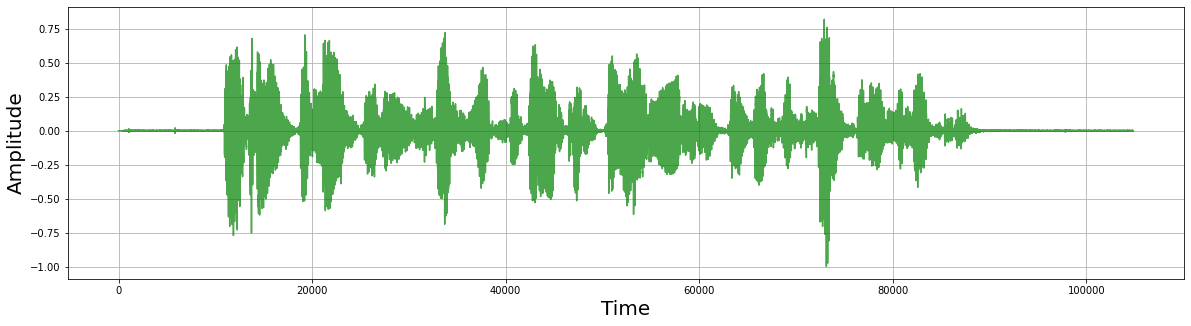

In [ ]:
visualize_audio(wav, SR)

In [ ]:
func = Featurizer()
mel_spectrogram = func(wav,True)

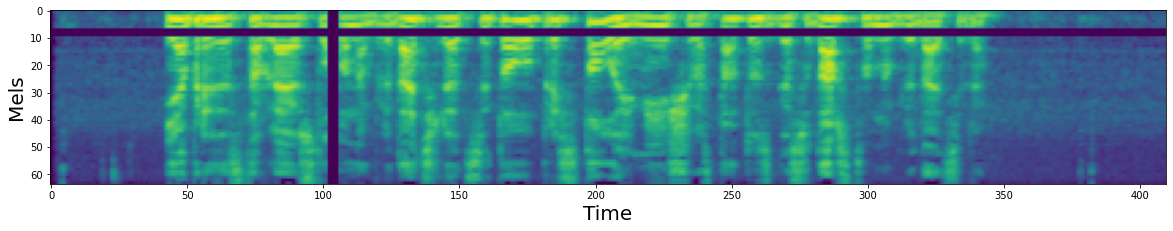

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
from math import ceil

class Collator:
    
    def __call__(self, batch):
        mel_featurizer = Featurizer()
        wavs, labels = zip(*batch)  

        lengths_for_wavs = torch.LongTensor([wav.size(-1) for wav in wavs])
        lengths_for_lables = torch.LongTensor([label.size(-1) for label in labels])
        num_elements_in_batch = len(lengths_for_wavs)
        
        specs = [mel_featurizer.forward(i) for i in wavs]
        lengths_for_specs = torch.LongTensor([i.shape[-1] for i in specs])

        spec_tensors = torch.zeros(num_elements_in_batch, specs[0].shape[1], max(lengths_for_specs))
        for i, spec in enumerate(specs):
            spec_tensors[i] = torch.cat([spec,
                                        torch.zeros(1, spec.shape[1],
                                        max(lengths_for_specs)- spec.shape[-1])],
                                        dim=2)


        batch_wavs = torch.zeros(len(batch), max(lengths_for_wavs),dtype=torch.float32)
        batch_label = torch.zeros(len(batch), max(lengths_for_lables), dtype=torch.long)

        for i, (wav, length) in enumerate(zip(wavs, lengths_for_wavs)):
            batch_wavs[i, :(wav.size(-1))] = wav.squeeze()

        for i, (string, length) in enumerate(zip(labels, lengths_for_lables)):
            batch_label[i, :length] = string


        lengths_for_specs = torch.tensor([ceil(x / 2) for x in lengths_for_specs])        
        
        return {
            'wavs': batch_wavs,
            'wavs lengths': lengths_for_wavs,
            'labels': batch_label,
            'labels lengths': lengths_for_lables,
            'specs': spec_tensors,
            "specs length": lengths_for_specs
        }

In [ ]:
from math import ceil

class Collator_transforms:
    
    def __call__(self, batch):
        mel_featurizer = Featurizer()
        wavs, labels = zip(*batch)  

        lengths_for_wavs = torch.LongTensor([wav.size(-1) for wav in wavs])
        lengths_for_lables = torch.LongTensor([label.size(-1) for label in labels])
        num_elements_in_batch = len(lengths_for_wavs)
        
        specs = [mel_featurizer.forward(i,True) for i in wavs]
        lengths_for_specs = torch.LongTensor([i.shape[-1] for i in specs])

        spec_tensors = torch.zeros(num_elements_in_batch, specs[0].shape[1], max(lengths_for_specs))
        for i, spec in enumerate(specs):
            spec_tensors[i] = torch.cat([spec,
                                        torch.zeros(1, spec.shape[1],
                                        max(lengths_for_specs)- spec.shape[-1])],
                                        dim=2)


        batch_wavs = torch.zeros(len(batch), max(lengths_for_wavs),dtype=torch.float32)
        batch_label = torch.zeros(len(batch), max(lengths_for_lables), dtype=torch.long)

        for i, (wav, length) in enumerate(zip(wavs, lengths_for_wavs)):
            batch_wavs[i, :(wav.size(-1))] = wav.squeeze()

        for i, (string, length) in enumerate(zip(labels, lengths_for_lables)):
            batch_label[i, :length] = string


        lengths_for_specs = torch.tensor([ceil(x / 2) for x in lengths_for_specs])        
        
        return {
            'wavs': batch_wavs,
            'wavs lengths': lengths_for_wavs,
            'labels': batch_label,
            'labels lengths': lengths_for_lables,
            'specs': spec_tensors,
            "specs length": lengths_for_specs
        }

Split dataset in train and test

In [ ]:
train_ratio = 0.9
rain_size = int(len(Golas) * train_ratio)
valtidation_size = len(Golas) -train_size 

indexes = torch.randperm(len(Golas))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset_Golas = Subset(AudioMnistDataset_Golas(Main_path_golas, path_to_csv_golas, transforms), train_indexes)
validation_dataset_Golas = Subset(Golas, validation_indexes)

NameError: ignored

In [ ]:
train_dataset_1 = ds_train1

# validation_dataset = ds_valid

In [ ]:
train_ratio = 0.9
train_size = int(len(ds_train2) * train_ratio)
valtidation_size = len(ds_train2) -train_size 
indexes = torch.randperm(len(ds_train2))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset_2 = Subset(AudioMnistDataset(Main_path, path_to_csv_valid, transforms), train_indexes)
validation_dataset = Subset(AudioMnistDataset(Main_path, path_to_csv_valid), validation_indexes)

In [ ]:
len(train_dataset_1), len(train_dataset_2), len(validation_dataset)

(17070, 89738, 9971)

In [ ]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])
len(train_dataset)

106808

In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=60,
    shuffle=True, collate_fn=Collator_transforms(),
    num_workers=2, pin_memory=True, drop_last=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=40, shuffle=True,
    collate_fn=Collator(),
    num_workers=2, pin_memory=False, drop_last=True
)

In [ ]:
a = next(iter(train_dataloader))

In [ ]:
a['wavs'][0]

tensor([ 0.0174, -0.0204,  0.0090,  ...,  0.0000,  0.0000,  0.0000])

### Новый fff

In [ ]:
def ctc_decode(inds):
    """
    Decode hypotheses
        1) Remove repetitive letters
        2) Remove blank characters
    """
    alph = Alphabet()
    text = alph.int2char(inds)
    processed_text = ""
    for i, value in enumerate(text):
        if (i > 0 and value != processed_text[-1]):
            processed_text += value
        if (i == 0 and value != ''):
            processed_text += value
    processed_text = processed_text.replace('^', '') # delete empty tokens from strings
    if processed_text == "":
        return ""
    if processed_text[0] == " " :
        processed_text = processed_text[1:]
    return processed_text

assert ctc_decode([11, 1, 13, 28, 8, 32, 11, 9, 33, 33]) == 'камызяки '

In [ ]:
print(alph.char2int("Камызяки  "))
alph.int2char([11, 1, 13, 28, 8, 32, 11, 9, 33, 33])

[11, 1, 13, 28, 8, 32, 11, 9, 33, 33]


'камызяки  '

In [ ]:
"" == 0

False

In [ ]:
import editdistance

def calc_wer(target_text: str, pred_text: str):
    targ_split = target_text.split()
    pred_split = pred_text.split()
    if len(targ_split) == 0 and len(pred_split) != 0:
        return 1.0
    if len(targ_split) == 0 and len(pred_split) == 0:
        return 0
    error = editdistance.eval(targ_split, pred_split)
    return error / len(targ_split)
    

def calc_cer(target_text: str, pred_text: str):
    if (len(target_text) == 0 and len(pred_text) != 0):
        return 1.0
    if len(target_text) == 0 and len(pred_text) == 0:
        return 0
    error = editdistance.eval(target_text, pred_text)
    return error / len(target_text)

In [ ]:
def calculate_cer(targets, decodings, y_lengths, x_lengths):
    """
    Calculate the Levenshtein distance between predictions and GT
    """
    numper_exmapes = 2
    alph = Alphabet()
    cer = 0.0
    wer = 0.0
    targets = targets.detach().tolist()

    decodings = decodings.detach().tolist()

    

    for i, target in enumerate(targets):
        targets[i] = target[:y_lengths[i]]

    for i, pred in enumerate(decodings):
        decodings[i] = pred[:x_lengths[i]]

    pairs = ""
    for target, d in zip(targets, decodings):
        target = alph.int2char(target) 
        decoding = ctc_decode(d)

        cer += calc_cer(target, decoding)
        wer += calc_wer(target, decoding)
    
    for tar, pred in zip(targets,decodings):
        print("\nTrue: ",alph.int2char(tar),"\n","Predic: ",ctc_decode(pred))
        numper_exmapes = numper_exmapes - 1 
        if (numper_exmapes == 0):
            break
    return cer / len(targets), wer / len(targets), pairs

In [ ]:
assert calc_cer('123','12345') == 0.6666666666666666
assert calc_wer('123 123 123','1 2 123 123 123') == 0.6666666666666666
assert calc_wer('quick brown    fox jumped over a lazy dog','quick brow  an fox jumped over   lazy dog') == 3/8

In [ ]:
import time
from tqdm import tqdm


class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

### Первая реализация Jasper

In [ ]:
# def conv_block(in_f, out_f, dropout, *args, **kwargs):
#     return nn.Sequential(
#             nn.Conv1d(in_channels=in_f, out_channels=out_f, *args, **kwargs,),
#             nn.BatchNorm1d(out_f),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#     )

# def block_end(dropout):
#     return nn.Sequential(
#             nn.ReLU(),
#             nn.Dropout(dropout),
#     )


# class Jasper(nn.Module):
#     def __init__(self, input_channels, vocab=34):
#         super().__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=input_channels, out_channels=256,  kernel_size=11, stride=2, padding=11 // 2),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )


#         self.block1 = nn.Sequential(
#             conv_block(256, 256, 0.2, kernel_size=11, padding=11 // 2),
#             conv_block(256, 256, 0.2, kernel_size=11, padding=11 // 2),
#             conv_block(256, 256, 0.2, kernel_size=11, padding=11 // 2),
#             conv_block(256, 256, 0.2, kernel_size=11, padding=11 // 2),
#             conv_block(256, 256, 0.2, kernel_size=11, padding=11 // 2)
#         )
#         self.one_to_one_conv_1 = nn.Sequential(
#             nn.Conv1d(256, 256, kernel_size=1),
#             nn.BatchNorm1d(256)
#         )
#         self.block1_continues = block_end(0.2)


#         self.block2 = nn.Sequential(
#             conv_block(256, 384, 0.2, kernel_size=13, padding=13 // 2 ),
#             conv_block(384, 384, 0.2, kernel_size=13, padding=13 // 2 ),
#             conv_block(384, 384, 0.2, kernel_size=13, padding=13 // 2 ),
#             conv_block(384, 384, 0.2, kernel_size=13, padding=13 // 2 ),
#             conv_block(384, 384, 0.2, kernel_size=13, padding=13 // 2 ),
#         )
#         self.one_to_one_conv_2 = nn.Sequential(
#             nn.Conv1d(256, 384, kernel_size=1),
#             nn.BatchNorm1d(384)
#         )
#         self.block2_continues = block_end(0.2)


#         self.block3 = nn.Sequential(
#             conv_block(384, 512, 0.2, kernel_size=17, padding=17 // 2 ),
#             conv_block(512, 512, 0.2, kernel_size=17, padding=17 // 2 ),
#             conv_block(512, 512, 0.2, kernel_size=17, padding=17 // 2 ),
#             conv_block(512, 512, 0.2, kernel_size=17, padding=17 // 2 ),
#             conv_block(512, 512, 0.2, kernel_size=17, padding=17 // 2 )
#         )
#         self.one_to_one_conv_3 = nn.Sequential(
#             nn.Conv1d(384, 512, kernel_size=1),
#             nn.BatchNorm1d(512)
#         )
#         self.block3_continues = block_end(0.2)


#         self.block4 = nn.Sequential(
#             conv_block(512, 640, 0.3, kernel_size=21, padding=21 // 2 ),
#             conv_block(640, 640, 0.3, kernel_size=21, padding=21 // 2 ),
#             conv_block(640, 640, 0.3, kernel_size=21, padding=21 // 2 ),
#             conv_block(640, 640, 0.3, kernel_size=21, padding=21 // 2 ),
#             conv_block(640, 640, 0.3, kernel_size=21, padding=21 // 2 )
#         )
#         self.one_to_one_conv_4 = nn.Sequential(
#             nn.Conv1d(512, 640, kernel_size=1),
#             nn.BatchNorm1d(640)
#         )
#         self.block4_continues = block_end(0.3)


#         self.block5 = nn.Sequential(
#             conv_block(640, 768, 0.3, kernel_size=25, padding=25 // 2 ),
#             conv_block(768, 768, 0.3, kernel_size=25, padding=25 // 2 ),
#             conv_block(768, 768, 0.3, kernel_size=25, padding=25 // 2 ),
#             conv_block(768, 768, 0.3, kernel_size=25, padding=25 // 2 ),
#             conv_block(768, 768, 0.3, kernel_size=25, padding=25 // 2 )
#         )
#         self.one_to_one_conv_5 = nn.Sequential(
#             nn.Conv1d(640, 768, kernel_size=1),
#             nn.BatchNorm1d(768)
#         )
#         self.block5_continues = block_end(0.3)

#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=768, out_channels=896,  kernel_size=29, dilation=2, padding=29 // 2 ),
#             nn.BatchNorm1d(896),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=896, out_channels=1024,  kernel_size=1),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=1024, out_channels=vocab,  kernel_size=1),
#             nn.BatchNorm1d(vocab), # 
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         # encoder
#         e0 = self.conv1(x)

#         block_1_left_way = self.block1(e0)
#         block_1_alter_right_way = self.one_to_one_conv_1(e0)
#         block_1 = self.block1_continues(block_1_left_way + block_1_alter_right_way)
#         residual_block_1 = block_1 


#         block_2_left_way = self.block2(residual_block_1)
#         block_2_alter_right_way = self.one_to_one_conv_2(residual_block_1)
#         block_2 = self.block2_continues(block_2_left_way + block_2_alter_right_way)
#         residual_block_2 = block_2 


#         block_3_left_way = self.block3(residual_block_2)
#         block_3_alter_right_way = self.one_to_one_conv_3(residual_block_2)
#         block_3 = self.block3_continues(block_3_left_way + block_3_alter_right_way)
#         residual_block_3 = block_3 


#         block_4_left_way = self.block4(residual_block_3)
#         block_4_alter_right_way = self.one_to_one_conv_4(residual_block_3)
#         block_4 = self.block4_continues(block_4_left_way + block_4_alter_right_way)
#         residual_block_4 = block_4

#         block_5_left_way = self.block5(residual_block_4)
#         block_5_alter_right_way = self.one_to_one_conv_5(residual_block_4)
#         block_5 = self.block5_continues(block_5_left_way + block_5_alter_right_way)
#         residual_block_5 = block_5 

#         e1 = self.conv2(residual_block_5)
#         e2 = self.conv3(e1)
#         e3 = self.conv4(e2)


#         return e3.log_softmax(dim=1)


In [ ]:
# net = Jasper(input_channels=256, vocab=34)

In [ ]:
# input = torch.randn(1, 256, 100)
# out = net(input)
# print(out.shape)
# summary(net,(256,400))

### Jasper

In [ ]:
from torchsummary import summary

In [ ]:
class Jasper_Block(nn.Module):
    def __init__(self, input_ch, output_ch, kernal_size, drop):
        super().__init__()
        self.blocks = nn.ModuleList([ nn.ModuleList([
            nn.Conv1d(in_channels = input_ch if i==0 else output_ch, out_channels=output_ch, kernel_size=kernal_size, padding=kernal_size//2 ),
            nn.BatchNorm1d(output_ch),
            nn.ReLU(),
            nn.Dropout(drop),
        ]) for i in range(5)
         ])
        
        self.residual_conv = nn.Sequential(  
            nn.Conv1d(input_ch, output_ch, kernel_size=1),
            nn.BatchNorm1d(output_ch),
        )
    def forward(self, x):
        x_befor_blocks = x
        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                    if  (i == len(self.blocks) - 1 and j == len(block) - 2):
                        x = self.residual_conv(x_befor_blocks) + x
                        x = layer(x)
                    else:
                        x = layer(x)
        return x 

In [ ]:
class Jasper(nn.Module):
    def __init__(self, input_channels, vocab=34):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=256,  kernel_size=11, stride=2, padding=11 // 2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.block1 = nn.Sequential(
            Jasper_Block(256,256,11,0.2),
            Jasper_Block(256,384,13,0.2),
            Jasper_Block(384,512,17,0.2),
            Jasper_Block(512,640,21,0.3),
            Jasper_Block(640,768,25,0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=768, out_channels=896,  kernel_size=29, dilation=2, padding=28 ),
            nn.BatchNorm1d(896),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=896, out_channels=1024,  kernel_size=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=vocab,  kernel_size=1),
            nn.BatchNorm1d(vocab), 
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e0 = self.conv1(x)

        BB = self.block1(e0) 

        e1 = self.conv2(BB)
        e2 = self.conv3(e1)
        e3 = self.conv4(e2)


        return e3.log_softmax(dim=1)


In [ ]:
net = Jasper(input_channels=64, vocab=34).to(torch.device('cuda'))
summary(net,(64,100),20)

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 1 Batch

In [ ]:
wandb.init(project='basic-intro', entity='mishaya')


wandb: Currently logged in as: mishaya (use `wandb login --relogin` to force relogin)


In [ ]:
config = wandb.config          # Initialize config
config.batch_size = 20          
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 3e-4               # learning rate (default: 0.01)
config.log_interval = 1     # how many batches to wait before logging training status

In [ ]:
NUM_EPOCH = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device(device)

model = Jasper(input_channels=64, vocab=34).to(device)
criterion = nn.CTCLoss(blank=32,) #balnk ^ == 32 index
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# computer = MelSpectrogram(sr=16000, n_mels=64)
mel_featurizer = Featurizer().to(device)

In [ ]:
from collections import defaultdict


In [ ]:
history = defaultdict(list)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-6)


In [ ]:
wandb.watch(model, log_freq=1)

[]

Epoch: 4


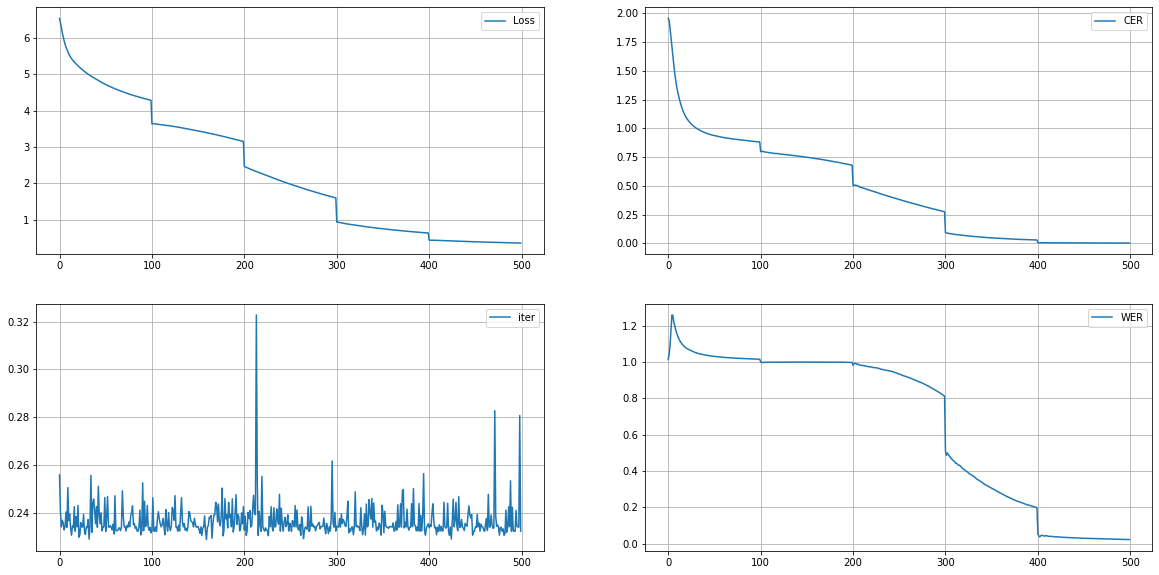

  1%|          | 1/100 [00:00<01:38,  1.01it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  2%|▏         | 2/100 [00:01<01:37,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  3%|▎         | 3/100 [00:03<01:37,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  4%|▍         | 4/100 [00:04<01:36,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  5%|▌         | 5/100 [00:05<01:35,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  6%|▌         | 6/100 [00:06<01:34,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  7%|▋         | 7/100 [00:07<01:33,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  8%|▊         | 8/100 [00:08<01:32,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

  9%|▉         | 9/100 [00:09<01:31,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 10%|█         | 10/100 [00:10<01:29,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 11%|█         | 11/100 [00:11<01:28,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 12%|█▏        | 12/100 [00:12<01:28,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 13%|█▎        | 13/100 [00:13<01:26,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 14%|█▍        | 14/100 [00:14<01:26,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 15%|█▌        | 15/100 [00:15<01:25,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 16%|█▌        | 16/100 [00:16<01:24,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 17%|█▋        | 17/100 [00:17<01:22,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 18%|█▊        | 18/100 [00:18<01:21,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 19%|█▉        | 19/100 [00:19<01:21,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 20%|██        | 20/100 [00:20<01:22,  1.03s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 21%|██        | 21/100 [00:21<01:21,  1.03s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 22%|██▏       | 22/100 [00:22<01:19,  1.02s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 23%|██▎       | 23/100 [00:23<01:18,  1.02s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 24%|██▍       | 24/100 [00:24<01:17,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 25%|██▌       | 25/100 [00:25<01:15,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 26%|██▌       | 26/100 [00:26<01:14,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секртарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вье

 27%|██▋       | 27/100 [00:27<01:13,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 28%|██▊       | 28/100 [00:28<01:12,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 29%|██▉       | 29/100 [00:29<01:11,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 30%|███       | 30/100 [00:30<01:10,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 31%|███       | 31/100 [00:31<01:09,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 32%|███▏      | 32/100 [00:32<01:08,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 33%|███▎      | 33/100 [00:33<01:07,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 34%|███▍      | 34/100 [00:34<01:06,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 35%|███▌      | 35/100 [00:35<01:05,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 36%|███▌      | 36/100 [00:36<01:04,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 37%|███▋      | 37/100 [00:37<01:03,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 38%|███▊      | 38/100 [00:38<01:02,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 39%|███▉      | 39/100 [00:39<01:01,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предосталяю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вье

 40%|████      | 40/100 [00:40<01:00,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 41%|████      | 41/100 [00:41<00:59,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 42%|████▏     | 42/100 [00:42<00:58,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 43%|████▎     | 43/100 [00:43<00:57,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 44%|████▍     | 44/100 [00:44<00:56,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 45%|████▌     | 45/100 [00:45<00:55,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 46%|████▌     | 46/100 [00:46<00:55,  1.02s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 47%|████▋     | 47/100 [00:47<00:53,  1.02s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 48%|████▊     | 48/100 [00:48<00:52,  1.02s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 49%|████▉     | 49/100 [00:49<00:51,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 50%|█████     | 50/100 [00:50<00:50,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 51%|█████     | 51/100 [00:51<00:48,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 52%|█████▏    | 52/100 [00:52<00:47,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 53%|█████▎    | 53/100 [00:53<00:46,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 54%|█████▍    | 54/100 [00:54<00:46,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 55%|█████▌    | 55/100 [00:55<00:45,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 56%|█████▌    | 56/100 [00:56<00:44,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 57%|█████▋    | 57/100 [00:57<00:43,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 58%|█████▊    | 58/100 [00:58<00:42,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 59%|█████▉    | 59/100 [00:59<00:41,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 60%|██████    | 60/100 [01:00<00:40,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 61%|██████    | 61/100 [01:01<00:38,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 62%|██████▏   | 62/100 [01:02<00:38,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 63%|██████▎   | 63/100 [01:03<00:37,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 64%|██████▍   | 64/100 [01:04<00:35,  1.00it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 65%|██████▌   | 65/100 [01:05<00:34,  1.01it/s]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 66%|██████▌   | 66/100 [01:06<00:34,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 67%|██████▋   | 67/100 [01:07<00:33,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 68%|██████▊   | 68/100 [01:08<00:32,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 69%|██████▉   | 69/100 [01:09<00:31,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 70%|███████   | 70/100 [01:10<00:30,  1.01s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 71%|███████   | 71/100 [01:11<00:29,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 72%|███████▏  | 72/100 [01:12<00:28,  1.00s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 73%|███████▎  | 73/100 [01:13<00:27,  1.03s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 74%|███████▍  | 74/100 [01:14<00:26,  1.03s/it]

теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну ----- теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги му
в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода ----- в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода
за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении ----- за прошедший год значительно продвинулось судебное разбирательство по ситуации в кении
я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя ----- я предоставляю слово наблюдателю от святого престола имеющего статус государстванаблюдателя
швейцария стала одним из ее авторов ----- швейцария стала одним из ее авторов
что же последует за ними ----- что же последует за ними
вьетнам был жертвой террористического нападения на одно из его дипломатических представительств ----- вь

 74%|███████▍  | 74/100 [01:15<00:26,  1.02s/it]


KeyboardInterrupt: ignored

In [ ]:
one_batch = next(iter(train_dataloader))
for epoch in range(20):
    average_cer = AverageMeter()
    average_wer = AverageMeter()
    average_loss = AverageMeter()
    with Timer('epoch') as epoch_t:
        for batch in tqdm(range(100)):
            with Timer('iteration') as iteration_t:
                x = one_batch['specs'].to(device)
                y = one_batch['labels'].to(device)
                x_lengths =  one_batch['specs length'].to(device)
                y_lengths =  one_batch['labels lengths'].to(device)
                # x, x_len = mel_featurizer(x, x_lengths)
                
                log_probs = model(x) # N C T
                log_probs = log_probs.permute(2, 0, 1,) # T N C

                loss = criterion(log_probs, y, x_lengths, y_lengths) 

            history['time_per_iter'].append(iteration_t.t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            argmax_decoding = log_probs.detach().cpu() \
                    .argmax(dim=-1).transpose(0, 1)

            cer, wer, pairs  = calculate_cer(y, argmax_decoding,y_lengths, x_lengths)
            print(pairs)
            average_cer.update(cer)
            average_wer.update(wer)
            average_loss.update(loss.item())
            history['loss'].append(average_loss.avg)
            history['cer'].append(average_cer.avg)
            history['wer'].append(average_wer.avg)
            print('cer=', cer)
            print('wer', wer)
            wandb.log({
            "loss": loss.item(),
            "cer": cer,
            "wer": wer})
        history['time_per_epoch'].append(epoch_t.t)

    display.clear_output()
    print(f'Epoch: {epoch}')

    
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten()
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    
    axes[2].plot(history['time_per_iter'], label='iter')
    axes[2].legend(); axes[2].grid()
    axes[3].plot(history['wer'], label='WER')
    axes[3].legend(); axes[3].grid()
    
    plt.show()

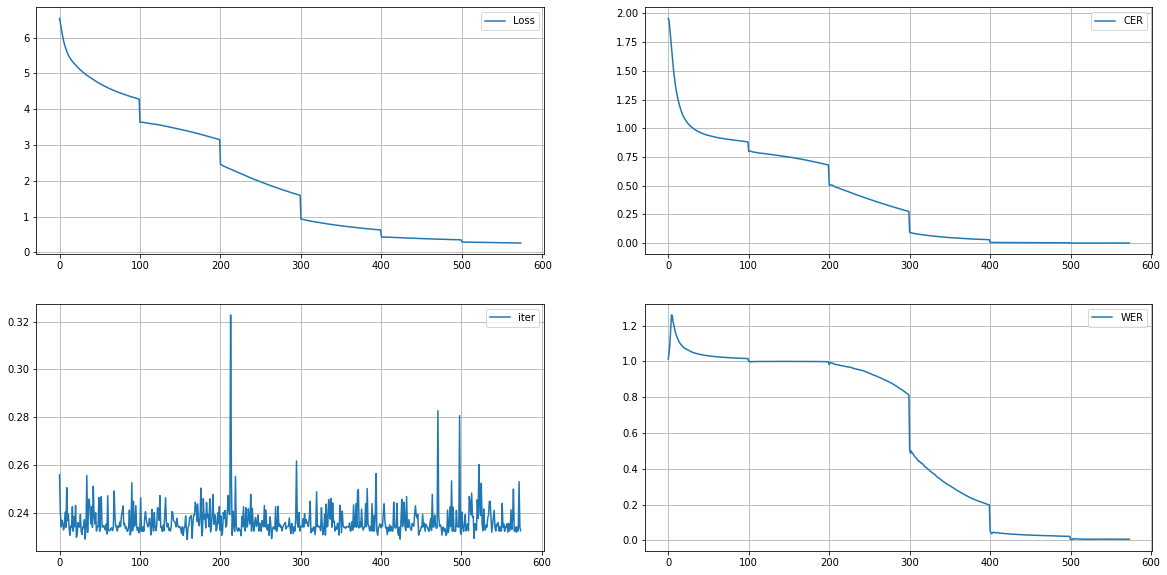

In [ ]:
    
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
axes[0].plot(history['loss'], label='Loss')
axes[1].plot(history['cer'], label='CER')
axes[0].legend(); axes[0].grid()
axes[1].legend(); axes[1].grid()

axes[2].plot(history['time_per_iter'], label='iter')
axes[2].legend(); axes[2].grid()
axes[3].plot(history['wer'], label='WER')
axes[3].legend(); axes[3].grid()

plt.show()  

### Jasper На всем датасете

In [ ]:
wandb.init(project='basic-intro', entity='mishaya')

In [ ]:
config = wandb.config          # Initialize config
config.batch_size = 20          
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 3e-4               # learning rate (default: 0.01)
config.log_interval = 1     # how many batches to wait before logging training status

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda')

model = Jasper(input_channels=64, vocab=34).to(DEVICE)
criterion = nn.CTCLoss(blank=32,) #balnk ^ == 32 index
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-6)
# computer = MelSpectrogram(sr=16000, n_mels=64)
mel_featurizer = Featurizer().to(DEVICE)

In [ ]:
from collections import defaultdict


In [ ]:
history = defaultdict(list)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)


Epoch: 2


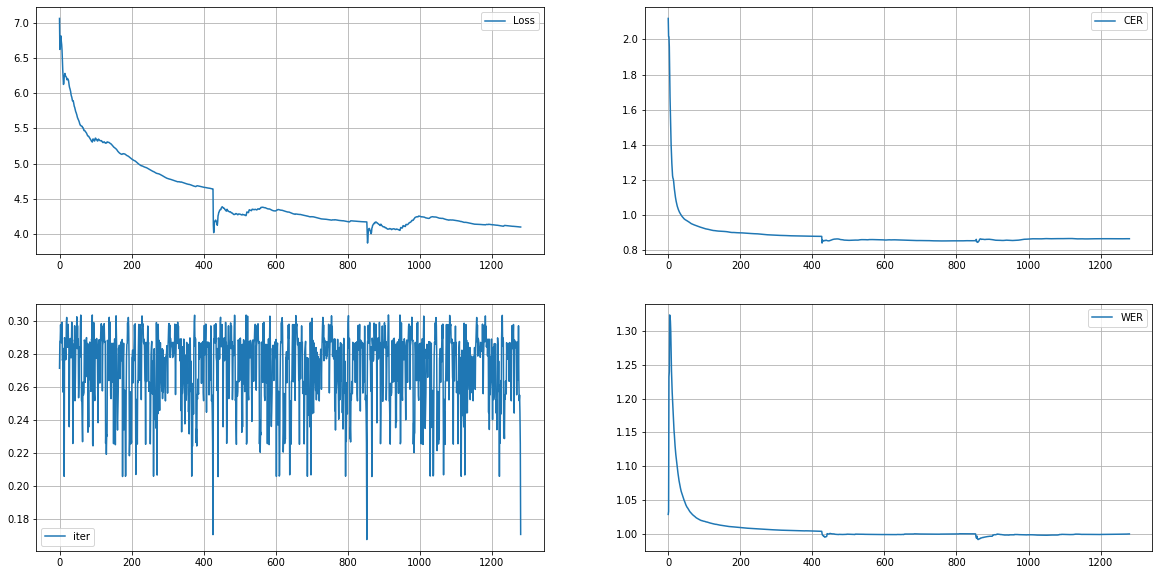

  0%|          | 1/427 [00:04<30:38,  4.32s/it]

True:  теперь слово предоставляется генеральному секретарю его превосходительству господину пан ги муну 
 Predic:  а а а а оаоаиаиаиаиаиаиаиаианини иа ааааи
True:  в португальском языке такие слова как жизнь душа и надежда  это существительные женского рода 
 Predic:  маи аиаиа оиаиаиаиаи иниаи и и
cer= 0.8578296820415494
wer 0.9940184815184814


  0%|          | 2/427 [00:07<26:16,  3.71s/it]

True:  итак вы желаете ответить на вопросы заданные представителем российской федерации 
 Predic:  а а ое 
True:  аналогичным образом внутренняя экономическая политика кубы создает серьезные препятствия на пути собственного экономического развития 
 Predic:  ом а а а и оа а а аиа а риа тн и ии
cer= 0.8509099032422822
wer 1.0149975024975024


  1%|          | 3/427 [00:11<25:32,  3.61s/it]

True:  сейчас мы приступаем к выборам остающихся членов бюро 
 Predic:   а а оиои
True:  в этом контексте мы будем стремиться с максимальной эффективностью задействовать потенциал комиссии 
 Predic:  в ао а оаиаиа т а аи араиниаиаи и и и и оа аи
cer= 0.8293762669402304
wer 1.0310338966588968


  1%|          | 4/427 [00:14<25:19,  3.59s/it]

True:  наша группа состояла из четырех добровольцев 
 Predic:   иа аиа а 
True:  ядерная проблематика была в центре внимания делегаций в ходе прений первого комитета 
 Predic:    и и и аиа а а оиаиаиаиаиаиниа а 
cer= 0.8385944873824209
wer 0.9872342934842931


  1%|          | 5/427 [00:17<24:17,  3.45s/it]

True:  роль заинтересованных сторон на региональном уровне в содействии стабилизации в афганистане трудно переоценить 
 Predic:   а а а аи и о оаиаиа атаит тиаиаси рн н иаиа иаиаи аи ооааи
True:  у республики сербии и сербского народа давние отношения со всеми народами этого региона 
 Predic:  а а а а оаеаеаениаисаи 
cer= 0.8380567563938326
wer 1.003076923076923


  1%|▏         | 6/427 [00:20<22:40,  3.23s/it]

True:  рост ограничен способностью экосистем планеты к восстановлению 
 Predic:  мт ое 
True:  осенью и воробей богат 
 Predic:  тат 
cer= 0.8586989196818576
wer 0.9961309523809522


  2%|▏         | 7/427 [00:23<22:28,  3.21s/it]

True:  соответственно мы надеемся что этот проект будет принят консенсусом 
 Predic:  е а аоаи 
True:  она взяла его руку и спросила спал ли он 
 Predic:  т  а
cer= 0.8374970413787308
wer 1.0001602564102563


  2%|▏         | 8/427 [00:27<23:00,  3.29s/it]

True:  в проект резолюции не включен ни один из текстов согласованных на международном уровне 
 Predic:  а  а е аиа оаеаиаиаиаитиаиаисаниаиаиа иа
True:  однако честно говоря мы не испытываем большого оптимизма если говорить о перспективах 
 Predic:  а а а оаиаиаиаиаеи а арианас е
cer= 0.8302417862972937
wer 1.000436507936508


  2%|▏         | 9/427 [00:31<25:54,  3.72s/it]

True:  в данном контексте особое значение приобретает соблюдение действующих правил государствами флага 
 Predic:  м а а оасаиат асиататанасасас аса
True:  пятый комитет принял данный проект резолюции без голосования 
 Predic:  ват а а и
cer= 0.8394779368806147
wer 1.0038392857142857


  2%|▏         | 10/427 [00:36<27:28,  3.95s/it]

True:  у нас общие цели 
 Predic:  
True:  и мы хотели бы высказать коекакие уточнения к заявлению сделанному ранее нашей делегацией 
 Predic:  ма а е а ат т оаиеаиаененеаеатиаиаиа ео и
cer= 0.85001541154432
wer 0.9977272727272727


  3%|▎         | 11/427 [00:40<26:51,  3.87s/it]

True:  осуществление декларации об объявлении индийского океана зоной мира 
 Predic:  т а а а ои
True:  в заявлении сделанным ближневосточной четверкой в пятницу были определены важные вехи на этом пути 
 Predic:  моае еие оас аиатсаеи татасниаиоиоаиаиоиоиаои
cer= 0.8631333100937126
wer 0.9919351481851482


  3%|▎         | 12/427 [00:43<24:52,  3.60s/it]

True:  большинство народов недовольно нынешней ситуацией в мире 
 Predic:  п о а 
True:  мы не будем убивать пока не придут убивать нас 
 Predic:  
cer= 0.8625811129411372
wer 1.0004413641913643


  3%|▎         | 13/427 [00:47<25:35,  3.71s/it]

True:  исходя из этого мы должны формировать необходимый консенсус в рамках конференции по разоружению 
 Predic:  оое етеатити оатес ти та атетеаитснаиеиаиаиоиои
True:  это также не будет способствовать нашей работе 
 Predic:  мое и
cer= 0.8278782126923276
wer 0.9982142857142857


  3%|▎         | 14/427 [00:50<25:28,  3.70s/it]

True:  бутылка шампанского будет 
 Predic:  о и
True:  да что брат я сам начинаю думать что она точно спета 
 Predic:  мо оа о отат оеоеоесос еосиаиа
cer= 0.8520023606023985
wer 0.9958333333333332


  4%|▎         | 15/427 [00:54<24:55,  3.63s/it]

True:  да сколько твоему отцу лет 
 Predic:  ти а аиаиаиаи
True:  да ты о ком говоришь 
 Predic:  и
cer= 0.822682115627271
wer 0.9971434815184816


  4%|▎         | 16/427 [00:57<24:57,  3.64s/it]

True:  наша молодежь поистине является величайшим достоянием ямайки 
 Predic:  мста та о тасетененстасаситстсисисисисиси
True:  а теперь слово имеет уважаемый посол алжира 
 Predic:  мпт т ат а оии
cer= 0.8392668127901615
wer 1.0


  4%|▍         | 17/427 [01:01<24:05,  3.53s/it]

True:  липутин удивился но пролез в свою очередь затем доску вставили попрежнему 
 Predic:  ета а а а иа
True:  не будь их поддержки сегодня мне не о чем было бы вам докладывать 
 Predic:  а а оии
cer= 0.8389995017010479
wer 0.9946022727272726


  4%|▍         | 18/427 [01:05<24:55,  3.66s/it]

True:  оба мы замолчали погрузясь каждый в свои размышления 
 Predic:  ттотата а 
True:   мне кажется  сказала она  я думаю что нравлюсь 
 Predic:  мотаота а а  
cer= 0.8581631251998925
wer 0.9974999999999999


  4%|▍         | 19/427 [01:09<25:26,  3.74s/it]

True:  весть о свободе моей обрадовала его несказанно 
 Predic:  тоеатета о аоаи и
True:  я с жаром ее поцеловал и поспешно вышел из комнаты 
 Predic:  та оеиеиоиоии
cer= 0.8506306537571504
wer 0.9897619047619047


  5%|▍         | 20/427 [01:12<25:06,  3.70s/it]

True:  следует признать что в последнее время регулированию торговли обычными вооружениями уделяется определенное внимание 
 Predic:  мт а а а а оетсетет аетет теистстнитиаиатстс а
True:  разумеется разоруженческий процесс в целом сталкивается с крупными проблемами 
 Predic:  а оеии
cer= 0.8492287292411754
wer 1.00625


  5%|▍         | 21/427 [01:16<24:33,  3.63s/it]

True:  пользуясь возможностью мы приветствуем недавнюю ратификацию гватемалой договора о всеобъемлющем запрещении ядерных испытаний 
 Predic:  а а ое енини
True:  в данном случае я имею в виду ту увязку ту аргументацию которую вы высказываете 
 Predic:  а а оа е тиаие ите е тинени
cer= 0.8592012499409225
wer 0.9972222222222221


  5%|▌         | 22/427 [01:19<23:52,  3.54s/it]

True:  я считаю они проделали очень хорошую работу 
 Predic:  ама ат и
True:  беспочвенные обвинения которые содержатся в представленном сегодня совету докладе полностью противоречат положению в дарфуре 
 Predic:  тоа а а оетататат аистеататниниииаи
cer= 0.8602089015035397
wer 0.992449494949495


  5%|▌         | 23/427 [01:22<22:57,  3.41s/it]

True:  с другой стороны это совершенно прекрасное время 
 Predic:  оаоаоа ии
True:  нельзя переоценить необходимость учета гендерной проблематики в инициативах по поддержанию мира и миростроительству 
 Predic:  отоата а а оеаеатаеаетететаоенаниаиаиаиаиа
cer= 0.8451129170250086
wer 1.00625


  6%|▌         | 24/427 [01:25<22:53,  3.41s/it]

True:  я хочу быть частью вас 
 Predic:  ама о а 
True:  наша делегация также положительно оценивает недавние поправки к конституции и назначение председателя верховного суда 
 Predic:  мтоа а а оатстат аист тат отнииаиаиаиаиа
cer= 0.872997677911667
wer 1.0


  6%|▌         | 25/427 [01:29<23:10,  3.46s/it]

True:  соединенное королевство приветствует сегодняшние прения с целью обсуждения нынешней ситуации в гаити 
 Predic:  мтотоа а а оститет ититниниои
True:  у международного сообщества наконец появился беспрецедентный шанс восстановить безопасность мир и стабильность в сомали 
 Predic:  мто т а а ота таитст тетнитиитиа
cer= 0.8515697627154983
wer 1.0004166666666667


  6%|▌         | 26/427 [01:33<23:15,  3.48s/it]

True:  но ответа не было и на этот раз 
 Predic:  а а 
True:  по этой причине япония воздержалась при голосовании по обсуждаемому проекту резолюции 
 Predic:  мстет е еа и и
cer= 0.8463631483769192
wer 0.9979166666666668


  6%|▋         | 27/427 [01:36<22:43,  3.41s/it]

True:  сосед расписался сунул телеграмму в карман сел на скамью и закурил трубку 
 Predic:  стоаеа иаиа 
True:  мы считаем что конференция по разоружению остается наилучшей площадкой для переговоров по такому инструменту 
 Predic:  маоаоаеа оеоененеоеоаеоаеоеиеаеиа
cer= 0.8657260825824664
wer 1.0102272727272728


  7%|▋         | 28/427 [01:40<23:47,  3.58s/it]

True:  в числе других  оборот наркотиков и незаконная эксплуатация природных ресурсов 
 Predic:  та оеиаианснои
True:  наступило молчание по крайней мере на полминуты 
 Predic:  а а
cer= 0.8848067446910821
wer 1.0


  7%|▋         | 29/427 [01:44<25:30,  3.84s/it]

True:  я вижу что слово желает взять представитель нидерландов 
 Predic:  моа ии
True:  может быть к тому же вы еще и летчик 
 Predic:  а 
cer= 0.8879437765279541
wer 0.9949999999999999


  7%|▋         | 30/427 [01:47<23:54,  3.61s/it]

True:  эту информацию можно найти на вебсайте центра 
 Predic:  о а а ит
True:  у нас есть шанс 
 Predic:  
cer= 0.8579349970645129
wer 1.001291208791209


  7%|▋         | 31/427 [01:50<22:18,  3.38s/it]

True:  мы переживаем особенный момент 
 Predic:  оо о 
True:  алексей александрович вздрогнул и загнул руки чтобы трещать ими 
 Predic:  ое оа а ое
cer= 0.8605118526855045
wer 0.9959935897435898


  7%|▋         | 32/427 [01:55<24:22,  3.70s/it]

True:  являясь ее председателем мы занимаем место в совете управляющих глобальным фондом 
 Predic:  оаеа о отеаететесеататентнеоеоеиеи
True:  швабрин побледнел как мертвый 
 Predic:  омо е 
cer= 0.8597938247611914
wer 1.0


  8%|▊         | 33/427 [01:59<25:53,  3.94s/it]

True:  мы приветствуем самого молодого члена организации объединенных наций  республику южный судан 
 Predic:  ама оененно
True:  как известно уважаемым делегатам именно здесь проходили последние заседания совета лиги наций 
 Predic:  а а и оии
cer= 0.8740841360143037
wer 0.9932142857142857


  8%|▊         | 34/427 [02:02<23:30,  3.59s/it]

True:  мы вернемся к вопросу о выборах заместителей председателя от этой группы позднее 
 Predic:  аеаое
True:  и мне очень хотелось бы поддержать выступление посла данона и поблагодарить его 
 Predic:  атоененеие
cer= 0.874357801649513
wer 0.9949999999999999


  8%|▊         | 35/427 [02:05<22:19,  3.42s/it]

True:  слово предоставляется представителю корейской народнодемократической республики 
 Predic:  е е а аое е еи
True:  индия придает большое значение деятельности агентства в области ядерной науки 
 Predic:   е еаоиеиеиеи
cer= 0.8774306256019122
wer 0.9955769230769231


  8%|▊         | 36/427 [02:08<22:10,  3.40s/it]

True:  касательно договора о запрещении производства расщепляющихся материалов договоренности такого уровня нет 
 Predic:  е е ае ао ое е етиетеиенеиеоеоеоееи
True:  понятно что миротворцы не могут оставаться в гаити вечно 
 Predic:  ом о а а и
cer= 0.8495092725410082
wer 1.014423076923077


  9%|▊         | 37/427 [02:11<21:47,  3.35s/it]

True:  и я призвал к укреплению связи между ядерной безопасностью и ядерной защитой 
 Predic:  о о аои иеиении
True:  углубленное обсуждение технических проблем может помочь заложить фундамент под будущие переговоры 
 Predic:  а оиоити и и еиаитоинеиеиеиеи
cer= 0.8742368236488268
wer 0.9886523199023198


  9%|▉         | 38/427 [02:15<22:25,  3.46s/it]

True:  она не терпит приблизительности 
 Predic:  оео и
True:  мы были на молитве 
 Predic:  
cer= 0.8759079132005951
wer 1.0


  9%|▉         | 39/427 [02:19<23:20,  3.61s/it]

True:  у тебя на шее пионерский галстук но ты просто негодяй 
 Predic:  о е оаиаи и и
True:  дым отечества нам сладок и приятен 
 Predic:  оно и
cer= 0.8808573847295961
wer 0.993560606060606


  9%|▉         | 40/427 [02:22<22:18,  3.46s/it]

True:  что мотивировало нас стать добровольцами и работать в районах с повышенной степенью риска 
 Predic:  о еаеае оеоеоеоеиоеоеоои
True:  как известно членам совета только на прошлой неделе происходил диалог 
 Predic:  оеоеоеаеа 
cer= 0.8537054394065837
wer 0.9954166666666666


 10%|▉         | 41/427 [02:26<22:52,  3.55s/it]

True:  вот этот кабинет и все это  практически мой дом 
 Predic:  оеаеае о
True:  терроризм  это враг всех цивилизованных народов 
 Predic:  оеоеаеаеае 
cer= 0.8798855931112408
wer 0.995436507936508


 10%|▉         | 42/427 [02:30<23:37,  3.68s/it]

True:  он понял что она была несчастлива и любила его 
 Predic:  оеа 
True:  швабрин остановился на лестнице 
 Predic:  
cer= 0.8704341735896353
wer 1.0


 10%|█         | 43/427 [02:33<22:44,  3.55s/it]

True:  я подхожу к завершению своего выступления и поэтому хотел бы обобщить некоторые мысли 
 Predic:  ооеоеоеаеа е иоиаеае а
True:  мы твердо убеждены что самой крупной угрозой безопасности всех стран является существование ядерного оружия 
 Predic:  оеоеоеоеаеаеоеоеиоаоеоеоиеиоеоиоаиноеноеоеоае
cer= 0.8411026625192759
wer 0.9972222222222221


 10%|█         | 44/427 [02:37<23:33,  3.69s/it]

True:  мне кажется втайне софия уже и сама так думала 
 Predic:  ооеоеоае ои
True:  наконец мы поддерживаем идею проекта резолюции который группа арабских государств представит генеральной ассамблее 
 Predic:  оноеоеоеаеаеаеаеаеоиаиасаитионанаеоноеинаоиоиоиатаи
cer= 0.8528067090833545
wer 0.9907828282828284


 11%|█         | 45/427 [02:42<24:41,  3.88s/it]

True:  выключить свет в гостиной 
 Predic:  ооо и
True:  и точно 
 Predic:  
cer= 0.861861498805256
wer 0.9915674603174602


 11%|█         | 46/427 [02:45<23:02,  3.63s/it]

True:  вопервых мы вновь подтверждаем всемирную программу действий касающуюся молодежи 
 Predic:  еоаоеоеоеоеоеоеоиоиеа
True:  он был в исступлении в отчаянии в поту 
 Predic:  моеое еи
cer= 0.8512298083313775
wer 1.0


 11%|█         | 47/427 [02:48<22:24,  3.54s/it]

True:  комитет приступает к принятию решения по шестому пункту преамбулы 
 Predic:  мноеоеоеоеотоеионеноноеотит
True:  несмотря на нынешнюю мрачную ситуацию перспективы все же просматриваются 
 Predic:  мноеое оааооо т
cer= 0.8554477082898048
wer 0.9979166666666666


 11%|█         | 48/427 [02:51<22:17,  3.53s/it]

True:  мы хотим двигаться вперед вместе со всем миром разделяя принципы уважения и толерантности 
 Predic:  моеое е еоиеиеиеиеи
True:  другое предложение  сделать его по словам представителя египта более точным 
 Predic:  моеоеоеоеоеаороеоиеоеоеононоеоенои
cer= 0.8393763381244723
wer 1.0


 11%|█▏        | 49/427 [02:55<22:05,  3.51s/it]

True:  это рабочий документ группы и не тот что я огласил 
 Predic:  моеоитаоа и
True:  повелительно важно чтобы конференция выполняла свой мандат ведение переговоров 
 Predic:  мвоеоа р и о
cer= 0.8582754549146211
wer 0.9885606060606061


 12%|█▏        | 50/427 [02:58<21:18,  3.39s/it]

True:  франция полностью разделяет заявление которое было только что сделано от имени европейского союза 
 Predic:  еоеоаоеоеоеи
True:  китай всегда поддерживал палестинский народ в его справедливом стремлении восстановить свои законные национальные права 
 Predic:  мооеоеоеоеоаоаононененоеоеоеоеи
cer= 0.8581093601690531
wer 1.0


 12%|█▏        | 51/427 [03:01<21:13,  3.39s/it]

True:  это отвечает общим интересам сирии арабских стран и международного сообщества в целом 
 Predic:  нмото оенонооиои
True:  мы также благодарим ее предшественника на этом посту посла пхуангкеткеоу таиланд за прекрасную работу 
 Predic:  отоеоаоноененен ои
cer= 0.8621424335553716
wer 0.9979166666666666


 12%|█▏        | 52/427 [03:05<21:03,  3.37s/it]

True:  мы рады видеть его в этом зале 
 Predic:  моо 
True:  говорили что эту задолженность невозможно будет погасить 
 Predic:  моеоеототата и
cer= 0.8521733347093525
wer 0.9961309523809524


 12%|█▏        | 53/427 [03:08<20:56,  3.36s/it]

True:  они также разорвали отношения с сирией без какихлибо оснований 
 Predic:  оооотоеоа 
True:  мы должны признать важную работу проведенную в рамках осуществления всемирной программы действий касающейся молодежи 
 Predic:  оо еоаотоереоеоеоеононоеоиоиоионоити
cer= 0.8625018518072813
wer 0.9907967032967033


 13%|█▎        | 54/427 [03:12<22:07,  3.56s/it]

True:  я хотел бы заверить вас в поддержке моей делегацией вашего председательства 
 Predic:  ноаоаоа о оеоеонои
True:  хотел соврать да не вышло 
 Predic:  ноте 
cer= 0.8766188860430255
wer 1.0


 13%|█▎        | 55/427 [03:16<23:17,  3.76s/it]

True:  ты объясни мне проще 
 Predic:  
True:  они растворились в уличной толпе 
 Predic:  поиоио 
cer= 0.859998859504732
wer 1.0


 13%|█▎        | 56/427 [03:19<21:52,  3.54s/it]

True:  все больше групп берется за оружие 
 Predic:  но 
True:  третье ключом к решению проблем всегда является профилактика 
 Predic:  оооаоа оои
cer= 0.8916758643749763
wer 0.993076923076923


 13%|█▎        | 57/427 [03:22<20:59,  3.40s/it]

True:  исправление такой ситуации требует мобилизации всеми заинтересованными субъектами большего количества ресурсов 
 Predic:  ноаотаоеионионинононононоини
True:  иностранное вмешательство акты насилия и подстрекательство к терроризму подольют еще больше масла в огонь 
 Predic:  т о та аноии
cer= 0.8596505189965203
wer 0.9936507936507937


 14%|█▎        | 58/427 [03:27<23:21,  3.80s/it]

True:  у нас всех имеются к организации объединенных наций претензии 
 Predic:  тотота 
True:  япония преисполнена решимости играть ведущую роль в таких усилиях совместно с другими странами 
 Predic:  нототото то о от оеоетоететсесеороетнеоенононти
cer= 0.8378945276208501
wer 0.9974999999999999


 14%|█▍        | 59/427 [03:31<22:50,  3.72s/it]

True:  мы особо отмечаем важную роль комиссии по миростроительству 
 Predic:  отото тототот т о оиеиеиеиеиеиеит
True:  мы поддерживаем усилия прилагаемые судом в целях обеспечения его нормального функционирования 
 Predic:  нотот отото орое етенонононони
cer= 0.8473419725290489
wer 0.9964285714285716


 14%|█▍        | 60/427 [03:34<22:45,  3.72s/it]

True:  слово имеет представитель принимающей страны 
 Predic:  нмо о т и ии
True:  предотвращение гонки вооружений в космическом пространстве 
 Predic:  нотот т от тоатаоаоеити сот от
cer= 0.8293151268012572
wer 1.000576923076923


 14%|█▍        | 61/427 [03:38<22:13,  3.64s/it]

True:  мы твердо убеждены что самой большой угрозой безопасности всех стран является существование ядерного оружия 
 Predic:  мо ототатоата аоеноиоеоооти
True:  это включает в себя преодоление побочных эффектов и невосприимчивость к некоторым антиретровирусным препаратам 
 Predic:  о о от оененениоиоиоототиа
cer= 0.8191834442228542
wer 1.007936507936508


 15%|█▍        | 62/427 [03:42<22:06,  3.63s/it]

True:  обращаюсь к своему рассказу 
 Predic:  мнтот 
True:  жизнь людей гораздо важнее для нас чем макроэкономические показатели и так будет и впредь 
 Predic:  от о т аоенеононотоноамстстрят
cer= 0.8502375328151421
wer 0.9974999999999999


 15%|█▍        | 63/427 [03:45<22:17,  3.68s/it]

True:  сейчас мы осмысливаем достигнутый обнадеживающий прогресс и преисполнены решимости реализовать предстоящие задачи 
 Predic:  оотоеоа аоеанонононтснта
True:  деньги были доставлены зурину 
 Predic:  онтот 
cer= 0.8634704662686257
wer 1.0


 15%|█▍        | 64/427 [03:49<22:23,  3.70s/it]

True:  вопервых мы ничего не проповедуем 
 Predic:  наоа 
True:  вдруг закричали в толпе что государь на площади ожидает пленных и принимает присягу 
 Predic:  аеоатотенанананоаоаоанона
cer= 0.869615944310335
wer 1.0


 15%|█▌        | 65/427 [03:53<22:50,  3.79s/it]

True:  поступила просьба о проведении заносимого в отчет о заседании голосования 
 Predic:  смоаоа а а та аоете атототоснотта
True:  по пути мы обогнали армейский конвой из пятнадцати машин 
 Predic:  нмаоао а ии
cer= 0.8453207952257774
wer 0.9940972222222222


 15%|█▌        | 66/427 [03:57<23:31,  3.91s/it]

True:  любой метод мирного урегулирования споров также эффективен в разрешении конфликтов 
 Predic:  оноенененоноиноиосоот
True:  наконец позвольте заметить что арабская весна  это работа на целое поколение 
 Predic:  моаоа отатататоа оеноитоитостста
cer= 0.854811595103705
wer 0.9927083333333332


 16%|█▌        | 67/427 [04:02<24:19,  4.05s/it]

True:  может но не сразу 
 Predic:  а 
True:  наша делегация признательна за предоставленную возможность участвовать в этих прениях 
 Predic:  ма а а а а а а оенсонто с
cer= 0.8518870168082356
wer 0.9982142857142857


 16%|█▌        | 68/427 [04:06<24:29,  4.09s/it]

True:  это  совместная ответственность которую необходимо осуществлять более решительно 
 Predic:  вма а о та и
True:  мы должны разработать стратегию коллективных усилий по эффективной борьбе с последствиями хронических заболеваний 
 Predic:  амо а а т а отате аетатеаеаернонотоноанороноеосоета
cer= 0.8587938392527381
wer 0.9964285714285716


 16%|█▌        | 69/427 [04:10<24:46,  4.15s/it]

True:  это не просто красивые слова о теоретически возможном лучшем будущем 
 Predic:  ма а а а ата а и
True:  мы выступим по другим вопросам в своем национальном качестве 
 Predic:  но 
cer= 0.8500233289891514
wer 0.9977272727272727


 16%|█▋        | 70/427 [04:14<23:38,  3.97s/it]

True:  новая ливия должна быть страной для всех где каждый может найти свое место 
 Predic:  о о о т т оеи т  тя
True:  слово имеет представитель румынии который выступит от имени восточноевропейских государств 
 Predic:  ото от т о оеит
cer= 0.8135258925507631
wer 1.0003860028860028


 17%|█▋        | 71/427 [04:17<23:06,  3.90s/it]

True:  не все такие везучие 
 Predic:  со 
True:  это имеет ключевое значение для успешных преобразований и нового начала в этих странах 
 Predic:  мо от татат тата та аосететететорт нстстт
cer= 0.8237716729038917
wer 1.0068046536796538


 17%|█▋        | 72/427 [04:22<24:17,  4.11s/it]

True:  группа африканских государств будет способствовать успешному проведению этой конференции 
 Predic:  ом о еа ата оаснеае е еаен тио осот стесостостття
True:  румыния горячо приветствует эти преобразования 
 Predic:  тм о о е о 
cer= 0.8099529370609648
wer 1.0084027777777778


 17%|█▋        | 73/427 [04:25<23:08,  3.92s/it]

True:  указанные проблемы не являются чисто медицинскими 
 Predic:  мо ое о о от т
True:  именно так действует принцип взаимных шагов 
 Predic:  оео е т
cer= 0.8105000829870201
wer 0.9933333333333332


 17%|█▋        | 74/427 [04:29<22:25,  3.81s/it]

True:  другой существенный аспект которому уделяется повышенное внимание в стратегии  это подотчетность 
 Predic:  то о етота а оа ат е еа ентн с о т т
True:  я хотел бы также просить участников заседания воздерживаться от фотографирования в зале генеральной ассамблеи 
 Predic:  во о оаоа оиенинит
cer= 0.8236827273177753
wer 1.0232954545454545


 18%|█▊        | 75/427 [04:33<21:51,  3.73s/it]

True:  они потребовали обеспечить им доступ к программам уменьшения вредных последствий 
 Predic:  о е е те е о оиоиетя
True:  борьба против рака должна быть скорее глобальной государственной политикой чем правительственной политикой 
 Predic:  о оеое е ео от т то оенононо ото т
cer= 0.8189416320167631
wer 1.0038194444444444


 18%|█▊        | 76/427 [04:36<21:12,  3.63s/it]

True:  в своем сегодняшнем выступлении я исходил именно из этого 
 Predic:  вст е о е оа а ииии
True:  представитель бельгии сознательно игнорировал доказательства 
 Predic:  ос о о е е теа и
cer= 0.8045363747525386
wer 1.0522222222222222


 18%|█▊        | 77/427 [04:39<19:29,  3.34s/it]

True:  как я полагаю сегодня утром о праве на ответ просило соединенное королевство 
 Predic:  омо ое е ета и
True:  мы знаем что это непростая задача 
 Predic:  о о е ия
cer= 0.8259164923439808
wer 0.9974999999999999


 18%|█▊        | 78/427 [04:43<20:30,  3.53s/it]

True:  а тимур трогая рукой стволы деревьев медленно пошел прочь 
 Predic:  а иииитя
True:  мы убеждены посол что вы сможете внести ценный вклад в работу данной конференции 
 Predic:  воеоеатаоииети
cer= 0.8462975680287773
wer 0.9922222222222222


 19%|█▊        | 79/427 [04:45<18:54,  3.26s/it]

True:  он существует и ни для кого не является секретом 
 Predic:  по о е ета и
True:  спасибо вам за ваше важное выступление 
 Predic:  я
cer= 0.8282959245250359
wer 1.0072916666666667


 19%|█▊        | 80/427 [04:48<18:44,  3.24s/it]

True:  экранное время 
 Predic:  
True:  не беспокойтесь я еще никого не сглазил 
 Predic:  соеое аи
cer= 0.8697686449245415
wer 1.0097222222222222


 19%|█▉        | 81/427 [04:52<19:36,  3.40s/it]

True:  я делал это в конце каждой сессии 
 Predic:  но оеи
True:  для обслуживания оборудования системы необходимы дежурные операторы датацентра 
 Predic:  оеоеоаоаоаоаоаоеоеноеое
cer= 0.8824113250834997
wer 1.0


 19%|█▉        | 82/427 [04:56<19:44,  3.43s/it]

True:  если договор не подпишут это война с англией 
 Predic:  оео оиоиеиоиеиеиеия
True:  тогда вот вам первый факт это не война 
 Predic:  о ооеи
cer= 0.8756530147668906
wer 0.9958333333333332


 19%|█▉        | 83/427 [04:59<19:01,  3.32s/it]

True:  сдачи не надо 
 Predic:  
True:  я попрошу маклауда как минимум не спускать глаз 
 Predic:  пвое ое е и
cer= 0.864995628955873
wer 0.9905555555555556


 20%|█▉        | 84/427 [05:03<20:40,  3.62s/it]

True:  назначение генерального секретаря организации объединенных наций 
 Predic:  оетеаот оеоесноноеноеоеоеа
True:  ну и в конце  последний вопрос с просьбой дать короткий и четкий ответ 
 Predic:  аоаоеоеоео о оиои
cer= 0.850950418251536
wer 1.0


 20%|█▉        | 85/427 [05:06<19:28,  3.42s/it]

True:  неприемлема ситуация которая сложилась на африканском роге 
 Predic:  оеоеоетоео о ои  аи
True:  я предоставляю слово генеральному секретарю 
 Predic:  нмое 
cer= 0.852918682499781
wer 0.9962912087912088


 20%|██        | 86/427 [05:09<17:52,  3.15s/it]

True:  следует проанализировать также такой момент как состав региональных групп 
 Predic:  оеоеоеаеа еиа
True:   или ты не веришь что я великий государь отвечай прямо 
 Predic:  оеое оиииии
cer= 0.8472517577753292
wer 1.0


 20%|██        | 87/427 [05:11<17:29,  3.09s/it]

True:  бутан польша российская федерация 
 Predic:  ао 
True:  я уже думал что вы не приедете сегодня 
 Predic:  оноео оаоа 
cer= 0.8347871918391174
wer 0.9974999999999999


 21%|██        | 88/427 [05:16<19:14,  3.40s/it]

True:  демократия означает свободу и равные права для всех 
 Predic:  оаоеаоаеоеоаеа о оаоо
True:  наверняка вы были уверены что меня запрут и выбросят ключ 
 Predic:  мвоаеоеаоаеае 
cer= 0.8414078310564725
wer 0.9958333333333332


 21%|██        | 89/427 [05:20<20:13,  3.59s/it]

True:  международное сообщество не может игнорировать эти потрясающие цифры 
 Predic:  мноеат оиии
True:  левин не слушал больше и ждал когда уедет профессор 
 Predic:  соеаете ои
cer= 0.8410310338272063
wer 0.996875


 21%|██        | 90/427 [05:22<18:41,  3.33s/it]

True:  молодой человек погрозил ему гантированным пальчиком 
 Predic:  поеоетоет о о о
True:  солидарность европы с миром и ее открытость будут оставаться нашими приоритетными принципами 
 Predic:  пмоеоеоаетататитоиоенениноа о иои о оаоии
cer= 0.8366163136643123
wer 1.0


 21%|██▏       | 91/427 [05:26<18:40,  3.33s/it]

True:  сокращение потребления соли  одна из наиболее экономически эффективных осуществимых и доступного мер здравоохранения 
 Predic:  моа еаеаеат оаоаи аеаиаеа иатаеаиатетстотетаонаиаиаиаиаиаиаиоиаоти
True:  именно поэтому мы поддерживаем его 
 Predic:  нпаоаеаеат и
cer= 0.8230120855273391
wer 0.9982142857142857


 22%|██▏       | 92/427 [05:29<18:43,  3.35s/it]

True:  для обеспечения равноправия и устранения социальных детерминантов неинфекционных заболеваний требуется ответная реакция всего общества 
 Predic:  моеое ае еаоатете оеоенеанеаеаинанароаиаиа
True:  на нынешнем этапе мы можем обеспечить мир безопасность и стабильность только путем коллективных усилий 
 Predic:  мвоаоео е о оеаеаеаетоаеноесао а
cer= 0.8279156477799328
wer 0.9958333333333333


 22%|██▏       | 93/427 [05:33<19:07,  3.44s/it]

True:  нет никакого сомнения в том что паника означает разложение массы 
 Predic:  оаоаоаотоиетеоеоиоиаеоаоаонеоиоиаиа
True:  наша земля 
 Predic:  оао 
cer= 0.8506088016228143
wer 1.0


 22%|██▏       | 94/427 [05:36<18:49,  3.39s/it]

True:  радости пей 
 Predic:  ооа 
True:  но в ту минуту как он хотел начать говорить она заговорила тоже 
 Predic:  оаоаоаоиет теотоеоеоеоиаеаеа
cer= 0.8405677812395078
wer 1.0041666666666667


 22%|██▏       | 95/427 [05:39<17:23,  3.14s/it]

True:  рядом с домом оклад побольше 
 Predic:  ое 
True:  дайте мне приказ о моем назначении 
 Predic:  ое 
cer= 0.8357178717407596
wer 0.9980158730158731


 22%|██▏       | 96/427 [05:41<16:49,  3.05s/it]

True:  эти усилия безусловно помогают проложить дорогу к примирению и обеспечению помощи жертвам 
 Predic:  оноеоеоеаеаеоиаененинии
True:  они также берут на себя руководящую роль в операциях по поддержанию мира на континенте 
 Predic:  оеоеоеоеоете еао еоаениниоеоиеиоеноииаи
cer= 0.85842891380913
wer 0.9972222222222221


 23%|██▎       | 97/427 [05:45<17:02,  3.10s/it]

True:  международные финансовые учреждения работают через посредство компаний но кто должен платить 
 Predic:  оноаоа а а а а еоаненининина
True:  такого мира можно достичь только путем прямых переговоров между двумя сторонами 
 Predic:  ноеа о ои
cer= 0.8623103993248543
wer 0.9957142857142858


 23%|██▎       | 98/427 [05:49<18:58,  3.46s/it]

True:  это потребует политических и практических мер а также финансовых инвестиций 
 Predic:  ноаоаеае а е е оиееееа
True:  двумя наиболее важными элементами реформы совета безопасности являются его численность и методы работы 
 Predic:  оа тоатонанананеаоаеаеаеоеоеа
cer= 0.8495658723855997
wer 0.994375


 23%|██▎       | 99/427 [05:53<19:50,  3.63s/it]

True:  сам аркадий осудил бы его 
 Predic:  ееоеоао а
True:  это все ему в голову синьор этот вбил нигилист этот 
 Predic:  ноаоао о иииеа
cer= 0.8304072031389277
wer 1.0


 23%|██▎       | 100/427 [05:56<18:36,  3.42s/it]

True:  лосанджелес видимо тоже из картонных избушек построен 
 Predic:  оеоеое
True:  ну шутник шутник 
 Predic:  ооеоеоеое ои
cer= 0.8594619170621327
wer 1.0


 24%|██▎       | 101/427 [05:59<17:58,  3.31s/it]

True:  летняя неделя дороже зимней 
 Predic:  еоеа е
True:  известно что сочинители иногда под видом требования советов ищут благосклонного слушателя 
 Predic:  аеаеоеоеоеоиеиенеое
cer= 0.8871917336728228
wer 1.0


 24%|██▍       | 102/427 [06:04<20:03,  3.70s/it]

True:  сегодня нам предоставляется отличная возможность продемонстрировать волю к достижению успеха 
 Predic:  воеоеоаоатеиеиеаниоиоиеоееееоеетет
True:  в прошедшие годы конференция по разоружению сослужила международному сообществу хорошую службу 
 Predic:  оеоеоеоеаеаеаеотеоетеиетететенентет
cer= 0.8543524166678582
wer 1.0


 24%|██▍       | 103/427 [06:08<21:10,  3.92s/it]

True:  слишком часто мы не желаем отказываться от исключительно краткосрочных национальных интересов 
 Predic:  ооеаеаоаенеоеоеоеоеоеое
True:  мы соединены самыми святыми для нас узами любви 
 Predic:  оаоеоеае иее
cer= 0.856555152448237
wer 1.0


 24%|██▍       | 104/427 [06:11<20:04,  3.73s/it]

True:  шатов был дома и немного болен 
 Predic:  о 
True:  даша отвечала вопросительным длинным взглядом не слишком впрочем удивленным 
 Predic:  оеоеоеа ие
cer= 0.8699999530471871
wer 1.0


 25%|██▍       | 105/427 [06:15<19:24,  3.62s/it]

True:  израиль также предпринимает военные рейды и нападения в отношении беззащитных мирных граждан 
 Predic:  сноео еоеаеа оаеаеаиететеоент
True:  обе эти темы представляют для тихоокеанских островов большой интерес 
 Predic:  о е о оеао оенентя
cer= 0.8491993564140794
wer 1.0


 25%|██▍       | 106/427 [06:18<18:35,  3.48s/it]

True:  новая ливия может и впредь рассчитывать на поддержку португалии 
 Predic:  ое е а оие
True:  необходимо также ликвидировать на ближнем востоке все ядерное оружие 
 Predic:  оеаеоа ие
cer= 0.8632232708526797
wer 1.0


 25%|██▌       | 107/427 [06:22<19:52,  3.73s/it]

True:  ядерный терроризм незаконная торговля ядерными и радиоактивными материалами попрежнему вызывают обеспокоенность 
 Predic:  аоаеоаоеаеаеаеаоененеоеоеоеоеоеаеаеа
True:  в ходе этих переговоров нам удалось достичь весьма существенного прогресса 
 Predic:  оаоаеаеа итя
cer= 0.8649339338321275
wer 1.0


 25%|██▌       | 108/427 [06:26<19:27,  3.66s/it]

True:   да  важно шагая бормотал он 
 Predic:  ао ита
True:  императрица сидела за своим туалетом 
 Predic:  оно иаоеи
cer= 0.8731687645420305
wer 0.9958333333333332


 26%|██▌       | 109/427 [06:30<20:11,  3.81s/it]

True:  сегодня я  наполеон 
 Predic:  н 
True:  вдруг наружная дверь хлопнула 
 Predic:  н 
cer= 0.8762131769405915
wer 1.0


 26%|██▌       | 110/427 [06:33<19:23,  3.67s/it]

True:  у нас определенно нет желания способствовать эскалации риторики по поводу этого весьма прискорбного дела 
 Predic:  еаеаоаоаенееоетаят
True:  она тоже может подорвать стабильность гаити 
 Predic:  оео е е я
cer= 0.8553653755880537
wer 1.0


 26%|██▌       | 111/427 [06:36<18:45,  3.56s/it]

True:  для того чтобы научиться както жить нужно было много сил 
 Predic:  а а а и и и а
True:   проходи проходи тенор  показывая на монтера отвечал старик 
 Predic:  а ат
cer= 0.863975135202734
wer 0.998076923076923


 26%|██▌       | 112/427 [06:40<18:26,  3.51s/it]

True:  сам катар становится все более активным участником событий на международной арене 
 Predic:  оео о ота оеоеит
True:  так как это благотворительный фонд речь о прибыли не идет 
 Predic:  еа ия
cer= 0.8469250821031021
wer 1.003076923076923


 26%|██▋       | 113/427 [06:44<19:49,  3.79s/it]

True:  мы отмечаем усилия делегации канады по проведению серии неофициальных консультаций по этому проекту резолюции 
 Predic:  аа е оа а оаеатаеатаеаеаенененеоеоеоаоеа
True:  человечество попрежнему сталкивается с серьезной угрозой которую создает ядерное оружие 
 Predic:  аоеоаоа а оаоетя
cer= 0.8594052203384248
wer 1.0


 27%|██▋       | 114/427 [06:47<18:26,  3.54s/it]

True:  мы стремимся к достижению цели мира свободного от ядерного оружия в кратчайшие сроки 
 Predic:  ваоаоа а а аоа оаеа
True:  таким образом возникает дублирование решений конференции и прочих предлагаемых механизмов 
 Predic:  а аоа а оаеоеа
cer= 0.859622341318266
wer 1.0


 27%|██▋       | 115/427 [06:50<17:11,  3.31s/it]

True:  право государств на использование ядерной энергии в мирных целях основывается на этом принципе 
 Predic:  ое о е е а а о аеатененеет
True:  тротуары у нас узенькие кирпичные а то так и мостки 
 Predic:  еоео о оит
cer= 0.843115477458686
wer 1.0119047619047619


 27%|██▋       | 116/427 [06:53<17:24,  3.36s/it]

True:  группа африканских государств приветствует возможность принять участие в этих прениях 
 Predic:  о а а оа еаеаеаененененене
True:  выбор критериев эффективности разрабатываемой системы 
 Predic:  о ит
cer= 0.8359256481614923
wer 1.0272123015873014


 27%|██▋       | 117/427 [06:57<17:44,  3.44s/it]

True:  но главное  мы будем мирным и процветающим обществом 
 Predic:  ана а т от т о оиеиеитя
True:  все остальное было подчинено достижению этой единственной цели 
 Predic:  а оа а оаеост
cer= 0.8365148461857655
wer 0.9974999999999999


 28%|██▊       | 118/427 [07:00<17:05,  3.32s/it]

True:  ее переговорная роль должна быть сохранена и усилена 
 Predic:  ава а а а ии
True:  необходимо чтобы обладающие ядерным оружием 
 Predic:   а а оие
cer= 0.870452376716074
wer 0.9947916666666667


 28%|██▊       | 119/427 [07:03<15:52,  3.09s/it]

True:  я предоставляю слово представителю святого престола 
 Predic:  вмо ии
True:  радость изобразилась на его лице 
 Predic:  
cer= 0.891359262483163
wer 0.9874038461538461


 28%|██▊       | 120/427 [07:06<16:50,  3.29s/it]

True:  вот тебе сказка а мне бубликов вязка 
 Predic:  аеа а а
True:  здравоохранение  это вопрос который волнует не только отдельных лиц но и общество в целом 
 Predic:  а а а а оа анеанаоаоеаоеоааа
cer= 0.8672594317185558
wer 0.9964285714285716


 28%|██▊       | 121/427 [07:09<15:47,  3.10s/it]

True:  слух о моем аресте поразил все мое семейство 
 Predic:  а а а и
True:  вдруг услышал я свое имя громко произнесенное 
 Predic:  ае ие
cer= 0.8606506753626911
wer 0.9982142857142857


 29%|██▊       | 122/427 [07:12<15:31,  3.05s/it]

True:  сирия вышла из лиги арабских государств хотя и временно 
 Predic:  а а а а а и и
True:  ни даже представителям красного креста 
 Predic:  о и
cer= 0.8405886666819811
wer 1.0229527417027415


 29%|██▉       | 123/427 [07:16<16:22,  3.23s/it]

True:  сейчас ассамблея заслушает выступление президента соединенных штатов америки 
 Predic:  в о ата ое  тя
True:  перу  это многонациональная страна которая начинает осознавать богатство своего разнообразия 
 Predic:  моа о ст оесе ене е т
cer= 0.85302168172365
wer 1.0016450216450214


 29%|██▉       | 124/427 [07:19<16:40,  3.30s/it]

True:  спортивные мероприятия служили средствами замены вражды на мир 
 Predic:  а а он иеи еиеине тя
True:  гайана будет поддерживать все народы которые борются за демократию и достоинство 
 Predic:  а оиаеиа т ите еит и но ое сст
cer= 0.8524901953780782
wer 0.9974494949494949


 29%|██▉       | 125/427 [07:22<16:20,  3.25s/it]

True:  пожалуйста сделайте это 
 Predic:   
True:  тихоокеанский регион остается зоной свободной от ядерного оружия 
 Predic:  а а а о о оет и и еа еае онено о  
cer= 0.8686911736580866
wer 1.0118055555555556


 30%|██▉       | 126/427 [07:25<15:30,  3.09s/it]

True:  такие результаты стали возможными благодаря в частности конструктивной атмосфере царившей на этих заседаниях 
 Predic:  оа иа иа
True:  энергетическая безопасность киберпреступность продовольственная безопасность изменение климата  вот лишь некоторые из них 
 Predic:  аа оиеоеоеиаеаеа
cer= 0.8920483898618807
wer 0.9919351481851482


 30%|██▉       | 127/427 [07:28<14:51,  2.97s/it]

True:  судьи избираются сроком на девять лет они не могут быть переизбраны 
 Predic:  в оа а ое
True:  эта стигматизация является сознательной и чревата серьезными последствиями для наших стран 
 Predic:  о оио тиео т е иаено о оа
cer= 0.8986709737092342
wer 0.9972222222222221


 30%|██▉       | 127/427 [07:30<17:44,  3.55s/it]


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(100):
    average_cer = AverageMeter()
    average_wer = AverageMeter()
    average_loss = AverageMeter()
    with Timer('epoch') as epoch_t:
        for batch in tqdm(train_dataloader):
            with Timer('iteration') as iteration_t:
                x = batch['specs'].to(DEVICE)
                y = batch['labels'].to(DEVICE)
                x_lengths =  batch['specs length'].to(DEVICE)
                y_lengths =  batch['labels lengths'].to(DEVICE)
                
                log_probs = model(x) # N C T
                log_probs = log_probs.permute(2, 0, 1) # T N C
                loss = criterion(log_probs, y, x_lengths, y_lengths) 

            history['time_per_iter'].append(iteration_t.t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            argmax_decoding = log_probs.detach().cpu() \
                    .argmax(dim=-1).transpose(0, 1)

            cer, wer, pairs  = calculate_cer(y, argmax_decoding, y_lengths, x_lengths)
            average_cer.update(cer)
            average_wer.update(wer)
            average_loss.update(loss.item())
            history['loss'].append(average_loss.avg)
            history['cer'].append(average_cer.avg)
            history['wer'].append(average_wer.avg)
            print('cer=', cer)
            print('wer', wer)
            wandb.log({
            "loss": loss.item(),
            "cer": cer,
            "wer": wer})
        history['time_per_epoch'].append(epoch_t.t)

    display.clear_output()
    print(f'Epoch: {epoch}')

    
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten()
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    
    axes[2].plot(history['time_per_iter'], label='iter')
    axes[2].legend(); axes[2].grid()
    axes[3].plot(history['wer'], label='WER')
    axes[3].legend(); axes[3].grid()
    
    plt.show()

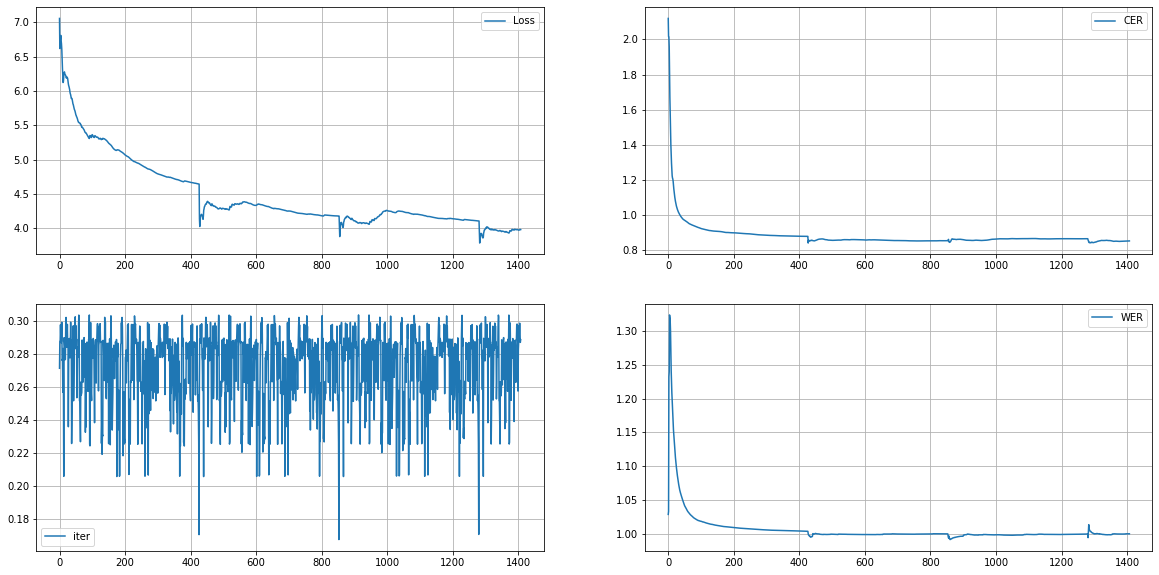

In [ ]:
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten()
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    
    axes[2].plot(history['time_per_iter'], label='iter')
    axes[2].legend(); axes[2].grid()
    axes[3].plot(history['wer'], label='WER')
    axes[3].legend(); axes[3].grid()
    
    plt.show()

In [ ]:
calculate_cer(y, argmax_decoding,y_lengths,x_lengths)

нельзя допустить чтобы наличие других приоритетов увело нас в сторону от решения этой задачи -----    ои ои ри
мы приближаемся к еще одному событию которое станет для нее испытанием ----- и ои ри
в свете вышесказанного наша делегация проголосовала за эту резолюцию -----  и поа ои
практические решения можно находить на основе диалога между нашими заинтересованными субъектами -----    о ороеи ои
нам нужна открытость взглядов и такой подход который будет акцентировать внимание на конечной цели ----- о оо  ои ои
южная африка попрежнему преисполнена решимости способствовать достижению этой цели ----- ои еи и ои
таким образом выступления будут ограничены объяснением мотивов голосования ----- о  о и ееи ра
организации объединенных наций надлежит и впредь руководить нашими усилиями в обеспечение эффективной траты средств ----- о ене е о ре рей
система организации объединенных наций является важным фактором преодоления этого кризиса ----- еи ее о  о ори
втретьих она должна усилить подотчетность

(0.8891274536517614, 1.0, '')

In [ ]:
!nvidia-smi

Sat Oct 16 14:29:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   2949MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### QUARTZNET

In [ ]:
wandb.init(project='QUARTZNET', entity='mishaya')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config = wandb.config          # Initialize config
config.batch_size = 20          
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 3e-4               # learning rate (default: 0.01)
config.log_interval = 1     # how many batches to wait before logging training status

In [ ]:
from torchsummary import summary
class Quartznet_Block(nn.Module):
    def __init__(self, input_ch, output_ch, kern_size):
        super().__init__()

        self.blocks = nn.ModuleList([ nn.ModuleList([
            nn.Conv1d(in_channels = input_ch if i==0 else output_ch,
                      out_channels=output_ch,
                      kernel_size=kern_size,
                      groups=input_ch if i==0 else output_ch,
                      padding= kern_size //2 ),
            nn.Conv1d(output_ch,
                      output_ch,
                      kernel_size=1),
            nn.BatchNorm1d(output_ch),
            nn.ReLU(),
        ]) for i in range(5)
         ])
        
        self.residual_conv = nn.Sequential(  
            nn.Conv1d(input_ch, output_ch, kernel_size=1),
            nn.BatchNorm1d(output_ch),
        )
    def forward(self, x):
        x_befor_blocks = x
        for i, block_iter in enumerate(self.blocks):
            for j, layer in enumerate(block_iter):
                    if  (i == len(self.blocks) - 1 and j == len(block_iter) - 1):
                        x = layer(self.residual_conv(x_befor_blocks) + x)
                    else:
                        x = layer(x)
        return x 

In [ ]:
class Quartznet(nn.Module):
    def __init__(self, input_channels, vocab=34):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=256,  kernel_size=33, stride=2, padding=33 // 2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        self.block1 = nn.Sequential(
            Quartznet_Block(256,256,33),
            Quartznet_Block(256,256,39),
            Quartznet_Block(256,512,51),
            Quartznet_Block(512,512,63),
            Quartznet_Block(512,512,75)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, groups=512,  kernel_size=87, dilation=2, padding=86 ),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=1024,  kernel_size=1, stride=1, dilation=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=vocab,  kernel_size=1,  dilation=1),
        )

    def forward(self, x):
        e0 = self.conv1(x)
        BB = self.block1(e0) 
        e1 = self.conv2(BB)
        e2 = self.conv3(e1)
        e3 = self.conv4(e2)
        return e3


In [ ]:
net = Quartznet(64,34).to(torch.device('cuda'))
summary(net,(64,10))

In [ ]:
NUM_EPOCH = config.epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Quartznet(input_channels=64, vocab=34).to(DEVICE)
criterion = nn.CTCLoss(blank=0).to(DEVICE) #balnk ^ == 0 index
mel_featurizer = Featurizer().to(DEVICE)

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part11__added_Aadam_lr_0_00005.pt'))

<All keys matched successfully>

In [ ]:
!pip install fast-ctc-decode

In [ ]:
!pip install torch-optimizer

In [ ]:
import torch_optimizer as optim


In [ ]:
# optimizer = optim.NovoGrad(model.parameters(), lr=0.5,betas=(0.95, 0.5),weight_decay=0.001)

In [ ]:
learning_rate = 0.5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.93, 0.9995),)

In [ ]:
from fast_ctc_decode import beam_search, viterbi_search

In [ ]:
def beam_serch_eval(batch):
    batch = batch.exp().to('cpu').detach().numpy()
    alphabet = "^абвгдежзийклмнопрстуфхцчшщъыьэюя "
    pred_list = [(beam_search(element.T, alphabet, beam_size=40, beam_cut_threshold=10**(-40)))[0] for element in batch]
    return pred_list


In [ ]:
def calculate_cer_beam(targets,decodings,y_lengths):
    """
    Calculate the Levenshtein distance between predictions and GT
    """
    numper_exmapes = 2
    alph = Alphabet()
    cer = 0.0
    wer = 0.0
    targets = targets.detach().tolist()
    for i, target in enumerate(targets):
        targets[i] = target[:y_lengths[i]]
    pairs = ""
    for target, d in zip(targets, decodings):
        target = alph.int2char(target) 
        cer += calc_cer(target, d)
        wer += calc_wer(target, d)
    
    for tar, pred in zip(targets,decodings):
        pairs = "True: "+ alph.int2char(tar) +" -- "+"Predic: " + pred
        break
    return cer / len(targets), wer / len(targets), pairs

In [ ]:
from collections import defaultdict
history = defaultdict(list)

In [ ]:
import torch.nn.functional as F

In [ ]:
# torch.nn.utils.clip_grad_norm_()

Epoch: 2


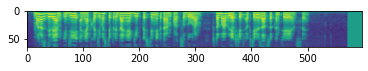

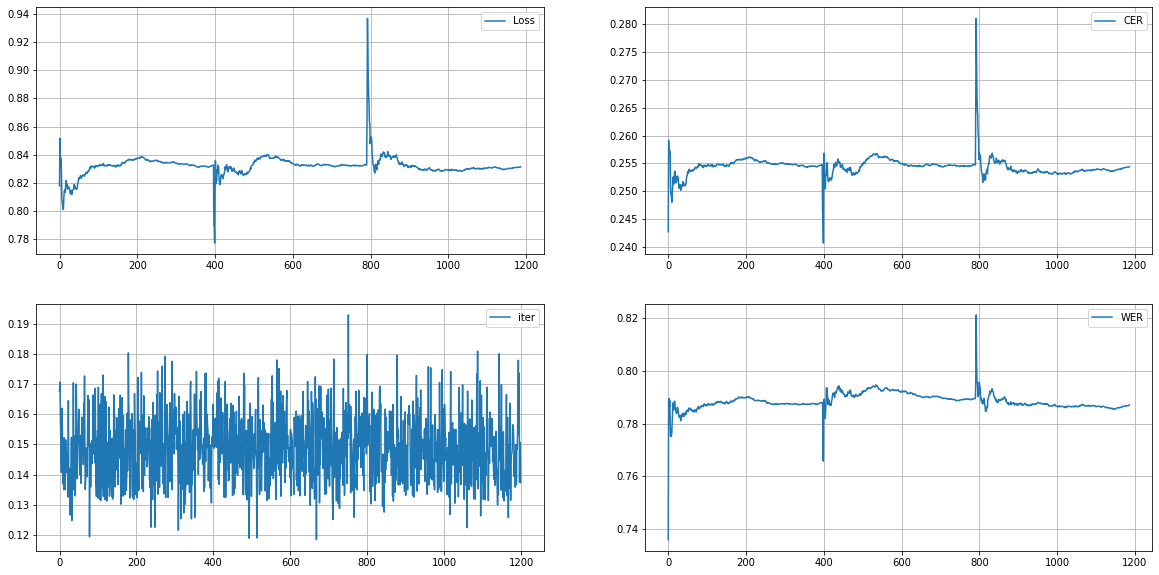

  0%|          | 1/1780 [00:04<2:05:39,  4.24s/it]


True:  осуществление всеобъемлющего мирного соглашения стало свидетельством важности посредничества и руководства в регионе 
 Predic:  о существление всеобъемрюще о мирого соглаушения оставосвидеьестом важности посредничество руковоспов региони

True:  говорили они про торги да про покупки про крупу да про подкрупки 
 Predic:  говориялия не протоги допроповутке покрууа дапро поткрупи
Train cer= 0.2764433716878271
Train wer 0.8494971694971694


  0%|          | 2/1780 [00:04<1:00:04,  2.03s/it]


 ******************************************************************************************************************************************************


  0%|          | 3/1780 [00:08<1:17:35,  2.62s/it]


True:  важно чтобы совет мог выполнить свой мандат во всех аспектах 
 Predic:  важны чтобы совет могвныполните своймандат ва всех аспекта

True:  он был создан как наглядное учебное пособие для всего общества 
 Predic:  он боу созо как ногрят нов чеоно жосогое дле всего вобщества
Train cer= 0.2791489968691975
Train wer 0.8112448662448661


  0%|          | 4/1780 [00:08<54:12,  1.83s/it]  


True:  под свист шум и улюлюканье спрятав голову в плечи квакин медленно пошел прочь 
 Predic:  а свесте шо и улюлюл коне спрятов гоного вплече клаки медля на пошал прочь

True:  третье направление которому наша страна придает большое значение  это вопрос мира и безопасности 
 Predic:  трети натпопления которыом наша страна приветбольшое значения пэт вобросмрт и безопасности
Train cer= 0.2584124879390969
Train wer 0.8011294261294262


  0%|          | 5/1780 [00:11<1:09:25,  2.35s/it]


True:  не платят оброка 
 Predic:  не платетабока

True:  мы хорошо помним как мы праздновали свою вновь обретенную свободу и независимость 
 Predic:  мы хорошо помнемкак мтправдоалалесвои вно беченоу сгоду и заисн
Train cer= 0.2558596685760554
Train wer 0.7868291893291892


  0%|          | 6/1780 [00:12<51:29,  1.74s/it]  


True:  нет этого нельзя сказать 
 Predic:  нет деэтого нельзаскзать

True:  как правило постояльцы не мужчины 
 Predic:  как провил постояьте не м ущины
Train cer= 0.2511607886431379
Train wer 0.7930713730713729


  0%|          | 7/1780 [00:15<1:04:52,  2.20s/it]


True:  следующий выступающий  представитель эфиопии посол гетахун 
 Predic:  ся дующе выступающий представителя фри посол не тохом

True:  мы признаем ее ведущую роль в укреплении глобальной безопасности и в содействии международной стабильности 
 Predic:  вы п знагем еявлидущую роли укурепления глобальномезопасности и содийстви международной стабильности
Train cer= 0.2503105623423238
Train wer 0.7537064787064786


  0%|          | 8/1780 [00:16<50:00,  1.69s/it]  


True:  я также приветствую посла танина и благодарю его еще раз за выступление в совете 
 Predic:  я дтакже привес поса тонина рта и бгодкрего еще раза выступрени светь

True:  нестабильность у своего порога не нравится никому 
 Predic:  стапильность све попарау коенидрается не коану
Train cer= 0.26070751328907776
Train wer 0.7910521885521885


  1%|          | 9/1780 [00:19<1:03:31,  2.15s/it]


True:  несмотря на трудные экономические условия финляндия смогла выполнить свои обязательства по оказанию международной помощи 
 Predic:  есмо трявотрупные эколотические услови ригяндесво млао поничние обязательствобо кажаи мастутород пый полши

True:  необходимо приложить все усилия для выхода из тупика в израильскопалестинских переговорах 
 Predic:  еобходим преложиньси вусиния для ныходастпупекажы гиратьс ко полетински стередоможиее
Train cer= 0.27941454468231847
Train wer 0.837950244200244


  1%|          | 10/1780 [00:19<49:17,  1.67s/it] 


True:  таким образом планируем и дальше иметь положительную динамику роста рождаемости наметившуюся в последние годы 
 Predic:  таким образом планивме митарщей имеет положительнаединами ково росто рождаености нометилшиесяв посредни годы

True:  я говорю об этом на различных площадках и я повторю свои мысли здесь 
 Predic:  ля говораоб этом назичных прощебтах яэ овторесоно сноздась
Train cer= 0.25279615525987204
Train wer 0.7914802327302326


  1%|          | 11/1780 [00:22<59:07,  2.01s/it]


True:  он побледнел и с минуту не мог перевести дыхания 
 Predic:  он поведнел су слива тринемо переностевехани

True:  двенадцать рубах полотняных голландских с манжетами на десять рублей 
 Predic:  динацетрубпах полатд неннаголасли сможетеми нодисят рубле
Train cer= 0.2693612618269178
Train wer 0.8011242923742923


  1%|          | 12/1780 [00:23<49:48,  1.69s/it]


True:  мы также должны быть готовы к этому 
 Predic:  мы также должны пыьедотовы  этому

True:  кучер филипп и конторщик испытывали то же чувство 
 Predic:  куче фери при комточек испетыва ли тоже чиства
Train cer= 0.22534550090935548
Train wer 0.7734705572205574


  1%|          | 13/1780 [00:26<58:46,  2.00s/it]


True:  вы я думаю слыхали о ней 
 Predic:  вы я думаю сухаляне

True:  это касается в частности указанных ниже трех моментов 
 Predic:  эткасается в частности укала ных мижет трехк моментов
Train cer= 0.25801171589861893
Train wer 0.7593656806156802


  1%|          | 14/1780 [00:27<49:24,  1.68s/it]


True:  если бы сделали то же да с расчетом 
 Predic:  иесли бо сдела ли тожет посрасетом

True:  три 
 Predic:  три
Train cer= 0.26670627367146993
Train wer 0.810117243867244


  1%|          | 15/1780 [00:30<57:56,  1.97s/it]


True:  она олицетворяет собой безграничную энергию и потенциал будущих лидеров 
 Predic:  оналица творяет с вооб с граничныго ерви потенциал будущих мвденов

True:  буэносайрес  столица аргентины 
 Predic:  буд нас  арас толицакиккини
Train cer= 0.27019530020233345
Train wer 0.7910636123136121


  1%|          | 16/1780 [00:31<52:00,  1.77s/it]


True:  вовторых это могло бы способствовать уменьшению ядерной угрозы 
 Predic:  повстарыих  это момоосносовбстсово зуменшению ятдерной угооса

True:  рыла свиньябелорыла тупорыла полдвора рылом изрыла вырыла подрыла 
 Predic:  приласия долорла прела олгворарленем зырела вырило потрыня
Train cer= 0.24819206247309317
Train wer 0.7858626096126096


  1%|          | 17/1780 [00:33<57:24,  1.95s/it]


True:  первая  глубинное исследование недр и сверхглубокое бурение 
 Predic:  пява лубиннос ьследование медр и севергубогоебурения

True:  в нашем городе чересчур много жителей приезжих и много машин 
 Predic:  ты наша мормиччесчероногажатей приеже и мново моше
Train cer= 0.27065153617024146
Train wer 0.8125345950345951


  1%|          | 18/1780 [00:35<53:38,  1.83s/it]


True:  труби николай вот и ограда 
 Predic:  труби николай вот ограда

True:  тут нужно быть очень осторожным 
 Predic:  тык муж но быть оченье сторожном
Train cer= 0.2468745452382285
Train wer 0.7772603785103783


  1%|          | 19/1780 [00:37<55:55,  1.91s/it]


True:  да 
 Predic:  да

True:  эй робот а ну иди работать 
 Predic:  э робат а у беробатать
Train cer= 0.27363958006577177
Train wer 0.8100632238132236


  1%|          | 20/1780 [00:39<54:00,  1.84s/it]


True:  мы надеемся на поддержку данной инициативы со стороны государствчленов 
 Predic:  апес на поддерж ко дано иницати вы стороный осудорасвчленов

True:  по некоторым сообщениям правительство занимается также развертыванием вооруженных сил вдоль границы с тунисом 
 Predic:  онекотрум соажение правительтв занимается такжя развертване воораженных сил ук доогранит с спруницу
Train cer= 0.259345807776463
Train wer 0.7410677748177749


  1%|          | 21/1780 [00:41<58:02,  1.98s/it]


True:  ко мне пришла делегация 
 Predic:  омне пришо делегация

True:  черногория уделяет особое внимание проблемам изменения климата 
 Predic:  черногоре  буделяет особое внимание проблемам биз нения кликац
Train cer= 0.23973353453791268
Train wer 0.7596182521182521


  1%|          | 22/1780 [00:42<53:46,  1.84s/it]


True:  я обещаю им что мы будем продолжать поддерживать их 
 Predic:  я обещаюне что буде продолжать поддерживатех

True:  просто физическое расстройство 
 Predic:  портатитическое растройство
Train cer= 0.24237946891258738
Train wer 0.782835544085544


  1%|▏         | 23/1780 [00:45<1:00:59,  2.08s/it]


True:  поэтому принцип национальной ответственности является столь важным 
 Predic:  протому пранципнециеналние ответствностидвяатся что дожны

True:  он не смог получить доступ или управление над приложением другого клиента 
 Predic:  он не смо пулучить досту илиуправления на приложением другогоклиенты
Train cer= 0.22361754007646276
Train wer 0.7351876364376363


  1%|▏         | 24/1780 [00:46<53:24,  1.82s/it]  


True:  наш долг  всячески содействовать реализации этого принципа четко прописанного в конвенции 
 Predic:  наш дылг всянческий содействоваит ализация этого принца почетко пропесаноов конвенции

True:  при этом вопросам разоружения и нераспространения уже давно должно уделяться одинаковое внимание 
 Predic:  приетом вопросам разоружения нераспространения уже богноо емно удлятсодимоколоевнимае
Train cer= 0.23513962036287472
Train wer 0.7450992525992526


  1%|▏         | 25/1780 [00:49<59:47,  2.04s/it]


True:  план действий представляет собой значительный шаг вперед 
 Predic:  плал зействий представляюет собой зачительный шаь вперед

True:  доклад комиссии по разоружению генеральной ассамблее на ее шестьдесят шестой сессии 
 Predic:  дтокомисси по разоружению генеральной ассамблееннае ее шистьдесят шестпойи сессии
Train cer= 0.25187677963409
Train wer 0.8155751193251193


  1%|▏         | 26/1780 [00:50<54:21,  1.86s/it]


True:  девять миллионов человек попрежнему ожидают лечения и их жизнь находится в опасности 
 Predic:  деветь мижел нам человек попрежнемуожида отлючения и иех жит находится вопасности

True:  мы выражаем особую признательность специальному представителю генерального секретаря кубишу 
 Predic:  м мвражаемо особылю признательностьпециальному представителю генерального секретарякудишу
Train cer= 0.23896192837311175
Train wer 0.749909396159396


  2%|▏         | 27/1780 [00:52<58:09,  1.99s/it]


True:  региональная интеграция несомненно сыграла важную роль в стимулировании торговли инвестиций и развития 
 Predic:  региональное инфеграци несомнен ны сеграла важнму роль стимулировни корабговенестиций и развития

True:  мне весьма приятно отметить активное и конструктивное участие государствчленов в работе нынешней сессии 
 Predic:  ни весьма приятно отмедить активно и коанструктивне участие государтвчленов в работем ны нешнейсессии
Train cer= 0.2601771523710085
Train wer 0.7844375069375068


  2%|▏         | 28/1780 [00:54<54:50,  1.88s/it]


True:  мы планируем продолжить работу в этом направлении 
 Predic:  мы планирнем продолжит работу в этом направления

True:  взять пример ливии когда совету безопасности удалось предотвратить массовую резню в бенгази 
 Predic:  зят при мерыми вии когдга стовету безопасность удалось предспратить м асолойризню бенгази
Train cer= 0.25455486874771016
Train wer 0.767151690901691


  2%|▏         | 29/1780 [00:56<59:08,  2.03s/it]


True:  подружитесь с ним 
 Predic:  подружиь снм 

True:  а какая была коза 
 Predic:  о какоя былаказа
Train cer= 0.24379251121025589
Train wer 0.7507363932363932


  2%|▏         | 30/1780 [00:58<57:29,  1.97s/it]


True:  мы должны определить надлежащие приоритеты и сосредоточить все усилия на их достижении 
 Predic:  мы должены предени кудндяащий приритеты и сосредетучин все усилияные достижени

True:  затем проследите за установкой компьютеров 
 Predic:  затем проседитесобстановка комфитеров
Train cer= 0.23052627790627303
Train wer 0.7570818533318533


  2%|▏         | 31/1780 [01:00<53:11,  1.82s/it]


True:  для изменения мощности оборудования необходимо физическое вмешательство в устройство 
 Predic:  дале ихзменение можшностия оборудоне необходимы хфизическоеанме шательство густрольства

True:  правду сказать мы поступили с софьюшкой как с сущею сироткой 
 Predic:  правду сказать мо поступиле с софлишколь как суще сиродтой
Train cer= 0.263319224901145
Train wer 0.7554619917119916


  2%|▏         | 32/1780 [01:02<1:00:22,  2.07s/it]


True:  важно отметить что многие развивающиеся страны попрежнему не имеют доступа к эффективным технологиям 
 Predic:  мож отметьть что многиразвывающиейся страны попрежнемуние имееют слоступокоффктивнымн тих нлодгям

True:  эти рабочие группы соберутся в панаме 
 Predic:  эте рабоьчи группо сверутся в понами
Train cer= 0.2410399339199318
Train wer 0.7854816017316018


  2%|▏         | 33/1780 [01:04<53:10,  1.83s/it]  


True:  а вы занимаетесь химией 
 Predic:  довозанимать сь ими

True:  несколько подростков опрокинули мобильный туалет 
 Predic:  несклько подроско по протиналимабильни толет
Train cer= 0.23662834302541552
Train wer 0.7700566563066562


  2%|▏         | 34/1780 [01:06<56:48,  1.95s/it]


True:  на ближнем востоке есть еще один народ чьи устремления должны быть признаны 
 Predic:  на ближнемв остоки ест есща оде народ чти устремнение должны муть признамо

True:  они носят весьма неформальный характер 
 Predic:  онни новосяот весьманефармальный харктера
Train cer= 0.2543559125525627
Train wer 0.7758562271062269


  2%|▏         | 35/1780 [01:07<49:05,  1.69s/it]


True:  ну думаю человек я теперь одинокий заступиться некому а много ли мне старой надо 
 Predic:  мо думаюе человекиэтеперединогиеи са спупиться некому а мноволи мн сторый надо

True:  таиланд поддерживает создание во всем мире зон свободных от ядерного оружия 
 Predic:  тало поддерживает созданиво всем миресон сво бодных от ядерного оружия
Train cer= 0.23506876792705816
Train wer 0.7627286139786141


  2%|▏         | 36/1780 [01:10<59:17,  2.04s/it]


True:  осуществление договора проходит успешно и способствует улучшению отношений между соединенными штатами и российской федерацией 
 Predic:  осуществление договора проходит успешнн и способствуат улучшениюра отношение ежду соедиенны штатами ироссийской фенерации

True:   я не знаю какой вы инженер но чините вы машину както очень странно 
 Predic:  я не зна какой выщенмерылног чените в машину както починьстралины
Train cer= 0.2590162641648465
Train wer 0.7967566230066228


  2%|▏         | 37/1780 [01:11<47:00,  1.62s/it]


True:  я выработал эту позицию но ее можно дорабатывать используя другие предложения 
 Predic:  я врюбытов эту позециио нию можно дорапатовать истоль зу другии прложения

True:  у нас произошла самая страшная на нашей памяти экономическая и социальная катастрофа 
 Predic:  нас поро сласовно строшнаеона нашей палете эконорийскае социвальное тодонствуху
Train cer= 0.27123566446739134
Train wer 0.8560995948495945


  2%|▏         | 38/1780 [01:14<1:01:44,  2.13s/it]


True:  семьдесят девять миллиардов семьсот шестьдесят пять миллионов девятьсот тридцать семь тысяч четыре 
 Predic:  селвий ссдеть мелядов сеимсошатисет пее миионов даюетцсяот придсисемь трсичетыре

True:  однако безопасность всех наших сотрудников национальных и международных имеет первостепенное значение 
 Predic:  онао обезопасностиях наших сотруднигов националь ных международных иня перостепенное значения
Train cer= 0.20501810455006497
Train wer 0.7269862544862542


  2%|▏         | 39/1780 [01:14<48:03,  1.66s/it]  


True:  и после войны все это было для меня очень тяжким 
 Predic:  и посливае мевте это было для меня оченьтажки

True:  благодарю посла японии за добрые слова в адрес председателя 
 Predic:  благодарю послоепони за добрые словавадрес председателяю
Train cer= 0.2576669805469275
Train wer 0.7972200484700483


  2%|▏         | 40/1780 [01:18<1:04:22,  2.22s/it]


True:  демократию необходимо строить шаг за шагом терпеливо пестуя ее с низового уровня 
 Predic:  демократи необходимо стройть ша зашагом ех перлиыпестоеестне загово уровне

True:  изменение климата попрежнему должно быть мобилизующим фактором несмотря на очевидные препятствия 
 Predic:  зменение клинты попрежнему должны быть мыобелизувующим факторы смтряначевидное пребетствия
Train cer= 0.2777992626813404
Train wer 0.794767501017501


  2%|▏         | 41/1780 [01:19<50:37,  1.75s/it]  


True:  мы стали одним из авторов соответствующей резолюции 
 Predic:  носталян нем заопосоответствующй резовлюции

True:  через несколько дней генеральная ассамблея и совет безопасности выберут шесть судей 
 Predic:  в через не свльпобнеиге ерально асамблересе безопасности выйбвучшейс судий
Train cer= 0.23527207040250936
Train wer 0.7955229955229957


  2%|▏         | 42/1780 [01:22<1:01:11,  2.11s/it]


True:  смешная потому и приметная 
 Predic:  слешное потому и переметно

True:  они должны быть завоеваны и подкреплены другими победами которые невозможно навязать извне 
 Predic:  они должны бы зоваианный подкикптленые другими подбедами которо не возможноаннабизатьсе з вни
Train cer= 0.23824649283093374
Train wer 0.7089281551781552


  2%|▏         | 43/1780 [01:22<47:49,  1.65s/it]  


True:  в связи с этим возникает важный вопрос 
 Predic:  всвязис с эти мвызника т важный вопрос

True:  я знаю что бабушка про махно чтото там говорила но без неприязни 
 Predic:  я знаю что быбушик промас ношчтот тон говорила но безне приязны
Train cer= 0.23663568818020286
Train wer 0.807377761127761


  2%|▏         | 44/1780 [01:25<58:52,  2.03s/it]


True:  мы не имеем ни морального ни общечеловеческого права ничего не делать 
 Predic:  мы мемем немарального ня обще человеческог рава ничего не делаь

True:  мы хотели бы сделать это и сегодня 
 Predic:  мы хотели бы сделать это сегодня
Train cer= 0.24228754153252613
Train wer 0.749104229104229


  3%|▎         | 45/1780 [01:26<46:58,  1.62s/it]


True:  ну там вроде и сидушка и руль регулируются 
 Predic:  тавротельсидуушка еру  рикулеють

True:  да во здравие матушка 
 Predic:  да вы зтравя мотушко
Train cer= 0.23725438106161045
Train wer 0.7557194194694191


  3%|▎         | 46/1780 [01:29<58:23,  2.02s/it]


True:  историческую самобытность испании нельзя понять без учета арабского и еврейского наследия 
 Predic:  стческойс мобытност испаненельзя паняе дл четоравбскго ивеийского наследе

True:  ночь была тихая и морозная 
 Predic:  ночь боатиха и марзно
Train cer= 0.2473025126038029
Train wer 0.7716483978983978


  3%|▎         | 47/1780 [01:30<48:31,  1.68s/it]


True:  теперь я предоставляю слово представителю австралии 
 Predic:  теперь я представляю слово представителю австоралии

True:  гена уже нацепил подводную маску и трубку 
 Predic:  ге на уженаьцяпил подводнуе маскуй итругку
Train cer= 0.24097969794651516
Train wer 0.7816243016243015


  3%|▎         | 48/1780 [01:32<59:35,  2.06s/it]


True:  он тоже был одним из тех которые были упомянуты пакистаном 
 Predic:  он то же былаен нестех которое будюм помянта пакистана

True:  мы простые смертные должны решать проблемы искоренения нищеты болезней голода неграмотности и конфликтов 
 Predic:  мы простоеь смертны должны решат проблема искоренения нешеты нолезни говоб негравотности и конфликтав
Train cer= 0.24674436099951907
Train wer 0.7828409553409553


  3%|▎         | 49/1780 [01:33<46:40,  1.62s/it]


True:  это конечно потребует дополнительных и адекватных ресурсов 
 Predic:  этоконечно потревот дополнитных и адоквдных рестурса

True:  сохранить жизнь на земле  это наш долг перед грядущими поколениями 
 Predic:  сохраничисз недзеямвля это нашстол предпредующеие поколеними
Train cer= 0.23771031082723024
Train wer 0.7570370832870832


  3%|▎         | 50/1780 [01:36<1:01:08,  2.12s/it]


True:  но пока этой цели не удалось достичь там где это необходимо 
 Predic:  нпока этой целе не удоостностьт ичтам пгдеэто необходимо

True:  поэтому пожалуйста не могли бы вы также следовать этой просьбе 
 Predic:  поэтому пожалуйстани мотрибывое также следоветь этй прольда
Train cer= 0.24118043353636706
Train wer 0.7806191031191031


  3%|▎         | 51/1780 [01:37<51:18,  1.78s/it]  


True:  демократия и верховенство права являются самыми надежными гарантиями свободы но они требуют напряженной работы 
 Predic:  демокраетии иерх овентство права является сомоеми надежнмы гарантиими свободы но нетребут набизаной раготы

True:  свободный ливийский народ должен сам определить свою судьбу без какоголибо вмешательства извне 
 Predic:  свободной ивиский народ должен само продвиь свя суьбу нескокоголибо вмешательство изваня
Train cer= 0.2276194099460631
Train wer 0.7367209642209641


  3%|▎         | 52/1780 [01:40<1:01:01,  2.12s/it]


True:  да здравствует здоровье всех народов мира 
 Predic:  дзрдраднствоуат здороне всех народо в мира

True:  да 
 Predic:  да
Train cer= 0.2422386461763861
Train wer 0.7542596755096755


  3%|▎         | 53/1780 [01:41<51:59,  1.81s/it]  


True:  китай также глубоко озабочен событиями в сирии 
 Predic:  китай также глубоко забочень забытими сиии

True:  мы не видим необходимости в новых партнерствах 
 Predic:  мы не видинеобходимостипновых паркумарствах
Train cer= 0.23624960408504697
Train wer 0.7367772967772966


  3%|▎         | 54/1780 [01:44<1:01:10,  2.13s/it]


True:  этот затор имеет прежде всего политические корни 
 Predic:  этот затор и меет прежды всего политический корме

True:  для все большего числа людей они являются самым дешевым способом насыщения голодного желудка 
 Predic:  я всебольшем ьисловлюдемн являетс я самм дешем спозоб ные сещения ководного жалутком
Train cer= 0.26513782122969914
Train wer 0.8289922114922115


  3%|▎         | 55/1780 [01:45<51:16,  1.78s/it]  


True:  все чаще звучат требования об изменении нашего образа жизни и работы 
 Predic:  сейчасше зучат тривоания обизменения нашего проазвожитзь иед работы

True:  головной офис фирмы находился в новосибирске 
 Predic:  омны офеслиемы на ходил саноло сеперьзки
Train cer= 0.2696683016232161
Train wer 0.8253057128057126


  3%|▎         | 56/1780 [01:48<1:00:12,  2.10s/it]


True:  есть и другие угрозы международному миру и безопасности 
 Predic:  дести другии угроза международному миру и безопасности

True:  таковы реалии современного мира 
 Predic:  тако в еяаали с временноло мера
Train cer= 0.25908933866434425
Train wer 0.8091623654123653


  3%|▎         | 57/1780 [01:49<51:21,  1.79s/it]  


True:  ситуация требует от всех государствчленов повторного подтверждения политической приверженности и свежего мышления 
 Predic:  ситуация ревудат все гозсударствлянов павтоаного пыторжданияе политическое привежнностьи селяжовао мнашления

True:  как вот этак сделаю он так и просияет голубчик 
 Predic:  как вот это зсделю онтаку просяет голучик
Train cer= 0.2713160218307804
Train wer 0.8279914529914529


  3%|▎         | 58/1780 [01:52<59:56,  2.09s/it]


True:  все это вздор  сказал он с надеждой  и нечем тут было смущаться 
 Predic:  все этом сдуорсказалко снадежды и нечем ту былослмущаться

True:  я хотел бы выразить искреннюю признательность генеральному секретарю за выраженные им соболезнования и сочувствие 
 Predic:  я хотел бы вбразить искренмю признательнос венеральному секретарию запоражению иг собализвамеди сочуствуе
Train cer= 0.24796882609092297
Train wer 0.773117993117993


  3%|▎         | 59/1780 [01:53<53:22,  1.86s/it]


True:  было высказано уточнение 
 Predic:  было высказано уточнение

True:  а это неоспоримо требует предпринять переговоры 
 Predic:  а это не оспоимн трибует предпринять переговоры
Train cer= 0.24666160640495038
Train wer 0.7524666999667


  3%|▎         | 60/1780 [01:56<1:00:16,  2.10s/it]


True:  сегодня этот показатель почти вдвое выше 
 Predic:  несего не  покая  о паетьивдроет зу

True:  а это может заложить полезную основу для дипломатов когда позднее те фактически начнут переговоры 
 Predic:  а этом муж зложи порезную осново дляди вломасохв кодо позне те патически нерчнум переговоры
Train cer= 0.2531228050903619
Train wer 0.7645976708476708


  3%|▎         | 61/1780 [01:57<51:36,  1.80s/it]  


True:  ценю ваш напор но моя комната наверху 
 Predic:  тене мунуотор наная колнятанедерху

True:  прошло шестьдесят лет  и положение дел не сдвинулось с места ни сантиметр 
 Predic:  прошло шетьдсят лет и положения дила не здроло свместа неснкиметр
Train cer= 0.22886198854847067
Train wer 0.7722876660376661


  3%|▎         | 62/1780 [02:00<59:18,  2.07s/it]


True:  растет ощущение безопасности и законности в палестинских общинах на западном берегу 
 Predic:  простет ощущение безопасности и заптонности в палестинских общинах назаподном герегу

True:  но для этого ей надлежит переосмыслить себя и адаптироваться 
 Predic:  нодля этогойдей на дежить тетны ят и  дактивовата
Train cer= 0.25218372039600795
Train wer 0.7572648647648648


  4%|▎         | 63/1780 [02:01<50:06,  1.75s/it]


True:  борьба с нищетой и неравенством попрежнему является нашей главной задачей 
 Predic:  мырбосящчтоу ениравестом попреему ювляется наше главноь дачи

True:  однако как мы видим это уже не так 
 Predic:  однака кпа к нывидем это уже не стак
Train cer= 0.2366042087572894
Train wer 0.7397687497687498


  4%|▎         | 64/1780 [02:03<57:45,  2.02s/it]


True:  это было бы опасным попятным шагом 
 Predic:  это было бр опасном потятным шагом

True:  цель разоружения заключается в том чтобы содействовать глобальному миру и безопасности 
 Predic:  селе разоружения заключеть в та чтобы содействеалаэт глобальному миру и безопасности
Train cer= 0.22527905122549585
Train wer 0.7220823158323159


  4%|▎         | 65/1780 [02:05<52:08,  1.82s/it]


True:  в равной степени оно проявляется и в работе комиссии по разоружению и первого комитета 
 Predic:  вравностепни онапроявляется вработе комисси по разоружению и перокомитета

True:  ты запихай язык в рот и пусть он там и лежит на своем месте 
 Predic:  запихая зейкрот и пусчтомтамо лежить на своем месте
Train cer= 0.2743037403815029
Train wer 0.7836287786287783


  4%|▎         | 66/1780 [02:07<56:31,  1.98s/it]


True:  ноль 
 Predic:  ноль

True:  мы все знаем что последствия бездействия будут ужасающими 
 Predic:  мы всея знаем что последствуе бездействия абудут ужасающими
Train cer= 0.22666657792814826
Train wer 0.7289421226921228


  4%|▍         | 67/1780 [02:09<52:57,  1.85s/it]


True:  все эти политические вопросы должны быть частью переговорного пакета 
 Predic:  все эти политическе вопросы должены мечастьи ереговорного патена

True:  организация работы утверждение повестки дня и распределение пунктов доклады генерального комитета 
 Predic:  олизция работы вувурждения првости днла вмерсредения пуктов ноклабгенераьной комитедя
Train cer= 0.2411737469864668
Train wer 0.764532227032227


  4%|▍         | 68/1780 [02:11<53:38,  1.88s/it]


True:  появляются новые угрозы международной безопасности 
 Predic:  появлряется новы е уграоза международной безопасности

True:  сегодня терроризм попрежнему является бичом международного сообщества 
 Predic:  сегодня тераризн попрежнему является вече международного сообщества
Train cer= 0.23186641984070083
Train wer 0.7451450401450401


  4%|▍         | 69/1780 [02:12<53:47,  1.89s/it]


True:  ее суть заключается в честном международном сотрудничестве в основе которого  дух оптимизма и позитивизма 
 Predic:  ея су ь заключается вчестом международнох сотрудничестве васноя которог ду аткимизна и позятивизма

True:  эти пять государств не могут быть переизбраны 
 Predic:  т аьго сдростнобунопетд прейзрани
Train cer= 0.2550597559387703
Train wer 0.8238396325896322


  4%|▍         | 70/1780 [02:14<54:09,  1.90s/it]


True:  так вот как наконец ты кандидат и домой приехал 
 Predic:  такод ак накрнестокин кидта ы бо мой порехл

True:  доклад представляет собой сбалансированный консенсусный документ что в значительной мере соответствует требованиям правил процедуры 
 Predic:  докла представляетс гоизбалансироан консенсуснадокуме что взначительно мере сяответствутктееобанием правел процедура
Train cer= 0.25806371062641753
Train wer 0.7995701058201057


  4%|▍         | 71/1780 [02:16<54:35,  1.92s/it]


True:  технология контейнеризации похожа на технологию традиционной виртуализации 
 Predic:  тено оге конденелизации похоено теивногокги пердеционный ртанлизаци

True:  молодежи принадлежит не будущее а настоящее 
 Predic:  олодежи привлежит не будуще нстояще
Train cer= 0.2672767147956125
Train wer 0.8372384097384095


  4%|▍         | 72/1780 [02:18<52:20,  1.84s/it]


True:  все это происходит в результате изменения климата 
 Predic:  чеэто приско ьавоезультатье измене ния климат

True:  мы должны разрешить новые и возникающие вопросы и заложить прочный фундамент для будущего сотрудничества 
 Predic:  мы должны разрешитьно вы и возникающе вопросы и золажить правчные сондарне для будущего сотрудничеств
Train cer= 0.25659249628347286
Train wer 0.7770065582565582


  4%|▍         | 73/1780 [02:20<52:38,  1.85s/it]


True:  он может выводить звук на соответствующее выходное устройство 
 Predic:  о мжет во води звуг насоотвествующие ыходноеу устройства

True:  прямые иностранные капиталовложения играют важную роль в экономической жизни каждой развивающейся страны 
 Predic:  примевдимостронни катото вадожени и трть вожный рорутдо кономическа жизна каждо извающех сострений
Train cer= 0.25474745067350235
Train wer 0.7483855958855958


  4%|▍         | 74/1780 [02:21<50:26,  1.77s/it]


True:  обещание данное государствамчленам и народам мира было сдержано 
 Predic:  обещаяние данные государствамачленом и народом мира былоздержанны

True:  и я и моя бригада готовы проводить с любым из вас дальнейшие консультации 
 Predic:  я и мою обрикад готовы проводиь свюбу извас дальнейший консультации
Train cer= 0.24409538146676357
Train wer 0.8029971417471419


  4%|▍         | 75/1780 [02:24<55:11,  1.94s/it]


True:  сегодня праздник 
 Predic:  сегодня праздник

True:  этот проект был признан несколькими региональными конференциями одним из самых успешных в восточной европе 
 Predic:  энот проетаобыл признаманескаьина региональнымиконференциими одгумы фламых успешнох воскочны ероте
Train cer= 0.2641996587118231
Train wer 0.7738557276057274


  4%|▍         | 76/1780 [02:25<49:24,  1.74s/it]


 ******************************************************************************************************************************************************


  4%|▍         | 77/1780 [02:27<52:56,  1.87s/it]


 ******************************************************************************************************************************************************


  4%|▍         | 78/1780 [02:29<50:47,  1.79s/it]


True:  я решился не держать больше у себя вольноотпущенных 
 Predic:  я ршилсянуудержать больш о себавой на от кущенах

True:  в основном эти всесоюзные выставки которые мы ждали с нетерпением 
 Predic:  воснавно итисе союзные выстаки которе междались нитерпениям
Train cer= 0.24500222789200585
Train wer 0.7811988011988011


  4%|▍         | 79/1780 [02:31<53:23,  1.88s/it]


True:  мы признательны всем им за поддержку 
 Predic:  мы признательные сем ин запотиржку

True:  слово имеет представитель мексики 
 Predic:  слово имеет представитель нексики
Train cer= 0.23102607572924658
Train wer 0.7390897065897063


  4%|▍         | 80/1780 [02:33<52:02,  1.84s/it]


True:  нам нужно работать более рационально и вести поиск аспектов взаимодополняемости и достижения обеих целей 
 Predic:  ма оужн работы более и рациональн и вести быт коспекдов варимодопожвенности и дсдвижения и сели

True:  я считаю что без статистики вообще не жизнь 
 Predic:  я считаю что быестатестик и во обще не жизн
Train cer= 0.27710079880492544
Train wer 0.7959090909090907


  5%|▍         | 81/1780 [02:35<56:25,  1.99s/it]


True:  разумеется миссия также проводит работу по проверке мест сообщаемых бомбардировок 
 Predic:  роазумется мисся также провити  роботу попротеки мест заобщаемы мын брдиовог

True:  на протяжении шести месяцев мы видели эскалацию насилия и репрессий 
 Predic:  пот жениешистимезят сзох мониделе ескогваию насилия ирепроссии
Train cer= 0.2566360696779651
Train wer 0.7890404965404966


  5%|▍         | 82/1780 [02:37<52:27,  1.85s/it]


True:  семь 
 Predic:  семь

True:  в эту самую минуту раздался приятный женский голос не бойтесь она не укусит 
 Predic:  пв это сомой менуто надася прятне жос гигорос не потесь онаонел пущ
Train cer= 0.27146191708234996
Train wer 0.7750765900765899


  5%|▍         | 83/1780 [02:39<56:56,  2.01s/it]


True:  я в общемто не особо хотел ехать в саратов 
 Predic:  я лочщенмьто не особы хотел ехотьсаратов

True:  я предпочитаю ездить на поезде 
 Predic:  я препочитаю ездеть на позде
Train cer= 0.26717919474425345
Train wer 0.7975970325970324


  5%|▍         | 84/1780 [02:40<52:06,  1.84s/it]


True:  все мы разделяем стремление к миру свободе справедливости и процветанию наших народов и государств 
 Predic:  все м разделяем стремлениякмиру свобоеиьс правливост процветанию наших ународов и государств

True:  международное сообщество все еще не вышло из глобальной рецессии 
 Predic:  рдународго собщсто всешневу невышо ескоболе сессии
Train cer= 0.26570424298771217
Train wer 0.8113866688866687


  5%|▍         | 85/1780 [02:43<54:40,  1.94s/it]


True:  нет какогото магического средства от нынешнего паралича есть экстренная потребность в политической воле 
 Predic:  нертколкогодомонического средств ынечне о праолечае десть ек свеннай потремы те волитическойволе

True:  я желаю всем огромного успеха в ходе проведения этих важных обсуждений 
 Predic:  я желаювсе обронул успедум поке ровте ипэтит патно туждени
Train cer= 0.25239697486031776
Train wer 0.7756006956006954


  5%|▍         | 86/1780 [02:44<47:31,  1.68s/it]


True:  это содействовало бы усилиям направленным на достижение необходимого в этом вопросе консенсуса 
 Predic:  это содействал об усилим на правлемымия достижени необходимму в этомв проси конценсусвм

True:  стремление сидеть на двух стульях и привело к тому что мы имеем 
 Predic:  стравление сетет наб к стунехи примямок товрушчто быдеи
Train cer= 0.2947327997498794
Train wer 0.8328518703518701


  5%|▍         | 87/1780 [02:46<55:31,  1.97s/it]


True:  и сегодня надо и дальше идти вперед 
 Predic:  исегодня надаи дальшерити пеед

True:  передо мной список выступающих на сегодняшнее заседание 
 Predic:  перждано сьписокв ступрающих анае сео боняшне заседание
Train cer= 0.23602934596259562
Train wer 0.7643681318681317


  5%|▍         | 88/1780 [02:47<48:45,  1.73s/it]


True:  однако для достижения всеобщего доступа потребуются новые модели сотрудничества и новые модели финансирования 
 Predic:  однако длядостижения все о щего доству поподаребуется новоемадали сотруадни чествойновоемадалиф нансированя

True:  международное сообщество наблюдает за страданиями в сомали как будто это художественный фильм 
 Predic:  международное сообщества на людляет зяастралениеми х сомали какбуд то этох оубожественмифер
Train cer= 0.25090689680058587
Train wer 0.8062172549672549


  5%|▌         | 89/1780 [02:50<53:37,  1.90s/it]


True:  словакия полагает что сфера охвата договора будет установлена определениями воплощенными в договоре 
 Predic:  словакие полагает что сфераххвато договуор рабодту установлено определениями моплащеннмив договол

True:  вы говорили он болеет 
 Predic:  во говорилим болеет
Train cer= 0.27160208751166864
Train wer 0.819876882376882


  5%|▌         | 90/1780 [02:51<51:53,  1.84s/it]


True:  контрпродуктивность этой очередной затеи не вызывает сомнений 
 Predic:  конторпобуктиврас этоя чериоен зате не вызывает ся мнений

True:  люди видели эти сюжеты их показывали по телевидению 
 Predic:  лте видели эти се жеты их поканули потелеидеы
Train cer= 0.26491660243510895
Train wer 0.7856556406556405


  5%|▌         | 91/1780 [02:53<53:36,  1.90s/it]


True:  я хотел бы затронуть тему этой сессии  роль посредничества в мирном урегулировании споров 
 Predic:  я хотел бы отронать темате сосиу тороль спосреднимчества мененомолибулировн сфоров

True:  одно верно что эта ночь решила мою судьбу 
 Predic:  одноверно  что это ноч решела маою судьбу
Train cer= 0.2710144100931359
Train wer 0.8160972360972357


  5%|▌         | 92/1780 [02:55<53:05,  1.89s/it]


True:  перед нами стоит трудная задача 
 Predic:  переднаеми стои тррудно задаче

True:  всем тише  раздался в темноте голос тимура 
 Predic:  всемнтише раздалса тимнате  лсти мура
Train cer= 0.2883934584715727
Train wer 0.8307024919524918


  5%|▌         | 93/1780 [02:57<53:57,  1.92s/it]


True:  и в данном случае затянувшееся ожидание может нанести серьезный ущерб конференции по разоружению 
 Predic:  ивданом в случае затенушесо ожидание может намести серьезный учет к онференции по разоружению

True:  вы кто артист 
 Predic:  кто артист
Train cer= 0.2575827204896962
Train wer 0.7529362304362301


  5%|▌         | 94/1780 [02:59<52:12,  1.86s/it]


True:  мы работницы подвергаемся таким унижениям изза своего цвета кожи и экономической зависимости 
 Predic:  мы раболтиия побреляется токим вонежениям и засвоиваться такоже пин кономичеьскй зарисимности

True:  это стало бы важным шагом вперед 
 Predic:  это остало бы важднум шагу впереп
Train cer= 0.27616635983839904
Train wer 0.8343264143264142


  5%|▌         | 95/1780 [03:01<53:55,  1.92s/it]


True:   а что за человек этот пугачев  спросила комендантша 
 Predic:  ч зашмалек это повачев спасла аменбаше

True:  с этой целью данный орган призван избрать всесторонний комплексный и прагматичный подход 
 Predic:  эо цел ьвиданны оргом призвунос братсе сторонни коплисны прогматичной подход
Train cer= 0.2807384245805976
Train wer 0.8447290209790207


  5%|▌         | 96/1780 [03:03<51:54,  1.85s/it]


True:  характеристики рака также уникальны и различия определяющие факторы и барьеры должны быть выяснены 
 Predic:  рактириститирака также униканн и различа определяющию фактры и болеры должны быть овысненны

True:  в этой конкретной области роль организации объединенных наций попрежнему является незаменимой 
 Predic:  в этй ко нжезтное области проль организации объединенныхш дтаций попъежнем являтея н заменимойю
Train cer= 0.23196323689759177
Train wer 0.7639960502460501


  5%|▌         | 97/1780 [03:05<56:31,  2.02s/it]


True:  мы желаем им скорейшего восстановления и прогресса 
 Predic:  мы желаем м скоещи востановление прогрессн

True:  полетели орел да ворон 
 Predic:  потитее оелол жапоре
Train cer= 0.2800460585253178
Train wer 0.8238346838346838


  6%|▌         | 98/1780 [03:06<50:16,  1.79s/it]


True:   это ребятишки по чужим садам озоруют  объяснила ольге молочница 
 Predic:  это евитешки почежим садам азырувют объяснеловольге молочниця

True:  она лежит в основе нашего общего стремления к гуманизму и руководящей миссии этого совета 
 Predic:  ональжит воснови нашег обществремления гуманизму ируководящи нисс этого совета
Train cer= 0.23939584224415708
Train wer 0.7541555666555666


  6%|▌         | 99/1780 [03:09<52:44,  1.88s/it]


True:  исследователи из иллинойса разработали пластиковые материалы которые обладают способностью к самовосстановлению 
 Predic:  и следуателиизенинойс раз работали пластиковомматерялы которыеобладают способностью к сомововстановления

True:  благодарю представителя турции за его заявление и сейчас я предоставляю слово представителю казахстана 
 Predic:  благодаю представиттератриаегодалени сеча эподстанеосново предстете ло кодастана
Train cer= 0.270581655494119
Train wer 0.789805611055611


  6%|▌         | 100/1780 [03:10<48:39,  1.74s/it]


True:  на ее велосипеде отвалился катафот 
 Predic:  на ерадолосепедех отворился катофод

True:  оля почему вы не учитесь в консерватории 
 Predic:  оля почему выт учиьскоянсерватории
Train cer= 0.2670190800405862
Train wer 0.8293809893809893


  6%|▌         | 101/1780 [03:12<52:52,  1.89s/it]


True:  компромисс в рамках конференции может и должен быть найден 
 Predic:  онресов нонференции моьшет и должен быть на тит

True:  как же так 
 Predic:  как же так
Train cer= 0.23561167410807896
Train wer 0.7241174103674105


  6%|▌         | 102/1780 [03:14<49:03,  1.75s/it]


True:  мы осознаем также и масштабы экологических экономических и социальных последствий той катастрофы 
 Predic:  мы с ознаем также и масштабы кологических рэономических исциальнох последствие текотострофи

True:  отец у меня золотой человек 
 Predic:  отец у меня злато челоек
Train cer= 0.2514548694872774
Train wer 0.7888384763384765


  6%|▌         | 103/1780 [03:16<56:26,  2.02s/it]


True:   открой второй засов  не двигаясь приказал тимур 
 Predic:  откро торой засов не двивись преказал тимур

True:  вчетвертых я хотел бы коснуться вопроса об укреплении институциональной памяти канцелярии председателя генеральной ассамблеи 
 Predic:  четверто я хотел бокосныерьсовопросомых липиение ести сода ни панти исари пи слсораеной сомбу
Train cer= 0.26254044757168776
Train wer 0.8256041181041179


  6%|▌         | 104/1780 [03:17<48:45,  1.75s/it]


True:  я думал вы сегодня утром были настоящая но я ошибся 
 Predic:  думувасегодне уы трм быдинстояченм наи ашися

True:  ожидаемая продолжительность жизни в гане стабильно растет и соответствующим образом стареет население 
 Predic:  ожидаемые продолжитье не ужинзнем гралместобильна растет и соответствующи м образом сторет населения
Train cer= 0.25658730196221535
Train wer 0.7365895215895215


  6%|▌         | 105/1780 [03:20<54:35,  1.96s/it]


True:  разве это серьезно 
 Predic:  разе это серееозна

True:  вчетвертых в выступлениях неоднократно подчеркивалась важность обмена информацией и опытом 
 Predic:  четвю токунсту приех необока ноподченконзваосисабедеи формациий и еопыпа
Train cer= 0.256394888614181
Train wer 0.7662739112739112


  6%|▌         | 106/1780 [03:21<50:40,  1.82s/it]


True:  где мы сможем изыскать решение в котором мы столь остро нуждаемся 
 Predic:  вгдемы сможемто зас коет решению в котором ы столя страонуждаемся

True:  поставьте лошадь она же тяжелая 
 Predic:  ставктрлошок оназа рихола
Train cer= 0.2817121548516035
Train wer 0.7749170274170275


  6%|▌         | 107/1780 [03:24<58:04,  2.08s/it]


True:  продовольственная и энергетическая безопасность попрежнему остается одним из предметов глобальной озабоченности 
 Predic:  продовольственна иэноритическая безопасность по прежнему остается одими ис предметов оглобальной о забоченности

True:  у них есть специалисты и когда придет время они смогут все сделать 
 Predic:  у мезись пециарлийсти кргда придет время о не смогу чшр сделать
Train cer= 0.2560172089897647
Train wer 0.8007641432641431


  6%|▌         | 108/1780 [03:25<47:19,  1.70s/it]


True:  и если тебе случится то сделай ей женя чтонибудь хорошее 
 Predic:  яе сли тебея случиться то сделай ге жение что не быть хроше

True:  поэтому нам следует удвоить нашу бдительность 
 Predic:  поэтому нам следует удвоить нашу в дительность
Train cer= 0.2671953072924076
Train wer 0.8161714211714212


  6%|▌         | 109/1780 [03:28<1:01:24,  2.20s/it]


True:  элементы питания 
 Predic:  элименты питаня

True:  ключевое значение попрежнему имеет осуществляемый под руководством афганцев процесс примирения 
 Predic:  ключегое значения по преежневуме осуществляем тподоруковостомоканце процес примирении
Train cer= 0.25048589994376225
Train wer 0.7971298608798608


  6%|▌         | 110/1780 [03:29<47:37,  1.71s/it]  


True:  смычок умирал слабея и теряя неясные звуки в пустоте воздуха 
 Predic:  счеку ирал слодные итеря неяснаоа звукихв постотегождука

True:  мы не имеем права не оправдать надежду арабских народов 
 Predic:  мы н имеем правамне провдать надежду арабских народо
Train cer= 0.22764136453616815
Train wer 0.7362484274984273


  6%|▌         | 111/1780 [03:32<1:01:25,  2.21s/it]


True:  наше дело этим кончиться не может  сказал я ему 
 Predic:  наш дела детонм почитса не может споза ляния

True:  он привез с собою прекрасные романсы новые два 
 Predic:  он привевсобою прекрасный романся новыйгва
Train cer= 0.2506533084758746
Train wer 0.7876723276723274


  6%|▋         | 112/1780 [03:33<47:11,  1.70s/it]  


True:  а он не смешон не натянут он видно что тронут 
 Predic:  аон не смешон ненатян у лювибл что тронут

True:  никита вежливо но настойчиво отказался 
 Predic:  никитавезжано наспойчив отказался
Train cer= 0.25466978973218884
Train wer 0.8049985199985198


  6%|▋         | 113/1780 [03:36<1:04:17,  2.31s/it]


True:  поэтому добровольцы являются неотъемлемой частью нашего общества и экономики 
 Predic:  поэтому довооцы является нетъе влемой частке нашего общества и акономике

True:  моя делегация попрежнему считает что между развитием и безопасностью в афганистане существует тесная взаимосвязь 
 Predic:  моя делегация попрежнему считат что ме что развитиемги безопасностию васхганистане существуютктесное вза имоспясь
Train cer= 0.26275478455561924
Train wer 0.7724262774262776


  6%|▋         | 114/1780 [03:37<49:38,  1.79s/it]  


True:  вы неприлично держали себя и я желал бы чтоб это не повторялось 
 Predic:  мы не прлично дежалисеби ия желаолго что б это не посторялась

True:  ямщики мигом заложили лошадей 
 Predic:  имжикимикгон залжвилушжди
Train cer= 0.2509539128934762
Train wer 0.7586492211492212


  6%|▋         | 115/1780 [03:40<1:01:18,  2.21s/it]


True:  тем не менее мы осознаем что соединенные штаты могли бы делать больше 
 Predic:  теме нас о знаем что о соединенмны штато мо при боделать больше

True:  мы будем и впредь заниматься этим 
 Predic:  мобудмо в пряедьзинимаьце этим
Train cer= 0.26567746646662976
Train wer 0.8376199726199722


  7%|▋         | 116/1780 [03:41<47:30,  1.71s/it]  


True:  и вслед затем дворяне весело разобрали шубы и все поехали в собор 
 Predic:  и втредц иитим дворени весева ра забрали шубы и все поехлиссобор

True:  африка попрежнему недостаточно представлена в категории постоянных членов или вообще не представлена 
 Predic:  афрлика попрежнем нивастаточно представлньнов катигоре постояндныхвчленов и ли робщей непредставлены
Train cer= 0.27753053719652737
Train wer 0.8099633237133238


  7%|▋         | 117/1780 [03:44<59:02,  2.13s/it]


True:  по старой значит памяти 
 Predic:  постави значит палитем

True:  словения высоко оценивает важность добровольной работы 
 Predic:  словение высоко цянимыт важностьобровлнй работа
Train cer= 0.26763126530198955
Train wer 0.7862388999888997


  7%|▋         | 118/1780 [03:45<47:22,  1.71s/it]


True:  мы также желаем вам крепкого здоровья счастья и успехов в вашей дальнейшей деятельности 
 Predic:  мы также желаем ом кребко здорова счасти успехо в вошеи дальнейшй дятельности

True:  результаты процесса обзора оказались благоприятными для развивающихся стран 
 Predic:  результаты процессамзир казале богоприетными для развивающих сястран
Train cer= 0.2620390057911821
Train wer 0.8020023495023495


  7%|▋         | 119/1780 [03:48<59:21,  2.14s/it]


True:  услышав удар я не стал останавливаться а побыстрому поспешил уехать 
 Predic:  иуслышам суда я не стала с анавлиоуются о побыстром поспешиву еяхот

True:  моя делегация также приветствует присутствие среди нас сегодня высокого представителя по вопросам разоружения 
 Predic:  мы я делегация также приветствут присуствят редина сегодня высоково преставителя повопросам разоружения
Train cer= 0.2513547831024123
Train wer 0.7710405335405334


  7%|▋         | 120/1780 [03:48<47:31,  1.72s/it]


True:  мы также помогаем улучшить водоснабжение на токелау вануату и кирибати 
 Predic:  мы также помогаяеммолучить в дстужения наточелаву воуаду и керидач

True:  наша делегация хотела бы особо отметить четыре аспекта имеющих важное значение для работы суда 
 Predic:  наша делегация телобласов отмитичетилеас ех тр мещих важное значене для работы суда
Train cer= 0.27073564657821925
Train wer 0.7922021034521033


  7%|▋         | 121/1780 [03:51<55:47,  2.02s/it]


True:  инициатива договора тлателолко побудила и другие регионы последовать по тому же пути 
 Predic:  н цатив договаы лав кового побудивари аде реионые последувт томожепути

True:  австрия тоже согласна 
 Predic:  абвстетуосогластно
Train cer= 0.27940357854821324
Train wer 0.7773408073408071


  7%|▋         | 122/1780 [03:52<47:54,  1.73s/it]


True:  невозможно понять каким образом поддержка этих резолюций способствует достижению справедливого прочного и всеобъемлющего мира 
 Predic:  нозможн нанить каки арозом под держа этих рзарют с способства досожения спроедлиново опрачного и стиобъемдяющего нмира

True:  доклад отражает необходимый компромисс 
 Predic:  доклад воторужает необходимой ком прони
Train cer= 0.2710268666943961
Train wer 0.7986853886853886


  7%|▋         | 123/1780 [03:55<55:49,  2.02s/it]


True:  люксембург обязуется продолжать вносить свой вклад в эти коллективные усилия 
 Predic:  люквсем брукобезуоется продолжать в носить сво вкладв ки клективные усили

True:  на ее заседаниях должны обсуждаться рабочие цели и задачи с целью обеспечения качества 
 Predic:  нае засидания в должные обфсундатьия абочеиь цели и задачес целю обеспечения кчества
Train cer= 0.2579636372579068
Train wer 0.8105921393421393


  7%|▋         | 124/1780 [03:57<52:43,  1.91s/it]


True:  нашим четвертым приоритетным направлением является укрепление нераспространения и ядерной безопасности 
 Predic:  анчетер то бляритетом направление является укрепление нерасустранения ядерноймбезопаснсти

True:  все могли знать подозревать это но никто не должен был сметь говорить 
 Predic:  всемо бия запотозривать тонони кто не должены был о свмить коворить
Train cer= 0.23130561420989829
Train wer 0.7433179320679318


  7%|▋         | 125/1780 [03:59<53:53,  1.95s/it]


True:  кроме того по окончании сезона тропических ливней реальной остается угроза возобновления боевых действий 
 Predic:  кроме того по окончани сезона трпических линий реальноя остется в грозао во заобновления бойвы тинствий

True:  вовторых мы видим добавление в график мероприятий нового пункта а именно активизация конференции 
 Predic:  вовсторых мы визем дововрение в грать мероприяте ного пункта аременно активизации конференции
Train cer= 0.25077761548990346
Train wer 0.7957327394827394


  7%|▋         | 126/1780 [04:01<54:15,  1.97s/it]


True:  это пленарное заседание возобновится сразу же после того как комитет завершит свою работу 
 Predic:  это принарно заседания во зобновится сразуже оситого какомитецси вершитьсвою работу

True:  мы знаем это 
 Predic:  вы знаем это
Train cer= 0.2555425399951126
Train wer 0.7974529637029636


  7%|▋         | 127/1780 [04:02<53:33,  1.94s/it]


True:  он допускает широкие дискуссии на переговорах по повестке дня конференции по разоружению 
 Predic:  олн допска рокие дискуссиина переговорах поа провескет неоконферецсии по разоружения

True:  мы видим как это происходит во всех регионах включая азиатский регион 
 Predic:  мы зитем как это происховеть всех региенах клича азяионский регион
Train cer= 0.2632026882220901
Train wer 0.7920835183335184


  7%|▋         | 128/1780 [04:05<55:12,  2.01s/it]


True:  разоружение является императивом для национальной безопасности и гуманитарной деятельности 
 Predic:  разоружения являетсяи перативом для лциональной безопасности икманитарной деятвельности

True:  и остро встал вопрос о механизме этого процесса о его теории 
 Predic:  и во стра сталвопрасамиханизме этомго процесса оа его тиори
Train cer= 0.2511449348298391
Train wer 0.7863271913271915


  7%|▋         | 129/1780 [04:06<52:45,  1.92s/it]


True:  в это время года темнеет очень рано 
 Predic:  м творемыгодате неточньарана

True:  мы убеждены что вооружения не являются частью решения для достижения безопасного и спокойного мира 
 Predic:  мы убежденые что выружения ине являюетсяучастирежения дредостижения бесопастною испокуйногоу мира
Train cer= 0.20710352321307174
Train wer 0.7300515225515226


  7%|▋         | 130/1780 [04:08<52:45,  1.92s/it]


True:  мы заслушали последнего оратора включенного в наш список 
 Predic:  мы заслушали последнегораторо пличеноло нашсписа

True:  и наиболее естественным строителем такой дороги была бы конференция 
 Predic:  ина боле истественн строителя такойгороги б вабыдонферфенции
Train cer= 0.28630452934313566
Train wer 0.8235074185074185


  7%|▋         | 131/1780 [04:10<50:02,  1.82s/it]


True:  нераспространение разоружение и контроль над вооружениями являются для нас гранями одного алмаза 
 Predic:  нераспостранени разоружение и контроме воружениям являются дя назграниемяотного умаза

True:  в этой связи мы выделяем содержащееся в докладе генерального секретаря замечание о том что 
 Predic:  в этой связит мого дереем исодвержающие сьюв доклади енеиралиоло секретаря замечания о том что
Train cer= 0.27612542416538055
Train wer 0.7974276649276649


  7%|▋         | 132/1780 [04:12<50:39,  1.84s/it]


True:  в то же время есть основания для оптимизма 
 Predic:  в до же времяиеств основания тр пти мизма

True:  пользователь сразу видит отклик системы на нажатие без какойлибо задержки 
 Predic:  олзоттые сразы виедитпоскою системы нао ножать иобес такойли болзодежки
Train cer= 0.261392054344909
Train wer 0.8126114163614162


  7%|▋         | 133/1780 [04:13<49:31,  1.80s/it]


True:  и я хотел бы заверить вас в полной поддержке моей делегации 
 Predic:  ия хотел бы заверить вас поныйе подержке мое делегаци

True:  этим правом в настоящее время пользуются многие страны для целей своего экономического развития 
 Predic:  этим праа мнастаще время пользутомо е страны дли цалесваи в экономического развития
Train cer= 0.2548397719290698
Train wer 0.7754116254116253


  8%|▊         | 134/1780 [04:16<51:45,  1.89s/it]


True:  мы также считаем что борьба с безнаказанностью является одним из предварительных условий долгосрочного мира 
 Predic:  вы также считаем что бырьбасзбось наказанностьи является однимаспередоворительнох у слови долбосрочного мира

True:  здесь я хочу лишь добавить одно слово предостережения 
 Predic:  десья очу веюдобави дооднослову предосторижения
Train cer= 0.26031988136441725
Train wer 0.7762561050061049


  8%|▊         | 135/1780 [04:17<50:37,  1.85s/it]


True:  у тебя же такое лицо как будто бы я угощаю тебя касторкой 
 Predic:  у те беьже таколицокок буто б овыщаетебекаосторкой

True:  вопрос в том что есть величины числа в природе которые очень странно выглядят 
 Predic:  вапостам что ествиличины число в привони которочень странно вый редет
Train cer= 0.2638417848798168
Train wer 0.8331648906648906


  8%|▊         | 136/1780 [04:19<52:06,  1.90s/it]


True:  как известно безопасность  неделима 
 Predic:  как известно безопасностну деливы

True:  ситуация в котдивуаре также вселяет в нас оптимизм 
 Predic:  суации в ко ды гали дакже светз на с ектимизым
Train cer= 0.25064346701518997
Train wer 0.7560518648018648


  8%|▊         | 137/1780 [04:21<48:48,  1.78s/it]


True:  во многих странах произошли глубокие политические изменения 
 Predic:  вомногих страных преизашле глубок ей политические измененмиявы

True:  обязанность по защите прав человека является универсальной и не знает границ 
 Predic:  бязан по зачщите проав чеоаеп ояляется нирсальни ине знает границ
Train cer= 0.255568577897789
Train wer 0.7771493321493321


  8%|▊         | 138/1780 [04:24<56:33,  2.07s/it]


True:  штат голубой нил также остается для нас источником обеспокоенности 
 Predic:  что от был бод нел также остаются для на с сточникомо и беспокоенности

True:  народ афганистана глубоко переживает за судьбу наших братьев и сестер в палестине 
 Predic:  нао офпаниспаном вубокопережелаельно суьбу нашим гаты  изеьсто толестеия
Train cer= 0.2629016423510447
Train wer 0.7845603933103932


  8%|▊         | 139/1780 [04:25<48:34,  1.78s/it]


True:  заметив это квакин остановился 
 Predic:  заметде с эток ваки ностановился

True:  поэтому мы поддерживаем расширение совета безопасности как в категории постоянных так и непостоянных членов 
 Predic:  поэтомуу мы поддерживае раширение соета безопасноитикак в категори постоянных так  и и непостовянныхчленов
Train cer= 0.2728163600394421
Train wer 0.8216638454138454


  8%|▊         | 140/1780 [04:27<55:29,  2.03s/it]


True:  конфиденциальные корпоративные данные могут быть сравнительно легко физически похищены 
 Predic:  кон феденциально корпративны дане могу быть сравнитьеяьмелех кофизический поищеды

True:  директор по трудоустройству в распущенной ирландской полиции 
 Predic:  делекторпотродило строству в аспущины раланский полиции
Train cer= 0.24611648076968745
Train wer 0.7988509638509635


  8%|▊         | 141/1780 [04:28<46:16,  1.69s/it]


True:  слово имеет швейцария 
 Predic:  слово име ешув царе

True:  секретариат принял его к сведению 
 Predic:  секретария принял его к слединя
Train cer= 0.2516703277462286
Train wer 0.7962097624597624


  8%|▊         | 142/1780 [04:31<51:49,  1.90s/it]


True:  ткет ткач ткани на платье тане 
 Predic:  твкет каше кани на коте тани

True:  вопрос о запрещении производства расщепляющегося материала уже давно лежит у нас на столе 
 Predic:  в опросо забреении производства асщепляющего семтере у ужеи давнодлежиту насно стари
Train cer= 0.24664995860963196
Train wer 0.7508019758019759


  8%|▊         | 143/1780 [04:32<48:57,  1.79s/it]


True:  надоели сигналы звонки веревки что это была за странная история с одеялом 
 Predic:  мы винили сигналлазвонки велекк  что это бозостране спррясадеялам

True:  мы понимаем что возвращение людей из ливии в сахель лишь усугубляет эту проблему 
 Predic:  мы понимаюм что озрашения дюбейтизспевии сахе неш усовляютсоэ посроблемы
Train cer= 0.2504159203546529
Train wer 0.764230537980538


  8%|▊         | 144/1780 [04:34<49:44,  1.82s/it]


True:  мы считаем ненужными жесткие рамки с фиксированными сроками в переходный период 
 Predic:  мы считаем не нужнымиржест ранте в сексироваеными сокоми в переходный периот

True:  ключевой сферой является укрепление финансового регулирования 
 Predic:  кричиво сира является укреплените нансово регулироание
Train cer= 0.2716171418719042
Train wer 0.8068792781292782


  8%|▊         | 145/1780 [04:36<51:30,  1.89s/it]


True:  общая культура объединяющая всю диаспору как путеводная звезда указывает заблудившимся потомкам дорогу домой 
 Predic:  общая культура объединяющие вседяастору кактотеодныя незда указыват ядуившимся потомком тарово домой

True:  но он не является и не может быть самоцелью 
 Predic:  о помневляется не может быть сяныа солью
Train cer= 0.2353135269276058
Train wer 0.7581600806600804


  8%|▊         | 146/1780 [04:38<52:08,  1.91s/it]


True:  необходимо остановиться на вопросе о членском составе 
 Predic:  необходимо остановиться н вопрося оченско составю

True:  мы высоко ценим самоотверженность и мужество военнослужащих сил миссии 
 Predic:  мы выьсзопоцениюм сзамоодверженность им ужествоврем на служащчих всем си
Train cer= 0.25547496851498075
Train wer 0.8015490065490064


  8%|▊         | 147/1780 [04:40<51:02,  1.88s/it]


True:  ну какое там сокровище купили вы недавно на толкучке 
 Predic:  дму каквейтол сякравущи о прииванедано ото кучка

True:  как же дорого расплачивались за это миллионы порабощенных африканских мужчин женщин и детей 
 Predic:  какжет дувока роспулачивдиза это миллеоны поробощенных африканстих мущин женщно деитей
Train cer= 0.2625180066387901
Train wer 0.8212481037481036


  8%|▊         | 148/1780 [04:42<54:56,  2.02s/it]


True:  меры укрепления доверия могут также создавать условия благоприятствующие контролю над вооружениями и разоружению 
 Predic:  мир укрепления доверия му гут также создавать условия благопориятствующий контролено двлооружениями и разоружению

True:  прошедший год не был однозначным для сомали 
 Predic:  роше чегод не былодна значны де сомори
Train cer= 0.2475940843610171
Train wer 0.8129398841898842


  8%|▊         | 149/1780 [04:44<50:42,  1.87s/it]


True:  поэтому нам надо активизировать наши коллективные усилия по содействию обеспечению универсальности римского статута 
 Predic:  поэтому намоадатеризировать нашихолективоегусилия посодействи обеспечениюи ро и ниверсальности дниского стаоче

True:  сима симаков опять заглянул в щель но бабки теперь он не увидел 
 Predic:  симосимаковоять дагленол вчелр на бакий теперьен не увиде
Train cer= 0.25795936644403183
Train wer 0.8042121304621301


  8%|▊         | 150/1780 [04:46<52:03,  1.92s/it]


True:  эти усилия как мы надеемся вскоре принесут свои плоды 
 Predic:  эти весиля как мо аденции склой присвутсвои плады

True:  а сейчас слово имеет посол японии 
 Predic:  а сейчас слово имеет посол епуни
Train cer= 0.25340441206608466
Train wer 0.7578782791282792


  8%|▊         | 151/1780 [04:48<52:49,  1.95s/it]


True:  вопрос о сомали слишком давно стоит на повестке дня международного сообщества 
 Predic:  вопрусо асомали слишком домно стоит на парески дня международном сообщества

True:  будучи сельскохозяйственной страной монголия придает большое значение повышению сельскохозяйственного производства в частности производства мяса 
 Predic:  быдучи сескоа камоств ностраны магон бидолт больше значено проьшени чсескоазвеьство пвозедств частности прозвоства вмяса
Train cer= 0.2514432607088182
Train wer 0.7766900229400228


  9%|▊         | 152/1780 [04:49<49:58,  1.84s/it]


True:  речь идет о первом визите представителя этого органа на конференцию по разоружению 
 Predic:  претии ят одпяр изит представителяеэтоммолргена конференцию пар соружени

True:  пока никакой ясности относительно мотивов или личностей преступников нет 
 Predic:  пока никокой ясо ст относиелрномативо прелдеичносте преьступникомнет
Train cer= 0.23150024737445016
Train wer 0.7389724164724163


  9%|▊         | 153/1780 [04:51<52:01,  1.92s/it]


True:  они достигают несколько сот тонн и позволяют изготовить несколько десятков тысяч ядерных боеголовок 
 Predic:  оние достиегают несклько сот тона позволяют з гатовить несклкодесярков тосияченеернх боеиголовог

True:  пришло время чтобы из символа разногласий человечества она превратилась в символ его единства 
 Predic:  прижео врелен чтобы симво разноагласи человечества кона привратеилость всем воево инейства
Train cer= 0.24597907508830055
Train wer 0.7468951418951418


  9%|▊         | 154/1780 [04:53<48:38,  1.80s/it]


True:  некоторые регионы в мире заключили такие договоры и мы это приветствуем 
 Predic:  некоторые регионы в мири заключили такие договоры и мнеэто приветствоем

True:  отсутствие справедливости дискриминация жестокое нарушение прав человека остаются частью нашей жизни 
 Predic:  отутств справедимоестидистриминацсияжество ка м зушение прав человека остует ся участию наший жизни
Train cer= 0.24443567617501322
Train wer 0.7465067802567804


  9%|▊         | 155/1780 [04:55<52:15,  1.93s/it]


True:  международное управление попрежнему является фрагментарным и неэффективным 
 Predic:  еждународно управления порежнему является освродлентарным ини юэфективном

True:  мы нуждаемся в увеличении объема помощи для того чтобы справиться с этой сложной проблемой 
 Predic:  мы нуждаеми се го величение бвлемопомощче дле тоожчно быостравиться с этой сложный роблеми
Train cer= 0.25804504792445176
Train wer 0.7840496077996076


  9%|▉         | 156/1780 [04:57<52:41,  1.95s/it]


True:   оля здравствуй  останавливаясь на верхней ступеньке и пытаясь улыбнуться сказала женя 
 Predic:  соле здравствуаю остановлевась наверт неступенки пытаят е обнуся сказалажения

True:  наша делегация хотела бы подчеркнуть следующие аспекты этого вопроса 
 Predic:  наша делегация хотел бы подчекаут следующе ст нектоеэтого вопрося
Train cer= 0.24305710183247103
Train wer 0.7813369500869499


  9%|▉         | 157/1780 [04:58<47:35,  1.76s/it]


True:  мы будем поддерживать права человека кашмирцев 
 Predic:  мы будем поддерживат права человека кошпеирнцев

True:  семь 
 Predic:  семь
Train cer= 0.2581098608469741
Train wer 0.7731320068820066


  9%|▉         | 158/1780 [05:01<55:13,  2.04s/it]


True:  выступаем за дальнейшее углубление взаимодействия между советом безопасности и генеральной ассамблеей 
 Predic:  выступам задаьнейше углбление заманиеествие мсдес ета безопасности гагнеральнойассамлеи

True:  бразилия давно выступает за укрепление многосторонней системы 
 Predic:  бразии тово выступать за крепление мн госторонныи систена
Train cer= 0.23235870667515773
Train wer 0.7567944092944091


  9%|▉         | 159/1780 [05:02<46:56,  1.74s/it]


True:  мы сожалеем что политика блокады против кубы остается без изменений 
 Predic:  мы сожалем что полезтико блокады протпив кубр остоаяхсобе изменени

True:  я полагаю что даже здесь это вопрос времени 
 Predic:  я полагаю что даже здесь эт вопрос времени
Train cer= 0.2351844487202669
Train wer 0.7414169164169165


  9%|▉         | 160/1780 [05:05<54:19,  2.01s/it]


True:  успешные многосторонние соглашения требуют компромиссов и консенсуса 
 Predic:  успесчное нобостромние соглашение требо компрамиссовф и консенсуса

True:  мы глубоко разочарованы этой неудачей 
 Predic:  ы нудокор зучерована это ни лудач
Train cer= 0.26275114149606943
Train wer 0.8033102083102082


  9%|▉         | 161/1780 [05:06<46:32,  1.72s/it]


True:  читая книгу ольга поднималась в гору 
 Predic:  чтаяк нигу поьго поднималась гору

True:  однако мы должны продолжать усилия 
 Predic:  однако мы должны продолжать усиллия
Train cer= 0.22481725157822122
Train wer 0.7574807599807599


  9%|▉         | 162/1780 [05:09<54:21,  2.02s/it]


True:  цветок 
 Predic:  ветак

True:  уважаемый представитель россии 
 Predic:  вожай предстолительярасии
Train cer= 0.23363150205526714
Train wer 0.7748132423132424


  9%|▉         | 163/1780 [05:10<48:28,  1.80s/it]


True:  ассамблея приступает к принятию решения по проекту решения озаглавленному вопросы рассмотрение которых отложено 
 Predic:  ассамблея приступает к принятью решения по проекту решения азаглавлиному вопросы рассмотрения которых отложены

True:  успешная конференция по обзору позволит рассмотреть прояснить и укрепить существующие обязательства и их осуществление 
 Predic:  успешноя конференция порбжуру позволит рассмотреть проеясный те укрепить сществущили обязательстваи осущесвтвления
Train cer= 0.2714484156245235
Train wer 0.7673360435860438


  9%|▉         | 164/1780 [05:12<52:59,  1.97s/it]


True:  но даже при таких успехах мы не считаем себя совершенными 
 Predic:  мы даже претаких успехав ныниечнтаиспясошиннми

True:  это не нужно 
 Predic:  это не нужно
Train cer= 0.2419274908203337
Train wer 0.7828898416398415


  9%|▉         | 165/1780 [05:14<50:04,  1.86s/it]


True:  мы приветствуем роль которую играет организация объединенных наций 
 Predic:  мы приветствуем мровьь которуе играет л организации оъеинных наций

True:  это сейчас уже близко можно считать центр города а раньше за городом 
 Predic:  пато сейчас же тешка можня считат сенторгорода паран щя загородо
Train cer= 0.2676134398968633
Train wer 0.8069706219706221


  9%|▉         | 166/1780 [05:16<54:14,  2.02s/it]


True:  кстати и это и я надеюсь устроить это 
 Predic:  кстаииято е вадесустоетсяа

True:  иностранное вмешательство акты насилия и подстрекательство к терроризму подольют еще больше масла в огонь 
 Predic:  естранны ешамество ак тодеусилияти поскрикатеьса целризм под епуще польше мословобы
Train cer= 0.2841505527857783
Train wer 0.8222312409812408


  9%|▉         | 167/1780 [05:17<46:45,  1.74s/it]


True:  а это  безотрадная перспектива 
 Predic:  аоэто вбезатр дна тийьстик тло

True:  сегодня наша страна ведет борьбу с этой эпидемией по десяти основным направлениям 
 Predic:  сегодня а шсостанавиу больбустс тие бядение катниятисновным асправлениям
Train cer= 0.26788267336976984
Train wer 0.784482508232508


  9%|▉         | 168/1780 [05:20<53:40,  2.00s/it]


True:  мы безусловно уверены в вашем высоком дипломатическом мастерстве 
 Predic:  мы езасовно уверено вашмо высоком дипломатическомоастести

True:  гуманитарный кризис недавно поразивший африканский рог снова продемонстрировал необходимость глобальной солидарности 
 Predic:  гумы нитарные кризись недавна по разивши африканский рок сново продемонстерировонеобходимоть глобальной соледарности
Train cer= 0.22372387051552856
Train wer 0.757769082769083


  9%|▉         | 169/1780 [05:21<44:31,  1.66s/it]


True:  и в общем я занялся всерьез этим направлением 
 Predic:  и вощем я зано савсерьес этим направление

True:  коси коса пока роса роса долой  и мы домой 
 Predic:  кассикосапокароса расадо ло и мы домой
Train cer= 0.294857675560721
Train wer 0.7990868390868392


 10%|▉         | 170/1780 [05:24<55:44,  2.08s/it]


True:  я считался в отпуску до окончания наук 
 Predic:  я считалция вот писку даоконяне ног

True:  сегодня генеральная ассамблея подтвердила принципы этой организации и нормы международного сообщества 
 Predic:  сегодня генерально оссамблеея потвертило прцио тй организации инорнымеждународного сообщества
Train cer= 0.24522247996203408
Train wer 0.7779594942094942


 10%|▉         | 171/1780 [05:25<46:11,  1.72s/it]


True:  если накрывать вентиляционные отверстия электрических приборов они могут перегреться 
 Predic:  естлен кравать винтелеционное отверстире ктрических приборов о ни могут переглреться

True:  это не единственный пример бойкота канады 
 Predic:  отор вилдимсн не преми болркоти тодале
Train cer= 0.26031312617009217
Train wer 0.8389749602249599


 10%|▉         | 172/1780 [05:28<54:45,  2.04s/it]


True:  все это независимые вопросы имеющие однако сквозной характер 
 Predic:  сео это независимы вопросы имеюще однако сквазную арактер

True:  эту дискуссию гораздо лучше проводить в открытую 
 Predic:  это дискусщи го раздавутчшю проводить в тктриту
Train cer= 0.2602465267772198
Train wer 0.7606155881155879


 10%|▉         | 173/1780 [05:29<47:46,  1.78s/it]


True:  в этой связи моя делегация приветствует усилия прилагаемые афганскими властями по сокращению производства наркотиков 
 Predic:  в этой связдимая делегация приветциву усилия твидаеммыаданским оластяию по сокращени поизвоса нор путик

True:  выступление президента французской республики господина николя саркози 
 Predic:  выступление президенто францоувскоя республики господинани кальем соркази
Train cer= 0.2597853871479719
Train wer 0.7663468013468012


 10%|▉         | 174/1780 [05:32<58:18,  2.18s/it]


True:   опять бог дал свидеться 
 Predic:  этать богодалсвредится

True:  ситуацию улучшили неизменно большой объем гуманитарной помощи и отличный урожай 
 Predic:  ситуаци лычшали неизменно большою объемгумлтавный помощатличнй уроже
Train cer= 0.26874212899569977
Train wer 0.8390105727605727


 10%|▉         | 175/1780 [05:32<45:50,  1.71s/it]


True:  тунис полностью поддерживает заявление сделанное представителем бангладеш от имени движения неприсоединения 
 Predic:  тунисполностью поддерживает заявление сделнные представителем бонклодеж опимние движения не присоединенмя

True:  они хотели быть избранными 
 Predic:  они хотели быти зграными
Train cer= 0.23102051128694712
Train wer 0.7147521460021459


 10%|▉         | 176/1780 [05:36<59:03,  2.21s/it]


True:  если в работе конференция будет сохраняться тупиковая ситуация генеральная ассамблея обязана будет вмешаться 
 Predic:  е слв работеконференциидует сяхраняться топипов ситуациию иральны ассамблеия бнзазнабидитонышатся

True:  все было как и после прежних счетов чисто и ясно 
 Predic:  все былокака посы прежнуйх считов чисто ясно
Train cer= 0.23325082631225888
Train wer 0.7356291393791392


 10%|▉         | 177/1780 [05:37<46:42,  1.75s/it]


True:  традиционная виртуализация которая используется повсеместно разделяет физическую инфраструктуру 
 Predic:  прадиционнаяе готуанигация  которые использутса пасеместно разделят изическогуо наструктору

True:  оно является самым тревожным и самым скрытым элементом конфликтов 
 Predic:  оно являются самом тревожном и самам скорытомо лементомв конфликтов
Train cer= 0.2692226234092772
Train wer 0.7626310726310724


 10%|█         | 178/1780 [05:40<56:53,  2.13s/it]


True:  господин председатель я с большим интересом прослушал ваше вступительное заявление 
 Predic:  гысподимн председатель дя о большевыинтересном прохслушао ваше ступительное заявление

True:  результаты таких усилий однако неоднозначны 
 Predic:  результаты таких усилий однако не оно значно
Train cer= 0.2574415045152506
Train wer 0.8743697506197506


 10%|█         | 179/1780 [05:41<48:35,  1.82s/it]


True:  быть может я просто упустил это 
 Predic:  бытьможетя проступустил эта

True:  угроза ядерного оружия будет полностью устранена только после его полного запрещения и уничтожения 
 Predic:  пугрозы дерногооружебудет повностью устраненна только послево полного запрещению уеичтожения
Train cer= 0.25753365559189145
Train wer 0.7982762145262146


 10%|█         | 180/1780 [05:43<55:23,  2.08s/it]


True:  только так мы можем реалистично достичь мира без ядерного оружия 
 Predic:  толькотахк не множем ралистиченностич мнирабеседерного оружия

True:  этому не может быть никакого оправдания 
 Predic:  этом мо не можны быть никакого правдание
Train cer= 0.24282252819897804
Train wer 0.7650129962629963


 10%|█         | 181/1780 [05:45<48:21,  1.81s/it]


True:  совершенно ясно что рабочие методы конференции по разоружению разрабатывались в разное время 
 Predic:  солершеннаясно что рабочей мето о конференции по разоружению разнрабатыгвали ьувразные вреия

True:  заметив это квакин остановился 
 Predic:  замети в это кваки ностановился
Train cer= 0.25312954011168204
Train wer 0.8215933140933139


 10%|█         | 182/1780 [05:47<52:26,  1.97s/it]


True:  мы желаем председателю аннасеру и генеральному секретарю пану успеха в предстоящем году 
 Predic:  ыжелаем председат елю  оннасоро генельномусекредаре пано успехов предстоящим доду

True:  такой подход не является односторонним действием 
 Predic:  так й подхо н является насторонним действием
Train cer= 0.2579848319195378
Train wer 0.814486578236578


 10%|█         | 183/1780 [05:48<48:48,  1.83s/it]


True:  мы должны также добиваться укрепления подотчетности 
 Predic:  мы должны также добиваться укрепления подочетности

True:  наилучшей гарантией против его применения или угрозы применения является его полная ликвидация 
 Predic:  мнылший гарансие протищего применения и могражипрамолени являетсыгополной леквидация
Train cer= 0.2529690148902561
Train wer 0.811655844155844


 10%|█         | 184/1780 [05:51<52:21,  1.97s/it]


True:   ну  продолжал зурин  так и быть 
 Predic:  ну проголжал зрим пак ибыть

True:  добры бобры идут в боры 
 Predic:  да бырь бобрые и дутбар
Train cer= 0.2647254948926164
Train wer 0.8132707570207569


 10%|█         | 185/1780 [05:52<48:22,  1.82s/it]


True:  лихтенштейн также оказывает финансовую поддержку базельскому институту управления  новаторской неправительственной организации в этой области 
 Predic:  исвтор споин также оказыватьвинасню поддержквоа баейсконытеапутровлени налатоста непавистве н организации воний обаст

True:  мы также выражаем признательность верховному комиссару по правам человека госпоже пиллэй за ее брифинг 
 Predic:  мы также выовжаем признательнсть ехоному комитсар по правоам челеках достожет прва за ебифнык
Train cer= 0.25148379271257354
Train wer 0.783107263107263


 10%|█         | 186/1780 [05:54<51:31,  1.94s/it]


True:  мы не можем прожечь себе дорогу в будущее 
 Predic:  мы не можем положич себеядороов будуще

True:  она поспешно шла им навстречу неся элегантную красную сумочку 
 Predic:  она поспешно шлаев нах встрлечи неся лиганти украсныйх сумочко
Train cer= 0.20967965502977848
Train wer 0.748872655122655


 11%|█         | 187/1780 [05:56<50:59,  1.92s/it]


True:  она ходила долго без толку и наконец остановилась возле дачи где жил тимур 
 Predic:  онаходила долго бестолку и мыконец оснавил с во задачи дежелтимур

True:  бутан франция соединенное королевство великобритании и северной ирландии 
 Predic:  ду та фрнсям сединенной колествеи коботании исегарное рманте
Train cer= 0.25409662965046276
Train wer 0.7623114848114845


 11%|█         | 188/1780 [05:58<50:53,  1.92s/it]


True:  и германия твердо поддерживает этот призыв 
 Predic:  иемание тсвердо поддержиатыт призыв

True:  этот аспект имеет большое значение для предотвращения новой или дальнейшей эскалации нарушений прав человека 
 Predic:  эт оспек ини бнольшое значения дя предотращдениея новри или дальнейший искалациий нарушение прав человека
Train cer= 0.25819622908696344
Train wer 0.8098319735819735


 11%|█         | 189/1780 [06:00<48:42,  1.84s/it]


True:  украина не исключение 
 Predic:  укойдо нисключение

True:  эта борьба начинается при зачатии 
 Predic:  это борьрбанаочинается призачаттсии
Train cer= 0.2326962665703055
Train wer 0.7595095182595182


 11%|█         | 190/1780 [06:02<54:04,  2.04s/it]


True:  теперь я предоставляю слово наблюдателю от европейского союза 
 Predic:  тепрья бредоставляю слово но людателетдревое пейского союза

True:  для таких усилий нужно время 
 Predic:  ля таких усилий нужно время
Train cer= 0.2314612094533454
Train wer 0.7346615884115882


 11%|█         | 191/1780 [06:04<51:39,  1.95s/it]


True:  мы видим некоторые обнадеживающие шаги в ряде областей 
 Predic:  ны веднимнеи вторе бнадеживающей шенг яврядя ластий

True:  этот принцип должен определять отношения не только между людьми но и между государствамичленами 
 Predic:  атот тпресиеь должен отрделатьзаопрошения ни ток ие неждо безми нон даждо государсвкомю членны
Train cer= 0.2576702323333764
Train wer 0.7986808561808564


 11%|█         | 192/1780 [06:06<54:03,  2.04s/it]


True:  он уже потом начал работать в московском университете 
 Predic:  онуже потом начио работать наспосрому мерсетете

True:  мы также сталкиваемся с другими чем прежде проблемами такими как последствия изменения климата 
 Predic:  нетагже сталкивамся здругими чем прежде проблемами такивких последстве изменения пеимат
Train cer= 0.2757465562738337
Train wer 0.8003969641469642


 11%|█         | 193/1780 [06:08<50:42,  1.92s/it]


True:  почвы попрежнему загрязнены но проекты лесопользования способствуют возрождению земли 
 Predic:  очев бопрежниу загетнены натакта ре сопользвание способсвует вазоаждению зевмли

True:  изволь сестрица поучу вас поучу лишь жените меня на софьюшке 
 Predic:  озас остретио пол чолат с получе ажеети неласвох нышке
Train cer= 0.28205473905569595
Train wer 0.8653473840973841


 11%|█         | 194/1780 [06:10<53:33,  2.03s/it]


True:  эти позитивные подвижки безусловно требуют дополнительной поддержки 
 Predic:  эти поезитевный подвежки бызлослом требует доколниельной поддержк

True:  многие выразили обеспокоенность по поводу нынешней ситуации 
 Predic:  мы ноги ивраизл рбеспоконость аковдувну мещию ситуации
Train cer= 0.24528650601489638
Train wer 0.7867337292337293


 11%|█         | 195/1780 [06:12<48:47,  1.85s/it]


True:  демократия  это процесс а не единовременное событие 
 Predic:  демокротие это процесс о ни дина веменнае событе

True:  эффективное реагирование на глобальные вызовы требует реформированной и динамичной организации объединенных наций 
 Predic:  эфективное регироания ноглобальной бызыю требупреформированы индинаничной организации объединенных наций
Train cer= 0.2629543743555114
Train wer 0.8070395807895807


 11%|█         | 196/1780 [06:14<55:19,  2.10s/it]


True:  сидел бы дома да богу молился так было бы лучше 
 Predic:  с е бодам до богы бмоетьсем так боблучин

True:  я их проиграл потому что так мне вздумалось 
 Predic:  я их краеянля потому что табне бымолась
Train cer= 0.2800427955125632
Train wer 0.8114865689865689


 11%|█         | 197/1780 [06:15<47:43,  1.81s/it]


True:  вшестых должно быть устойчивым использование и сохранение источников воды 
 Predic:  шестыхе волжно быть устотчивамы использование и сохрамнения истачнковсводы

True:  нам также известна ее судьба 
 Predic:  ан такьже звесноевл сядьна
Train cer= 0.25974269712329484
Train wer 0.8021248658748655


 11%|█         | 198/1780 [06:18<52:10,  1.98s/it]


True:  грузовик мчался по широкой солнечной дороге 
 Predic:  вры заве ю ечался пошоругослоничнмо торое

True:  на схеме изображены два пользователя осуществляющие некую деятельность 
 Predic:  насхемиизображенные нопользователия осуществлающереникро неительность
Train cer= 0.25339369348380725
Train wer 0.7637715987715984


 11%|█         | 199/1780 [06:19<45:12,  1.72s/it]


True:  три 
 Predic:  три

True:  вы когда вернетесь 
 Predic:  вы кагдаверноис
Train cer= 0.24999383533233063
Train wer 0.7085532523032523


 11%|█         | 200/1780 [06:21<51:51,  1.97s/it]


True:  для все большего числа людей они являются самым дешевым способом насыщения голодного желудка 
 Predic:  неквсупольшего чиставите о нивадляется самым дешео спосоваоб ностощение когоднодожинуька

True:  индия хотела бы призвать государствачлены к более активному участию в этой работе 
 Predic:  и дия хотел бы призвать госутрарс вочлены боле актив  молщастие г это рабос
Train cer= 0.24088513092828281
Train wer 0.7942583342583339


 11%|█▏        | 201/1780 [06:23<45:26,  1.73s/it]


True:  почему эти преступления против палестинского народа остаются безнаказанными 
 Predic:  почемуети преступления противпалестинского народа остается безнаказданными

True:  не так же ли вы болтаете как и все 
 Predic:  не так же ривыботаится даких все
Train cer= 0.2608854537654625
Train wer 0.8335767473267471


 11%|█▏        | 202/1780 [06:25<52:16,  1.99s/it]


True:  в эту ночь я не спал и не раздевался 
 Predic:  оэто нчи я не свалвеня разивался

True:  комиссия должна обсуждать и выносить рекомендации первому комитету посредством резолюций 
 Predic:  ты ме су дожна всуждативнасет комидацие перм гонтет посредтвем не зовци
Train cer= 0.26510778021608417
Train wer 0.7862513412513411


 11%|█▏        | 203/1780 [06:27<46:51,  1.78s/it]


True:  это разрушило легитимность сирийского режима и подорвало доверие к нему 
 Predic:  это по разуушеловегитивносириского режима и подорвала дови ви к ниму

True:  во всяком случае я хотел бы услышать мнения других делегаций 
 Predic:  повзеком случи я хотел бы слошт неие другие делегаций
Train cer= 0.2614787319369488
Train wer 0.820138935138935


 11%|█▏        | 204/1780 [06:29<55:39,  2.12s/it]


True:  комитет принял проект резолюции полномочия представителей на шестьдесят пятой сессии генеральной ассамблеи без голосования 
 Predic:  комитет приня проект резолюции полномоче представител ныше здеся к трисесси генеральноа ассамбле бесголосовани

True:  в своих действиях королевство нидерландов придерживается прагматического подхода и мы продолжаем демонстрировать его эффективность 
 Predic:  в свовхидейтвия ходестне мнегирландов придерживается проднотического подхода и мы продолжаем я наслировет егосныйффетивностьи
Train cer= 0.28136178040033843
Train wer 0.7936989399489399


 12%|█▏        | 205/1780 [06:31<48:04,  1.83s/it]


True:  мы являемся одной из стран в которых на душу населения приходится меньше всего воды 
 Predic:  п являемся одной стра в которых нодушноа селение преходт свмеьч сего вады

True:  мы полагаем что подготовка рекомендаций является частью мандата комиссии по разоружению 
 Predic:  мы полагаем что подготовкорекомендаций является части мандато комисхии по разоружению
Train cer= 0.26990346948260374
Train wer 0.7913887501387501


 12%|█▏        | 206/1780 [06:33<52:23,  2.00s/it]


True:   я и не вступала 
 Predic:  е не вступала

True:  убежден что под умелым руководством посла момена в этом году будет достигнут существенный прогресс 
 Predic:  убежденс что кпопуеламхурколоство пола ноерно зротом нраде будитьпесвудтсущестено погресс
Train cer= 0.24821733300088247
Train wer 0.784464516964517


 12%|█▏        | 207/1780 [06:34<45:53,  1.75s/it]


True:  правда срок жизни такого вина довольно небольшой  всего две недели 
 Predic:  правда строг жизнетаковина дово но небольшо всего двениегели

True:  пять 
 Predic:  пять
Train cer= 0.23211935739323192
Train wer 0.7696719484219484


 12%|█▏        | 208/1780 [06:37<52:38,  2.01s/it]


True:  полный перечень проблем содержится в упомянутом документе 
 Predic:  польну пеечень проблем собедется в понанаэтом допоменте

True:  я хочу быть частью вас 
 Predic:  я вочеу ну частилас
Train cer= 0.24076384291734804
Train wer 0.7507726995226995


 12%|█▏        | 209/1780 [06:38<47:22,  1.81s/it]


True:  ты что заболел 
 Predic:  ты что заболел

True:  а это может заложить полезную основу для дипломатов когда позднее те фактически начнут переговоры 
 Predic:  роэто может залажить полезную оснолюдлядипломатеов когда ознитие хфактическийна ще переговоры
Train cer= 0.26181158623531725
Train wer 0.8109252784252783


 12%|█▏        | 210/1780 [06:41<52:51,  2.02s/it]


True:  граждане устали от злоупотреблений тоталитарной системы в отношении природы и пренебрежения к человеку 
 Predic:  крадом устаоблят сдвол посублени атолитаро системно намашение прэводо прододежения человек

True:  нас обнадежило качество дискуссии на второй сессии подготовительного комитета в прошлом месяце 
 Predic:  настовннадежелокачество дискусимнастрой сеси подгодорительного комитеэтов прошланис
Train cer= 0.25626168682314143
Train wer 0.7821555759055758


 12%|█▏        | 211/1780 [06:42<45:57,  1.76s/it]


True:  права и техпаспорт пожалуйста 
 Predic:  прова и тих паспорт пожалуйста

True:  прости и забудь 
 Predic:  прости езабут
Train cer= 0.24845020456378916
Train wer 0.7930186017686017


 12%|█▏        | 212/1780 [06:45<54:59,  2.10s/it]


True:  вы же не раскаетесь потому что вам выйдет звезда 
 Predic:  вуыше нь разскаитеь потому чтовам выйтет зызда

True:  испания всегда стремится содействовать этому процессу в рамках ибероамериканских встреч на высшем уровне 
 Predic:  и спания всегдастримится содействовать этону процессу врамкх иберальныре канские стрич навылшем уровни
Train cer= 0.22878951757309124
Train wer 0.759352638102638


 12%|█▏        | 213/1780 [06:46<46:29,  1.78s/it]


True:  что в лоб что по лбу  все едино 
 Predic:  что о что полву всеедина

True:  кроме того мы также добиваемся прогресса в реализации стратегий по оказанию поддержки сектору услуг 
 Predic:  вкроме того о также добиваем ся прогрессо в реализации стратегии проказанию поддержки секторуг слог
Train cer= 0.22068748967978688
Train wer 0.7121264846264845


 12%|█▏        | 214/1780 [06:48<50:56,  1.95s/it]


True:  поэтому нам представляется логичным начать с обсуждения 
 Predic:  поэтому нам представляетслоичном начас ибсуждения

True:  большое спасибо господин министр за ваши замечания 
 Predic:  дольша спасибо исподины нискер за вошео замечание
Train cer= 0.301518274849873
Train wer 0.8422132959632959


 12%|█▏        | 215/1780 [06:49<46:32,  1.78s/it]


True:  ох какой он приятный 
 Predic:  то какоо приярви

True:  поэтому крайне важно принимать такие меры которые учитывают национальную региональную и глобальную безопасность 
 Predic:  оэтому кране важно приматакиемеры которые учитыват нациаоннольног региональную и глобальной безопасности
Train cer= 0.25267751092322416
Train wer 0.7947196784696785


 12%|█▏        | 216/1780 [06:52<49:00,  1.88s/it]


True:  у боярина бобра нет богатства нет добра  два бобренка у бобра лучше всякого добра 
 Predic:  буее номуопратжи т богаства не добра двламобренкул лобра уче все ркогодобра

True:  марья ивановна быстро взглянула на него и догадалась что перед нею убийца ее родителей 
 Predic:  на иеиваливно бостравгленуо на неладинодалась что передне убидся верадител
Train cer= 0.25870272673442946
Train wer 0.8079076479076479


 12%|█▏        | 217/1780 [06:53<46:04,  1.77s/it]


True:  вторым ключевым приоритетом в этом году являются реформа и активизация работы организации объединенных наций 
 Predic:  вториен трючевы приоритето м эдом году является реформый активизация работо органигации объединных наций

True:  каждый из трех других основных вопросов представляет интерес для соответствующей группы 
 Predic:  ткаржтде с те дугких основны вовпрос продставляет н теьдо соотетствующий грппа
Train cer= 0.25057078422178886
Train wer 0.7858867983867981


 12%|█▏        | 218/1780 [06:56<51:26,  1.98s/it]


True:  ирак проявил гибкость необходимую для обеспечения успеха инспекции 
 Predic:  еракоторевил гепкость необходимо для тбеспричении успеехаисипректции

True:  предоставление южноамериканскому союзу наций статуса наблюдателя в генеральной ассамблее 
 Predic:  предоставление дюжнае м рканскому соезвунации статусаноблюдателивгемниральне ассмблея
Train cer= 0.22301213662899425
Train wer 0.7319163706663705


 12%|█▏        | 219/1780 [06:57<45:34,  1.75s/it]


True:  канада была единственной страной которая бойкотировала это совещание 
 Predic:  радо бола еденствая страно который бы катервло по совещания

True:  будут также раздаваться небольшие подарки 
 Predic:  будут также раздаваться не бо льшие поадзарке
Train cer= 0.2502468617462728
Train wer 0.7713198838198835


 12%|█▏        | 220/1780 [06:59<52:18,  2.01s/it]


True:  после длительной и упорной борьбы была свергнута феодальная и автократическая монархия 
 Predic:  поледнительногилопоы барьбыбыло слена такиодальное ии овтокоратическойя манарии

True:  право каждого лица на жизнь охраняется законом 
 Predic:  правоукажно гоизат яана жизн нао раняется законам
Train cer= 0.29182953643157816
Train wer 0.823320707070707


 12%|█▏        | 221/1780 [07:01<48:51,  1.88s/it]


True:  благодарю представителя россии за его заявление и за его добрые слова 
 Predic:  лодарю педставитель расси за его заявлени иза его добрые слова

True:  я предоставляю слово представителю черногории 
 Predic:  ня предоставляю сот представителючерноворя
Train cer= 0.23615835705847057
Train wer 0.7904065841565839


 12%|█▏        | 222/1780 [07:03<53:35,  2.06s/it]


True:  впервые такая просьба поступила в комиссию непосредственно от правительства соответствующей страны 
 Predic:  и вы этопа крольпо поступела в полвесии неконтресено обпадетелсьпоо отетствующийстров

True:  и вот когда появились и эти кафедры уже их сколько 
 Predic:  и выт когда по ивилис нетикофвтры уже скольга
Train cer= 0.26925293789254073
Train wer 0.8015003977503976


 13%|█▎        | 223/1780 [07:05<47:29,  1.83s/it]


True:  эта информация не была подтверждена из других источников 
 Predic:  этоинформациябни была подтверждена и других источника

True:  огонь пробежал по мне 
 Predic:  отпробежал помне
Train cer= 0.2487307199269674
Train wer 0.7467450604950605


 13%|█▎        | 224/1780 [07:07<51:43,  1.99s/it]


True:  семь 
 Predic:  семь

True:  в этом состоит единственный способ прогрессировать в сфере многостороннего ядерного разоружения 
 Predic:  в этом состои е динстви способв проглессировать всферем нодостороаниего ядерного разоружения
Train cer= 0.2801525408769577
Train wer 0.804374051874052


 13%|█▎        | 225/1780 [07:08<45:20,  1.75s/it]


True:  оля я с пианисткой не хочу 
 Predic:  оля я споянеспин хочу

True:  именно поэтому нам необходимо укрепить международную солидарность и сотрудничество 
 Predic:  иеннепоэтомогнам необхотдимо укрепить к межеьнародые солидатности сотрудичест
Train cer= 0.2812602299304122
Train wer 0.8377213989713989


 13%|█▎        | 226/1780 [07:11<55:42,  2.15s/it]


True:  каждый обязан заботиться о сохранении исторического и культурного наследия беречь памятники истории и культуры 
 Predic:  пождо базн заботит ся сохранение стоичествую утерные наслсди береч пам ны дострорини куторы

True:  особенно в том мире который мы называем развитым  на западе 
 Predic:  особенна в тоам миере которы мыназывамгразвлеты няа запати
Train cer= 0.2538344672843286
Train wer 0.798664946164946


 13%|█▎        | 227/1780 [07:12<44:26,  1.72s/it]


True:  на конференцию по разоружению были возложены задачи которые нельзя игнорировать 
 Predic:  к ренции по разоружению были возложен ыо задачи который нендзетьг нориродь

True:  да и откровенно говоря неразумно 
 Predic:  вы ткревина говореня зу
Train cer= 0.24923102571520162
Train wer 0.7748483923483923


 13%|█▎        | 228/1780 [07:15<55:20,  2.14s/it]


True:  впрочем это все можно переменить 
 Predic:  впрочем все это можно переменить

True:  все в руках человека 
 Predic:  все руках челывека
Train cer= 0.2507569463296944
Train wer 0.7803772153772154


 13%|█▎        | 229/1780 [07:16<45:18,  1.75s/it]


True:  если за нами придут мы будем защищать республику до последней капли крови 
 Predic:  иле сле занаи придут ромудим защать респудбликуда посведни ка ри кгруи

True:  северный ледовитый океан называют также арктическим океаном или северным полярным морем 
 Predic:  сиврвныридалитаакеално звоют такжер ктически моке илисиверным полярдом молы
Train cer= 0.25103353809555073
Train wer 0.8065508565508565


 13%|█▎        | 230/1780 [07:19<56:02,  2.17s/it]


True:  я вижу что слово желает взять представитель алжира 
 Predic:  я неижу что сьловожелает зять представитель колжунра

True:  здесь вронский показал им устроенную вентиляцию новой системы 
 Predic:  рездесь ронски по казалам у стронна вителяцию инало систем
Train cer= 0.22754026969561575
Train wer 0.7633043808043803


 13%|█▎        | 231/1780 [07:20<43:51,  1.70s/it]


True:  я уверен что под вашим руководством конференция будет в состоянии добиться прогресса 
 Predic:  я увета что поплашемо короса кнференцсябудет состояннй губитьс ограсе

True:  ты знаешь что положение долли становится решительно невозможным 
 Predic:  ты знаюсь что положения долистановит ся решительме невозмажно
Train cer= 0.25580680373775794
Train wer 0.8170937395937395


 13%|█▎        | 232/1780 [07:23<56:15,  2.18s/it]


True:  и у меня сложился очень хороший аппарат 
 Predic:  и умея сложв ся очень хворушея апора

True:  этот год был отмечен многочисленными гуманитарными кризисами вызванными конфликтами и стихийными бедствиями 
 Predic:  это ге биотнечем люадочисле неон парнми кразисемиразеннеми кофлектымостихнеными деадствоми
Train cer= 0.2782680825040478
Train wer 0.8032626632626632


 13%|█▎        | 233/1780 [07:24<42:58,  1.67s/it]


 ******************************************************************************************************************************************************


 13%|█▎        | 234/1780 [07:27<58:43,  2.28s/it]


True:  четыре года 
 Predic:  четыре бода

True:  мы убеждены что конференция является наилучшим местом для выработки глобальных обоснованных и жизнеспособных инструментов 
 Predic:  мы убеждены что конференции является на учшим местом для выера поактиг лобальных обоснованных жизни способных нструментов
Train cer= 0.22909485649690023
Train wer 0.7877269489769492


 13%|█▎        | 235/1780 [07:28<45:31,  1.77s/it]


True:  патология конференции состоит вот в чем она ни по чему не ведет переговоров 
 Predic:  по толо гея конференци состеет  вотвчем она не почему еибедет переговоро

True:  вами 
 Predic:  вами
Train cer= 0.2512594648733206
Train wer 0.7949263236763238


 13%|█▎        | 236/1780 [07:31<54:44,  2.13s/it]


True:  мы особенно осуждаем все налеты авиации на деревни в южном кордофане 
 Predic:  мыт особенно осуждаем сеналюты обяции надевевни юждом корудофани

True:  мне очень жаль но вы не можете выходить за этот регламент 
 Predic:  м не уочень жае новонеможте выходит ви  то трегламн
Train cer= 0.24722850841745972
Train wer 0.7875281662781659


 13%|█▎        | 237/1780 [07:31<43:15,  1.68s/it]


True:  как представляется моей делегации детализацией мы сами себе создали проблемы 
 Predic:  представляет сялаи фелегациийи иентеализации дысами сиде создали проблемы

True:  поэтому переговоры будут нелегким делом и потребуют от всех сторон компромисса и гибкости 
 Predic:  поэтогу переговоры будут невежким делаогуы потребует т те торонком промисы дикости
Train cer= 0.2580932944477252
Train wer 0.8288352850852853


 13%|█▎        | 238/1780 [07:35<55:19,  2.15s/it]


True:  констанция на пару слов 
 Predic:  констанция на парослов

True:  и это был полный успех 
 Predic:  это былу полную успех
Train cer= 0.25576986927605083
Train wer 0.8325352425352424


 13%|█▎        | 239/1780 [07:35<43:03,  1.68s/it]


True:   я с тобой не разговариваю 
 Predic:  ия стобойи не раздоваривае

True:  он теперь уже вовсе не думал о смерти 
 Predic:  ан ды пережел се не дуголоа смерке
Train cer= 0.26451391461524937
Train wer 0.7679984367484369


 13%|█▎        | 240/1780 [07:39<59:54,  2.33s/it]


True:  мы также воздаем должное международному сообществу за поддержку народа сомали 
 Predic:  мы также роздаем должны международным сообщество западешк ународот цомали

True:  суть резолюции ранее принятой генеральной ассамблеей нельзя поставить на голосование 
 Predic:  сутре золюцся раоне пинти генеральнй ссамбле нельвзя постаи ка голосоваие
Train cer= 0.23719395869219007
Train wer 0.8135516335516334


 14%|█▎        | 241/1780 [07:40<46:35,  1.82s/it]


True:  и в качестве такового я в курсе какие нам поступают письма от философских факультетов 
 Predic:  и в кажесви такоова я вкусекртиенам поступают писма отривососких повултета

True:  в этих усилиях как экономических так и политических должны безусловно участвовать и женщины 
 Predic:  во ти усилиях како тономичеиси такт о политичестки должны мбезусловно участоате жещны
Train cer= 0.275793848180582
Train wer 0.8116003441003442


 14%|█▎        | 242/1780 [07:43<58:21,  2.28s/it]


True:  укрепление системы организации объединенных наций 
 Predic:  укреплении системмыа организации объединенных наций

True:  конференции  это действительно уникальная платформа 
 Predic:  конференции это дествительнав уникальное по форма
Train cer= 0.25634804328904776
Train wer 0.7818767806267805


 14%|█▎        | 243/1780 [07:44<44:56,  1.75s/it]


True:  как я полагаю эта приверженность разделяется многими в мире 
 Predic:  паке полагаюла это превежносо зделяется м мо гимидмире

True:  такое коллективное наказание пагубным образом сказывается прежде всего на положении детей в газе 
 Predic:  такоы с корефктивно ьныказание павомыу образом скажывается преже всего но положений дер кази
Train cer= 0.21992014838220472
Train wer 0.7297310559810563


 14%|█▎        | 244/1780 [07:47<55:22,  2.16s/it]


True:  когда она поднималась по крылечку ольга стояла на кухне и разводила примус 
 Predic:  кгда  она поднималосьпокрлечку ольгостояла накухни и разводи ла примус

True:  в этой связи я приветствую твердую приверженность италии межправительственному переговорному процессу 
 Predic:  в этой связия приветство етверто привержемноститалие ми пролизелстагну переговорным фосесс
Train cer= 0.25978162667505195
Train wer 0.8242127317127318


 14%|█▍        | 245/1780 [07:47<42:54,  1.68s/it]


True:  а сейчас слово имеет представитель пакистана 
 Predic:  а сейчас слово имеет представитель пакистана

True:  сотни работ и здесь я уже не могу пожаловаться здесь цитировали 
 Predic:  сот ней работ иезсдеся уже нимогу пожалаваться вздесьцетирови
Train cer= 0.2585539863994448
Train wer 0.7912746975246974


 14%|█▍        | 246/1780 [07:50<54:16,  2.12s/it]


True:  на совет стоящий на этой прочной основе возлагаются большие надежды 
 Predic:  насоветт по стоящиная отетрочно основи взлагант са больший надежды

True:  так какую же информацию мы получили 
 Predic:  такак ую же нформатиюв ма получили
Train cer= 0.27574630213174367
Train wer 0.8282356069856067


 14%|█▍        | 247/1780 [07:51<42:26,  1.66s/it]


True:  завершается трехгодичный цикл работы комиссии 
 Predic:  звещаетстре балещимце ко работы комисси

True:  мы обращаемся с призывом ко всем государствамчленам поддержать этот проект резолюции 
 Predic:  мыобращается спризвм ковсем госдарствамчленом поддершат этот проектрзолюции
Train cer= 0.2787131781800033
Train wer 0.8252561790061789


 14%|█▍        | 248/1780 [07:55<58:46,  2.30s/it]


True:  мы все должны объединить наши усилия для достижения этой цели 
 Predic:  нын се дожы объединить наши усилия для достижения этой цел

True:  передача больших объемов данных между филиалами организации занимает значительное время 
 Predic:  мырдатебальщих обному даных уждуферяиловне оргне зации изнимает кочитеное время
Train cer= 0.2531007460798934
Train wer 0.7717969992969993


 14%|█▍        | 249/1780 [07:55<45:29,  1.78s/it]


True:  но ведь для этогото и нужны переговоры 
 Predic:  ны ит дзя этого это е нужны переговоры

True:  слово имеет представитель израиля 
 Predic:  слово имеет представительизраили
Train cer= 0.25187919248242563
Train wer 0.7822611647611647


 14%|█▍        | 250/1780 [07:59<59:18,  2.33s/it]


True:  положив голову на жесткий валик дивана женя тихонько заплакала 
 Predic:  положи уколова нажески вали дивана жеи тихонька заблакола

True:  они также являются вопиющим нарушением устава организации объединенных наций и существующих дипломатических норм 
 Predic:  они также является ворпиющем нарушением устава организации объдиненных наций и существующих диплоратических мнорам
Train cer= 0.25033948506684384
Train wer 0.8216737891737892


 14%|█▍        | 251/1780 [08:00<47:16,  1.86s/it]


True:  ребенку всего два года 
 Predic:  пригака всего гагода

True:  начните с главного 
 Predic:  мочити з главног
Train cer= 0.2520443190959952
Train wer 0.7553078865578863


 14%|█▍        | 252/1780 [08:03<57:09,  2.24s/it]


True:  мы особенно осуждаем все налеты авиации на деревни в южном кордофане 
 Predic:  масобенноосуждаем всенмаютвяации наделет ниюнным кргодофание

True:  лицо фенечки скользнуло перед ним такое бледное и маленькое 
 Predic:  лидцафенч е сколизнало перене такойобледноя и малигая
Train cer= 0.24159000203943737
Train wer 0.7808634421134418


 14%|█▍        | 253/1780 [08:03<44:13,  1.74s/it]


True:  краеугольными камнями открытого общества являются соблюдение прав человека и верховенство права 
 Predic:  реголня микомнямеотврытыго общество является собледение прав чеовека и верховенство права

True:  в ней нуждается несправедливый недемократичный и неравноправный международный порядок 
 Predic:  ы наежзается несьпродлемене тобдимо кратиччео денееной права междунйране порядк
Train cer= 0.24356262033063977
Train wer 0.7704631017131017


 14%|█▍        | 254/1780 [08:07<59:15,  2.33s/it]


True:  некоторые основания обязательных в юридическом отношении гарантий следующие 
 Predic:  некоторые основани обязательных вердичсог отношениизарантих седующе

True:  такой аргумент однако нацелен на то чтобы избежать своей ответственности и обвинить международное сообщество 
 Predic:  тапоорба нетана конацелоно тожто бы знежать сво  отвесвнностие н мужноорое сообщества
Train cer= 0.26463204413580826
Train wer 0.814262774262774


 14%|█▍        | 255/1780 [08:08<45:46,  1.80s/it]


True:  мы все знаем что переход к демократии занимает много времени 
 Predic:  мы все знаем что переход демократя занимает много временя

True:  вострые глаза его с любопытством шныряли по всем углам 
 Predic:  воскроик лаза егослюво посмушнны ли по сему влам
Train cer= 0.2596672686564893
Train wer 0.7757330632330629


 14%|█▍        | 256/1780 [08:11<55:33,  2.19s/it]


True:  это является и должно оставаться непреклонной истиной 
 Predic:  эта является должно оставаться ни пеклоное истеный

True:  мы с сожалением отмечаем что число представлений национальных отчетов в регистр остается низким 
 Predic:  мыс о сожаление нотмечаем что учество представлени национальны котчуков оврегдиста остаесомиескеми
Train cer= 0.24313894282514878
Train wer 0.7871546971546969


 14%|█▍        | 257/1780 [08:11<43:22,  1.71s/it]


True:  в черногории ощущаются многочисленные потенциальные негативные последствия изменения климата 
 Predic:  черногбурияи осещается ммоглачисленныих отеонциальнй негативные дослведстви измвенения кониит

True:  мы поехали в арагви 
 Predic:  мы поехали ворагивии
Train cer= 0.2567314187709445
Train wer 0.7969015706515702


 14%|█▍        | 258/1780 [08:14<52:46,  2.08s/it]


True:  я бы хотел напомнить о наиболее значимых вопросах которые поднимались во время обсуждений 
 Predic:  е бы хотел ыа помнител наиболеет з начины вопроса х которых одниманисвовремяобсуждений

True:  хочешь я для тебя в крапиву с крыши спрыгну 
 Predic:  хочешь я ьа теба в крпеволскорышестпойкну
Train cer= 0.26157129506711013
Train wer 0.8130265567765567


 15%|█▍        | 259/1780 [08:15<41:15,  1.63s/it]


True:  это потребует сдвига в парадигме и перехода от экономики роста к зеленой экономике 
 Predic:  это потребует з двигов породивныи и певходат кономы тиростат дзилонный экономиктем

True:  пока соседка разбирала тазы и тряпки ольга взяла котенка и прошла в сад 
 Predic:  покасосетк разбиралато за итряавки ольгарздила котемка и прошласа
Train cer= 0.23842732034604558
Train wer 0.7530986143486142


 15%|█▍        | 260/1780 [08:18<53:19,  2.10s/it]


 ******************************************************************************************************************************************************


 15%|█▍        | 261/1780 [08:19<41:52,  1.65s/it]


True:  международные отношения носят сложный характер и как раз поэтому и существуют международные организации 
 Predic:  международное отношения нося сложный харакер итограс поеэтому существует международне организации

True:  в нашей памяти еще свежи печальные события произошедшие на востоке соединенных штатов америки 
 Predic:  нашей пометие йшетсвежеопечание событи происи члеевного рстот несоидинреонахв штакых аменитк
Train cer= 0.2778815639191511
Train wer 0.8332189569689566


 15%|█▍        | 262/1780 [08:22<54:20,  2.15s/it]


True:  мы верим что она будет поступать так же вновь и вновь 
 Predic:  ы ерием что о набыд поступать также вно и вновь

True:  управлению верховного комиссара по правам человека требуется независимость в работе и финансирование 
 Predic:  правление деховного комиссара по правам человека требуедя незавичьимост работе ифинансировния
Train cer= 0.246741752546367
Train wer 0.7815887353387352


 15%|█▍        | 263/1780 [08:23<42:27,  1.68s/it]


True:  голосуя таким образом бразилия желает выразить полную поддержку работы совета по правам человека 
 Predic:  долшута евепражем бразиложилаюет мирежть поне поддержку работу совета бо провам человека

True:  на основе международного сотрудничества также важно заниматься решением вопросов связанных с международной миграцией 
 Predic:  осо международного сотруднисества также важно заниматься решение вопросов связнных еждународный миграции
Train cer= 0.2465619227984497
Train wer 0.7862341362341358


 15%|█▍        | 264/1780 [08:26<56:20,  2.23s/it]


True:  в нем не было ничего искусственного напускного или неискреннего 
 Predic:  мо мнян ие был ничеворес спуцыолана успнов и ли нискрена

True:  ну а сейчас мы сталкиваемся с развалюхой 
 Predic:  на сейчас мы сталкиваемся с развой ухой
Train cer= 0.2318999152695338
Train wer 0.7890183427683425


 15%|█▍        | 265/1780 [08:27<43:56,  1.74s/it]


True:  в этой связи мы с удовлетворением оглядываемся на исход прошлогодней сессии первого комитета 
 Predic:  в это связи наосудуетворение моврлядным еяны ь ко прошлога не сессии первоы комитет

True:  гватемала убеждена в важности и ценности как можно более широкого участия всех заинтересованных сторон 
 Predic:  в думалу убеждено важности ценности ка рожно ольешу рокоу участие все зантиересованых сторон
Train cer= 0.2511364078855093
Train wer 0.7333683446183448


 15%|█▍        | 266/1780 [08:30<54:17,  2.15s/it]


True:  организация объединенных наций играет ключевую роль в посредничестве в целях установления мира 
 Predic:  организация объединенных наций играет ключегуюволь посредничестве с целях установления миры

True:  втретьих мы уделяем особое внимание аспекту развития 
 Predic:  сретьив ну уделяемособреанимания оспектуразвитьли
Train cer= 0.2372941498495996
Train wer 0.732810892810893


 15%|█▌        | 267/1780 [08:30<42:12,  1.67s/it]


True:  вопрос стоит так как долго мы будем продолжать спорить на эту тему 
 Predic:  попрйтстои тат долгомнбрюбравжать скоритг этусеми

True:  все данные равномерно распределены внутри кластера 
 Predic:  всегданный авзомерно раступиьна нуо триклостиюр
Train cer= 0.26569932662161316
Train wer 0.8017172642172643


 15%|█▌        | 268/1780 [08:33<51:53,  2.06s/it]


True:  сейчас как никогда актуально действовать решительно 
 Predic:  сейчаскай никоедаактуално действовать решительна

True:  мы призываем в частности комиссию по миростроительству и руководящий комитет изучить этот вопрос 
 Predic:  мапазывам часность кгомусо омн страдни сврко ничкомитедвщеиы вапрох
Train cer= 0.27512831333242427
Train wer 0.763598484848485


 15%|█▌        | 269/1780 [08:34<40:36,  1.61s/it]


True:  япония полностью поддерживает план председателя относительно обсуждений на пленарных заседаниях 
 Predic:  япония полностю поддерживать он председателятноситено бсуждени но пленарным заседнаниях

True:  бангладеш безоговорочно предпочла добровольно оставаться безъядерной страной 
 Predic:  мон ладешбизатоолочно предпча допрво на оставатьс беситдельноестравуой
Train cer= 0.23366623332609857
Train wer 0.7795493395493396


 15%|█▌        | 270/1780 [08:37<51:06,  2.03s/it]


True:  общества должны быть творцами своего собственного будущего 
 Predic:  общестле должны быттвеарцяны сеими совсило будущео

True:  здесь ваше благородие  отвечал мне голос сверху 
 Predic:  здесть ваша ланороге оттчалный было снерку
Train cer= 0.2942094753746736
Train wer 0.8064340289340287


 15%|█▌        | 271/1780 [08:38<39:57,  1.59s/it]


True:  в то же время разочарование усиливается 
 Predic:  тоже вредяраз чвовани усидевация

True:  ольга рассердится или чего доброго заплачет 
 Predic:  ольго рассеницолили чего довра запачи
Train cer= 0.27348463540182866
Train wer 0.8005625393125393


 15%|█▌        | 272/1780 [08:41<53:31,  2.13s/it]


True:  чем ваш приятель занимается 
 Predic:  чм ваш проежи ленеаетсям

True:  ему угрожают политические кризисы болезни и стихийные бедствия 
 Predic:  инны прожи полититеские крезису пансу стехинипетстиел
Train cer= 0.231097380599482
Train wer 0.7421310633810634


 15%|█▌        | 273/1780 [08:41<41:45,  1.66s/it]


True:  в моем экземпляре всеобщей декларации прав человека я не вижу такой возможности 
 Predic:  вмоюну сепляри всеобщей дикарация прав человека е не виежи такой возможности

True:  нам иногда говорят зачем беспокоиться ведь реальной проблемы пока не существует 
 Predic:  намуним даговоря зачивбеспокоится летиальноей проблему покане существуаны
Train cer= 0.21444610014277463
Train wer 0.7163663651163649


 15%|█▌        | 274/1780 [08:45<53:36,  2.14s/it]


True:  это свидетельствует о том что дискуссии и переговоры по таким вопросам могут принести результаты 
 Predic:  это свядеительствуе отом стодескусуси и переговроры потким вопросо м лебу переисти результато

True:  поэтому мик отстраняет тебя от активных операций 
 Predic:  поэтом никросторняеть яаэтот тизвыс опертся
Train cer= 0.2569568564573647
Train wer 0.8224856624856623


 15%|█▌        | 275/1780 [08:45<41:54,  1.67s/it]


True:  благодарю посла казахстана за его заявление и за его добрые слова 
 Predic:  благодаю посшла ка зах стана за его заявлении за егодоблоея слома

True:  будем надеяться что это прокатит еще раз 
 Predic:  пу не надееся чтоэто покати еещеров
Train cer= 0.23628639560716605
Train wer 0.7540891515891516


 16%|█▌        | 276/1780 [08:49<53:36,  2.14s/it]


True:  помнишь 
 Predic:  омишь

True:  китай надеется что агентство будет уделять первоочередное внимание следующим вопросам 
 Predic:  т гоктеиссо что ден свовудет быделять перыва черетд ноя примаиек слизучи вопросам
Train cer= 0.22092777157943883
Train wer 0.7015920190920194


 16%|█▌        | 277/1780 [08:49<41:49,  1.67s/it]


True:  может быть к тому же вы еще и летчик 
 Predic:  можт быть ктаму жева еще лечк

True:  артему не особо нравится этот ремикс 
 Predic:  арчеву не сододрается этотормик
Train cer= 0.2663451871516506
Train wer 0.7742323417323418


 16%|█▌        | 278/1780 [08:52<53:33,  2.14s/it]


True:  оно должно быть наполнено духом спокойствия и гармонии 
 Predic:  она должновать напоне на дохо спохосве и комени

True:  олег надя и андрей играют в прятки 
 Predic:  рех нади деиграт пядки
Train cer= 0.2523544901551888
Train wer 0.7836281773781775


 16%|█▌        | 279/1780 [08:53<41:56,  1.68s/it]


True:  нидерланды поддерживают установленные четверкой сроки и готовы оказать содействие там где это возможно 
 Predic:  деиранны поддержива останонленае четрекой солокли готовр ковзаретсодества оамдретпорзмоан

True:  утром молочница не застала дома троих постоянных покупателей 
 Predic:  отом мылчниця незуставла доматриих постоянных укупателией
Train cer= 0.24312858541866017
Train wer 0.7466910404410402


 16%|█▌        | 280/1780 [08:56<51:07,  2.04s/it]


True:  сейчас я приглашаю членов совета на неофициальные консультации для продолжения обсуждения данного вопроса 
 Predic:  сейчас я преглашающиле нав советона неофициальный консультации ди продоложения обсуждения даного вопроса

True:  разнообразие культур и цивилизаций является одной из основных характеристик человеческого общества 
 Predic:  ежна проси конторор итцивизаци я вроетсогноор изасноных преетиести к человеческого пообщесвв
Train cer= 0.23450974878460115
Train wer 0.7920683945683945


 16%|█▌        | 281/1780 [08:56<40:18,  1.61s/it]


True:  филиппины попрежнему твердо поддерживают реформу совета безопасности и намерены содействовать ее проведению 
 Predic:  слепинепопрежнему т воду поддерживать ифорнму совета безопасности и намен н содействутее проведения

True:   вы сирота вероятно вы жалуетесь на несправедливость и обиду 
 Predic:  вы сиератта вероят но вызалольте смонеспрюедливостияахгиду
Train cer= 0.24521880481398314
Train wer 0.7609130221630223


 16%|█▌        | 282/1780 [09:00<51:19,  2.06s/it]


True:  разве не вполне естественно стремление палестинцев создать палестинское государство 
 Predic:  развые нивполне стествен рдосталение палестинс в создать павестинское государств

True:  в рамках сотрудничества и координации усилий различных органов должное внимание необходимо уделять широкой представленности 
 Predic:  намка сотрудничествука ординации сили различных одамо должное вниманенебходимо иля шаоко представенности
Train cer= 0.24337313236973404
Train wer 0.7338879638879637


 16%|█▌        | 283/1780 [09:00<40:29,  1.62s/it]


True:  мы надеемся что он продолжит руководство этим процессом 
 Predic:  мы нодимся рстемн тка дожты потколадсв вотм процеса

True:  длительный неурегулированный конфликт ставит под угрозу ценности и чаяния человечества 
 Predic:  длительно нерегулирной конфли д ставт лоброзаце нностечаянии человесества
Train cer= 0.2603535746686325
Train wer 0.8236465848965847


 16%|█▌        | 284/1780 [09:03<52:27,  2.10s/it]


True:  у дениса было несправедливое преимущество 
 Predic:  уне нисобыло неспровидливае примущества

True:  такой подход ограничивает маневренность данного органа и увековечивает его паралич 
 Predic:  кой подхот граничивех мане впримесзданного оргада и ундогечивает его праличь
Train cer= 0.2603761376110187
Train wer 0.776922013172013


 16%|█▌        | 285/1780 [09:04<40:41,  1.63s/it]


True:  от конфликта и нестабильности в афганистане больше чем пакистан не страдает ни одна страна 
 Predic:  одафликтарии нестабильист во фгоанистание больгчем пакистан ние стратает  онострана

True:  я их боюсь лягушекто 
 Predic:  я и бою сь лебушикта
Train cer= 0.23928668519625607
Train wer 0.782263014763015


 16%|█▌        | 286/1780 [09:07<51:00,  2.05s/it]


True:  мои аргументы подтверждаются фактами 
 Predic:  мы   глументы подтверждаться фактеми

True:  вы отлично справляетесь  но она член семьи 
 Predic:  ов твичносправлятесьсно начленсимии
Train cer= 0.2696882932654225
Train wer 0.8250006937506937


 16%|█▌        | 287/1780 [09:08<40:14,  1.62s/it]


True:  мы отдаем себе отчет в том что на этих направлениях сделать еще предстоит многое 
 Predic:  мы даем селе тсетв с том что на этих направления всделать еще предстаит многое

True:  сидя на деревянных скамьях рядами красноармейцы держали направленные дулом к небу винтовки 
 Predic:  сии ны дереанох канеох ридами скровформеит идержали направление быложк не бу нтое
Train cer= 0.2367653654716502
Train wer 0.7927108077108078


 16%|█▌        | 288/1780 [09:11<52:30,  2.11s/it]


True:  поэтому мы создали высший совет по защите революции политической реформы и демократического перехода 
 Predic:  поэтому муысолждали выьши ствовет позащите еволюции плитичетс койреформы и демократического перехода

True:  восемь 
 Predic:  восемь
Train cer= 0.24549770959829462
Train wer 0.7681850094350096


 16%|█▌        | 289/1780 [09:11<41:16,  1.66s/it]


True:  в них  слагаемые нашего общего успеха 
 Predic:  в них слогаемы нашего общева усепеха

True:  кучер филипп и конторщик испытывали то же чувство 
 Predic:  учер вит и комдорчек  истыт нолипое  чуства
Train cer= 0.26965098049730046
Train wer 0.7839898989898988


 16%|█▋        | 290/1780 [09:14<51:24,  2.07s/it]


True:  наша политика по отношению к израилю не является исключением из этих принципов 
 Predic:  наш полить к отношение коаизыраяилине является исключение мозаэтих принципов

True:  финляндия искренне приветствует постоянные усилия по всемирному контролю за вооружениями и ядерному разоружения 
 Predic:  сеьнакдия искре не приветствует постоянные усилия по семинному конторлю зоружениями и ядерногоразоружению
Train cer= 0.24823944643359372
Train wer 0.8073285510785507


 16%|█▋        | 291/1780 [09:15<39:53,  1.61s/it]


True:  благодарю посла россии за его выступление 
 Predic:  благодарю постлариссии за его выступления

True:   буду  не сводя глаз с сестры ответила ольга 
 Predic:  гоубу неслокясгластистри ответоговолни
Train cer= 0.2434904427263393
Train wer 0.7432785270285269


 16%|█▋        | 292/1780 [09:18<51:28,  2.08s/it]


True:  создаваемый механизм должен охватывать уязвимые группы такие как женщины и дети 
 Predic:  создаваемай неханизн должн охвадывать выризвин вуыт вы таки зог жещинне дете

True:  мы считаем что положения касающиеся мирного разрешения споров попрежнему применяются советом крайне недостаточно 
 Predic:  мы считаем что положение ко сащесеменноо разрешение спов попрежнеюу применяется советоникраниеи востаочин
Train cer= 0.2565116884196667
Train wer 0.7883907296407296


 16%|█▋        | 293/1780 [09:19<40:34,  1.64s/it]


True:  на этом генеральная ассамблея завершает рассмотрение всех представленных ей докладов первого комитета 
 Predic:  на этом генеральной ассамблея зрержает разсмотрение всех представлнных и докладов перово комитета

True:  и как нам регламентировать проблематику инспекций производственных предприятий 
 Predic:  и как но релавитинут провлематьивкуое нспякции призотсе ных прприятиень
Train cer= 0.23033321227354056
Train wer 0.7619248806748806


 17%|█▋        | 294/1780 [09:22<50:13,  2.03s/it]


True:  задача ставилась так  как переходит электрон из одной молекулы в другую 
 Predic:  задачестоя ла ьс так как переходят алектроны за нойе малиекоои другуу

True:  доклад комиссии по разоружению генеральной ассамблее на ее шестьдесят шестой сессии 
 Predic:  н т окоисеи поразружению енеральной ассамбленнае еешисьдеся шеспройьцсессии
Train cer= 0.278398945004329
Train wer 0.8312165149665149


 17%|█▋        | 295/1780 [09:22<40:22,  1.63s/it]


True:  это решение являлось прерогативой государствчленов 
 Predic:  это решения являлус преледатеиви государствчленов

True:  канада рассчитывает на умелое руководство посла хоффмана 
 Predic:  канада расчитыва на у мелое уководства послаховфмуна
Train cer= 0.22457540251989608
Train wer 0.7882158582158586


 17%|█▋        | 296/1780 [09:25<49:56,  2.02s/it]


True:  сохранение дел в обычном порядке недопустимо 
 Predic:  сохране ние дела вобычно порядте не туопустина

True:  благодарю представителя исламской республики иран за его заявление 
 Predic:  лагодарю представителя исламской республике еранза его заявлением
Train cer= 0.23981340981047
Train wer 0.7771034983534982


 17%|█▋        | 297/1780 [09:27<44:20,  1.79s/it]


True:  достижение прогресса в области контроля над вооружениями разоружения и нераспространения требует именно такого подхода 
 Predic:  дстижения прогрессовоблсти контройнотд вооружениями позоруржения и нераспространению тебуоюдеменн такого подхода

True:  посредничество является важным инструментом в предотвращении конфликтов урегулировании имеющихся споров и закреплении мира 
 Predic:  посредничества является важным нстоментом придотроащени  конфлктов ремоонрование иеющихся сав иезакреплеиемира
Train cer= 0.228936993729135
Train wer 0.7830461667961667


 17%|█▋        | 298/1780 [09:29<48:51,  1.98s/it]


True:  оттого и ничего не делаю что болтаю 
 Predic:  отобо йиничего не делаюь чтоболтая

True:  мне непонятно зачем нам менять заголовки 
 Predic:  мыне не пнятна затемном менять загововскими
Train cer= 0.2713819679888521
Train wer 0.7982135457135457


 17%|█▋        | 299/1780 [09:31<49:12,  1.99s/it]


True:  какие народы проживают в контексте государств которые не являются колониальными 
 Predic:  такивнороые пожелает котексе государств котовы е являетсяконеани

True:  мандаты актуальны для вспомогательных органов если конференция примет решение учредить такие механизмы 
 Predic:  мондаты актуальная для осногательных огынов если конференции примеют решение ужини акимеханизмы
Train cer= 0.22860064671428126
Train wer 0.7214687164687164


 17%|█▋        | 300/1780 [09:33<49:10,  1.99s/it]


True:  особое значение имеет транспарентность ведь она закладывает основу устойчивости 
 Predic:  особоезначение миеткраспарент носпителона закгладывает основых пойчивости

True:  в этой же связи хочу затронуть вопрос распространения документации и участия неправительственных организаций 
 Predic:  в эт йжит связих очу зотраль овопросос пространения докоментациие юучасти не правительственных организаций
Train cer= 0.21458331643009226
Train wer 0.7308009583009579


 17%|█▋        | 301/1780 [09:35<47:34,  1.93s/it]


True:  в самом лучшем случае они только не будут негодяи 
 Predic:  само влушем случа ани только лбуду не одяе

True:  я хочу отметить его выдающийся вклад в работу той сессии 
 Predic:  я хочу тмеди ь емо гдающиеся клад пработу то сес
Train cer= 0.26269882915675996
Train wer 0.8041585266585266


 17%|█▋        | 302/1780 [09:37<50:10,  2.04s/it]


True:  наша делегация заверяет их в своей готовности поддерживать их и сотрудничать с ними 
 Predic:  наша делегация заверятйх своеит готолвности поддерживатих и сотрудичет с неми

True:  я приду скоро 
 Predic:  допреду скор
Train cer= 0.2730310313657467
Train wer 0.8189896677396679


 17%|█▋        | 303/1780 [09:39<45:33,  1.85s/it]


True:  соединенное королевство упомянуло о разработке ядерного оружия в иране 
 Predic:  седененное ралнествупвлинуа разрботкиятерновауше поражени

True:  греция выступает с концепцией обеспечения мира стабильности и сотрудничества в регионе 
 Predic:  криция выступает концепции обеспечения мира стабильности и отрудничество региани
Train cer= 0.26531585812130926
Train wer 0.7564404576904575


 17%|█▋        | 304/1780 [09:41<47:53,  1.95s/it]


True:  мы поздравляем вас с принятием доклада имевшим место несколько минут назад 
 Predic:  мы позтравляею вас принятем доклада и мошем место месколькомину назад

True:  расширение прав и возможностей женщин и молодежи является жизненно важным для достижения нашей цели 
 Predic:  рочерение прав возможн стиженщчино молоделжие нияется жинеьно важном для достиения дащий целй
Train cer= 0.2599316240462063
Train wer 0.8035096847596843


 17%|█▋        | 305/1780 [09:42<45:08,  1.84s/it]


True:  мы также хотим искренне поздравить вас господин председатель с избранием на этот пост 
 Predic:  мы также хотим ыскри не поздраит вос господин председатель с избрание н этот посто

True:  а как же быть с теми кто умирает сейчас 
 Predic:  о также быьитеме ктоумирается чаи
Train cer= 0.25322249647476947
Train wer 0.8521333758833758


 17%|█▋        | 306/1780 [09:45<48:04,  1.96s/it]


True:  я решился не держать больше у себя вольноотпущенных 
 Predic:  я решсятннидержать болше уусибиой на опущеных

True:  наоборот сегодня на нас лежит общая ответственность по сохранению и укреплению этого органа 
 Predic:  ныобораециоа наслежит общаетвесвне ь го сохранению укреплению этого оргао
Train cer= 0.24812182966287502
Train wer 0.8370183982683981


 17%|█▋        | 307/1780 [09:46<44:42,  1.82s/it]


True:  она чувствовала что судьба ее соединена была с моею 
 Predic:  оначи слжше зуить ба е соедимне посвоее

True:  любая попытка обойти этот механизм будет подрывать принципы консенсуса и легитимности 
 Predic:  яюбая попыиткавойтето мнеханилым будет подровать принци по консенсуса и ведитивности
Train cer= 0.2538936766872204
Train wer 0.8142092167092165


 17%|█▋        | 308/1780 [09:48<46:17,  1.89s/it]


True:  дело не только в личной жизни 
 Predic:  дело не то ко ничло жизнь

True:  один 
 Predic:  один
Train cer= 0.3007456962999438
Train wer 0.8097395197395196


 17%|█▋        | 309/1780 [09:50<48:56,  2.00s/it]


True:  как правило итоговый документ согласуется с членами совета безопасности заранее до проведения прений 
 Predic:  котпраеивла и тоговай докуменсе госуетсучлеными сота безопасности зорания допроведение прени

True:  он будет незаменимой основой для наших дальнейших усилий 
 Predic:  он пбудит незаменимар новать дя наших дальнешех усили
Train cer= 0.2583298478956074
Train wer 0.803701021201021


 17%|█▋        | 310/1780 [09:52<45:37,  1.86s/it]


True:  самое большое желание и самая заветная мечта всех албанцев  увидеть албанию развитой страной 
 Predic:  сомо большо желани самозавет на мешта все х олфбанцев увидо албаниею разаты страной

True:  прощайте  говорила мне попадья провожая меня  прощайте петр андреич 
 Predic:  прощете говорило непо поде провожаменя прощаете потрадрезь
Train cer= 0.24668639893532113
Train wer 0.7789036426536426


 17%|█▋        | 311/1780 [09:54<47:57,  1.96s/it]


True:  почему мировое сообщество мирится с тем что эти болезни держат нас в заложниках 
 Predic:  почему мировое сообществумирится стем что тебореснодежит на в заложнка

True:  резолюция только что принятая ассамблеей является прекрасным примером и признанием этого образцового сотрудничества 
 Predic:  резолюция тольт что приднята ассамблеи является преграсном примером и признаниеям это г обрастового сотрудничества
Train cer= 0.2676816796682299
Train wer 0.8217910330410328


 18%|█▊        | 312/1780 [09:56<45:00,  1.84s/it]


True:  сейчас с разрешения председателя я зачитаю официальное устное заявление генерального секретаря 
 Predic:  сейчас разрешение впредседателре за читая прфициаально вустно заявления генерального секретарем

True:  мы разочарованы отсутствием прогресса по дохинскому раунду 
 Predic:  мы разачеровмвна оцсутствием попрессаи по дохчнском анд
Train cer= 0.25294786046500517
Train wer 0.8080622155622156


 18%|█▊        | 313/1780 [09:58<49:35,  2.03s/it]


True:  нашим первым директором был мстислав всеволодович келдыш 
 Predic:  нашим перлван деректам быломстислов се одоловичкие дешь

True:  в глобальной политике возникают новые центры силы 
 Predic:  глобальное полетикивыизникают новытценпрсие
Train cer= 0.23682278493221054
Train wer 0.7916300828800829


 18%|█▊        | 314/1780 [10:00<46:32,  1.90s/it]


True:  малая пятерка будет продолжать концентрировать свое внимание на методах работы совета безопасности приоритетным образом 
 Predic:  мала питер по будит продолжат нсироваь героувнеманих моветох рабек свеа безопасостих приори  том мороа

True:  пока на наш взгляд все возможности для этого имеются 
 Predic:  пока на наш сгляд все возможности для этогаь имеются
Train cer= 0.2757511151707633
Train wer 0.7983135383135379


 18%|█▊        | 315/1780 [10:02<49:25,  2.02s/it]


True:  я хотел бы присоединиться к заявлению сделанному представителем индонезии от имени движения неприсоединения 
 Predic:  я хотел бы присоединиться к заявлению сделалному представителям и нданнзи о тпыимени движения не присоединения

True:  в этой связи следует исключить слово одобряет в последней части этого пункта 
 Predic:  ав этой связиследует искючить слово одобремет послведи части этогвопулта
Train cer= 0.2393952718967365
Train wer 0.7824830724830723


 18%|█▊        | 316/1780 [10:03<44:59,  1.84s/it]


True:  я хочу пожаловаться на плохое обслуживание в мастерской 
 Predic:  я хочу пожароватся на плохо опслуживание вмосто и ской

True:  нам надлежит хладнокровно посмотреть наши процедуры и в том числе правило консенсуса 
 Predic:  нам надлежиход нокровно посмотреть наше процедуры и томчискле правила консенсуса
Train cer= 0.24212708696988017
Train wer 0.7617285492285492


 18%|█▊        | 317/1780 [10:06<49:09,  2.02s/it]


True:  его акт дал толчок началу далеко идущих перемен сотрясающих целый ряд арабских государств 
 Predic:  воа дал толжч отначалобляетодущих перенятии присающит се моляторо тоегесунорств

True:  все было как и после прежних счетов чисто и ясно 
 Predic:  все было когка послепряте сеток чести ясно
Train cer= 0.25227845402058985
Train wer 0.8388920338920336


 18%|█▊        | 318/1780 [10:07<44:45,  1.84s/it]


True:  сейчас это общедоступный документ 
 Predic:  сейчас о таобще доступней  кумент

True:  делегаты видели результаты голосования 
 Predic:  делегаты видгел ризультаты голосования
Train cer= 0.26585677859744505
Train wer 0.8074765974765972


 18%|█▊        | 319/1780 [10:10<48:07,  1.98s/it]


True:  мы надеемся что в соответствии со сложившейся практикой комитет вновь поддержит эти проекты резолюций 
 Predic:  м мынемсям что сдотсслужишвся практипе кимедертнов побержку депроектрезулюцти

True:  сейчас ассамблея заслушает выступление президента грузии 
 Predic:  сейчасз ассамбле го слошае пвыступления резудянпокгроги
Train cer= 0.2623620189739982
Train wer 0.7655815480815483


 18%|█▊        | 320/1780 [10:11<46:19,  1.90s/it]


True:  предоставление западноафриканскому экономическому и валютному союзу статуса наблюдателя в генеральной ассамблее 
 Predic:  предоставление запыднавфрканскомаэкономическому и волют ном союзу статусанаблюдателр ргенеральной ассамблеия

True:  правительство королевства саудовская аравия считает что сохранение статускво лишь усугубило бы ситуацию 
 Predic:  пронитлсво торолевство сов би строравящчитые что сохранини статдостковевмышисодемл биыситуацию
Train cer= 0.25851149323207456
Train wer 0.816873126873127


 18%|█▊        | 321/1780 [10:13<45:48,  1.88s/it]


True:  я вижу что слово желает взять представитель российской федерации 
 Predic:  я вижу что слово жиелаетвзят представителя российской федерации

True:  возможность автоматической генерации кода на основе построенных моделей 
 Predic:  вазлажност в попатически негирации годе ма освовой тонстронных лобои
Train cer= 0.24233990811740436
Train wer 0.7717975080475079


 18%|█▊        | 322/1780 [10:15<46:33,  1.92s/it]


True:  мы используем шифр виженера 
 Predic:  мы используемт шифорп иженера

True:  введенные против кубы санкции остаются неизменными и жестко выполняются 
 Predic:  вотенный протеркопо сланко я стаится неизменными и жастка выполняются
Train cer= 0.23322290611988478
Train wer 0.7821297683797683


 18%|█▊        | 323/1780 [10:17<47:21,  1.95s/it]


True:  сомали наводнено оружием 
 Predic:  с малиновают негоо оружи

True:   и то правда  сказал смеясь пугачев 
 Predic:  и то прота сказаь менесшьгугычев
Train cer= 0.2576906011835931
Train wer 0.7982411338661337


 18%|█▊        | 324/1780 [10:19<45:45,  1.89s/it]


True:  мы высоко ценим ваше решение о проведении отдельного заседания посвященного реформе совета безопасности 
 Predic:  мывыасоко цене ваше решение проведеня делна заседания посвущенного реформи совета безопасности

True:  конференции нужно реформировать себя 
 Predic:  конференция лознели вормировать тебя
Train cer= 0.2530754030410981
Train wer 0.8261875161875162


 18%|█▊        | 325/1780 [10:21<49:04,  2.02s/it]


True:  и вы должны быть на высоте этой стоящей перед вами задачи 
 Predic:  и выдолжны быть новоы соте этрй дстоящийе передыло мне задач

True:  сколько еще резолюций необходимо принять прежде чем будет восстановлена справедливость в отношении народа кубы 
 Predic:  ско п юще резолюция необходимо принять преечем буе ростанолно справелливост тношения народокубы
Train cer= 0.2501066368268975
Train wer 0.7594238631738632


 18%|█▊        | 326/1780 [10:23<44:01,  1.82s/it]


True:  теперь я предоставляю слово членам совета безопасности 
 Predic:  теперь я предоставляю словочлена совета безопасносту

True:  быстроразвивающимся державам будет отказано в возможности играть роль соответствующую их глобальной значимости 
 Predic:  быстр развивающиюсядержавом будет отсказано позможност и гратьволь соответствующи и глобальной значиости
Train cer= 0.23359335923485128
Train wer 0.7620728808228806


 18%|█▊        | 327/1780 [10:25<50:33,  2.09s/it]


True:  освоение невозобновляемых суверенных ресурсов которыми богато перу должно служить делу развития страны 
 Predic:  освоении м е возобновляемых исвренных есуорсо в которым могдад перву должно служи делы развития страны

True:  я имею честь выступить от имени европейского союза и его государствчленов 
 Predic:  гя ме чстмыс небте кр инени европейска салюгзив ли евогосдарстчлено
Train cer= 0.2797343091095954
Train wer 0.8123180985680987


 18%|█▊        | 328/1780 [10:26<42:34,  1.76s/it]


True:  но не уверен что подойдет журналу лайф 
 Predic:  ны не лети чтобыдазде жена увай

True:  именно это предложение мы поддерживали и настоятельно отстаивали в ходе обсуждений 
 Predic:  имено это предложение мы поддержиаль и настоятельно отстаивали в ходиобсуждени
Train cer= 0.2473028802638813
Train wer 0.7420968383468382


 18%|█▊        | 329/1780 [10:29<50:26,  2.09s/it]


True:  это даст толчок развитию экономики обществ стран и регионов 
 Predic:  этот тоа сталче оразвити каномики общест стррн и регионов

True:  мы уже продемонстрировали свою решимость и способность не поддаваться ни нажиму ни запугиванию 
 Predic:  мы оуже продиматсто ивле своврешиности и способность ни подаваться о ни нашжиму не запуиание
Train cer= 0.2561105372671728
Train wer 0.7772533485033484


 19%|█▊        | 330/1780 [10:30<43:44,  1.81s/it]


True:  такое коллективное наказание пагубным образом сказывается прежде всего на положении детей в газе 
 Predic:  такой корективно ноаказания паообным образом сканзывается прежде всего на положени и дитеивкази

True:  параметры решения израильскопалестинского конфликта хорошо известны 
 Predic:  праметрые  решения о изаалес о палестинстога онфика хорошо известно
Train cer= 0.2281649434384755
Train wer 0.7737944462944465


 19%|█▊        | 331/1780 [10:33<50:51,  2.11s/it]


True:  веревочные провода над крышей задрожали 
 Predic:  меривачные проводанаткрыше забржани

True:  убеждены что это будет отвечать интересам международной безопасности и стабильности в целом 
 Predic:  убеждена что это бы диз атцтвечатьинтерес международной безопасности и стабильно секце
Train cer= 0.24396584570021615
Train wer 0.7656721981721982


 19%|█▊        | 332/1780 [10:35<46:06,  1.91s/it]


True:  опыт индии применительно к кооперативам является исключительно успешным 
 Predic:  опакинде переменитены копрасивом сискючт ноуспешно

True:  задача первостепенной значимости  уничтожение наркопосевов и инфраструктуры по производству наркотиков 
 Predic:  задача первостепен не значиности уничтожение наркопа селаов нинтростуктуры попроаизводства наркотик
Train cer= 0.24132829669193878
Train wer 0.8053285140785139


 19%|█▊        | 333/1780 [10:37<49:35,  2.06s/it]


True:  я хотел бы закончить свое выступление словами надежды и молитвы 
 Predic:  я хотел бы саканчить свое выступлениет сло оменно тежды и млитка

True:  все хозяйство главное  положение всего народа совершенно должно измениться 
 Predic:  все хозяяйстоам былавно пложения всемоународа совершенны должно изменитьця
Train cer= 0.2689210950153529
Train wer 0.7762665112665111


 19%|█▉        | 334/1780 [10:38<44:45,  1.86s/it]


True:  даже не знаю что это я имел в виду 
 Predic:  аж не знае что это е мелзиду

True:  мы признаем вклад этой инициативы в укрепление режима разоружения и нераспространения 
 Predic:  этрозноям вклад это нциативы в уубрепления дежем разоружений и нераспространения
Train cer= 0.2696791068959239
Train wer 0.818935416435416


 19%|█▉        | 335/1780 [10:41<49:02,  2.04s/it]


True:  тимку бы поймать излупить надо 
 Predic:  темку вы поиматчь излупить надо

True:  кто гарантирует соблюдение такого решения 
 Predic:  ктога рантирует соблюдение такого решения
Train cer= 0.22902946521754589
Train wer 0.7243314555814556


 19%|█▉        | 336/1780 [10:42<44:52,  1.86s/it]


True:  голосовать можно лишь за тех кандидатов имена которых значатся в бюллетенях для голосования 
 Predic:  мо лосавать можно лежьднать их кандидатов имена который значит ся дюлютение х диголосования

True:  ты объясни мне проще 
 Predic:  тыпеснимняе проще
Train cer= 0.2432009533187309
Train wer 0.777321151071151


 19%|█▉        | 337/1780 [10:45<48:45,  2.03s/it]


True:  реакция государствчленов нас воодушевила 
 Predic:  япте госудас чле насоушивино

True:  и вечно нелепые у тебя шутки 
 Predic:  бечноя не веыл тебежшуи
Train cer= 0.2613749865570861
Train wer 0.8133022533022533


 19%|█▉        | 338/1780 [10:46<45:34,  1.90s/it]


True:  в резолюции были предприняты значительные усилия к тому чтобы уважить роль конференции по разоружению 
 Predic:  врезолюции были предпоаинит значитеьные усилия ак тому чтобыу вашит рольконференции то разоружению

True:  лишь с помощью изнасилований солдаты и боевики могут разрушать и уничтожать структуру общества 
 Predic:  лиьспомоще знасиловане солдатри говритимогу празорушать юн ничтожатьстуктро общества
Train cer= 0.24623635993405804
Train wer 0.8060256872756871


 19%|█▉        | 339/1780 [10:48<45:49,  1.91s/it]


True:  кроме того папуановая гвинея продолжает предоставлять южнотихокеанскому сообществу средства чтобы метить особи тунца 
 Predic:  коли того выпоивае инен потолжо престаратьс биждуетехарнанском собщесвю седстно чтобы метист посолитвнця

True:  передача больших объемов данных между филиалами организации не займет много времени 
 Predic:  пындаже блщих объемав данных между фериаами организации не заметмно говременя
Train cer= 0.2680592326978166
Train wer 0.8111673974173973


 19%|█▉        | 340/1780 [10:50<47:58,  2.00s/it]


True:  альтернативы ей нет 
 Predic:  оэьтоемотив  ей ньет

True:  пусти бабуся переночевать 
 Predic:  пусти бону лусае пеноничивать
Train cer= 0.2395817178616218
Train wer 0.751317386317386


 19%|█▉        | 341/1780 [10:52<48:28,  2.02s/it]


True:  поэтому нам нужно сосредоточить внимание на подлинной гибкости и политической воле 
 Predic:  поэтомо нам нужно сосредатточе нимание на поденна гиткости полидиес ковоня

True:  и я просто хочу развить и освежить некоторые из этих комментариев 
 Predic:  я проста хочу развити ослужить некотпороиз этих каоменпарев
Train cer= 0.2506404159697785
Train wer 0.8036476948976948


 19%|█▉        | 342/1780 [10:55<50:15,  2.10s/it]


True:  мы с нетерпением ждем этого важного события и намерены принять в нем активное участие 
 Predic:  выснетир пение м леденоторы важногособытлиена миремы теинятслемо о сине участии

True:  хорватия будет продолжать внимательно следить за текущим процессом подачи апелляций по этому важному делу 
 Predic:  хорватея бует продолжать внимател наследити за текующим процессам подачаоверяции по этану важному дело
Train cer= 0.2673281890558396
Train wer 0.8154134291634292


 19%|█▉        | 343/1780 [10:56<44:57,  1.88s/it]


True:  левин замолчал и они вместе вошли в большую залу 
 Predic:  лерн замалчал яоние мест ваши большую зало

True:  поскольку возражений нет решение принимается 
 Predic:  поскольку озражени нет п решения принимается
Train cer= 0.2702460709796569
Train wer 0.8464475801975803


 19%|█▉        | 344/1780 [10:58<48:23,  2.02s/it]


True:  именно поэтому норвегия готова признать палестинское государство 
 Predic:  именно по этому норлени готорго признать палестинско государства

True:  многое из того чего добился совет безопасности объясняется вкладом в его работу непостоянных членов 
 Predic:  мы ноге стово чегододи уся совет безопасности пръяснется в кладам иену работу непостоянных членов
Train cer= 0.28058293898748615
Train wer 0.8260513560513562


 19%|█▉        | 345/1780 [11:00<43:05,  1.80s/it]


True:   мы точно с ним увиделись но в каких обстоятельствах 
 Predic:  ык точно сн у виделюсь но хоких обстоя выстов

True:  правительство несет непосредственную ответственность за защиту гражданского населения 
 Predic:  правительствоа несот не посредствеюдна ответственнос засаитво г ажданского населения
Train cer= 0.25182504562689406
Train wer 0.7927418414918411


 19%|█▉        | 346/1780 [11:03<51:44,  2.16s/it]


True:  международное сообщество принимает ряд мер по защите и обеспечению безопасности ядерных и радиологических материалов 
 Predic:  международное сообщество принимаеторяд мир по защитие обеспечение безопасности ядернох и раделоатгических мателя

True:  бразилия считает процесс финансирования развития одним из главных вопросов развития 
 Predic:  брази я щчитая процессли нансирования развития о ни мыздлавных вопросох развития
Train cer= 0.23786276867276562
Train wer 0.7475746938246939


 19%|█▉        | 347/1780 [11:04<43:07,  1.81s/it]


True:  но в этом никто и не сомневается 
 Predic:  ино во это нектои не смнивается

True:  так что эквадорское председательство может рассчитывать на нашу поддержку и дружбу 
 Predic:  так что  экводовскре пнледставитель сто может расщитывть о ноши поддержк идруте
Train cer= 0.2525381350530626
Train wer 0.8054569967069969


 20%|█▉        | 348/1780 [11:06<49:26,  2.07s/it]


True:  надо будет порядиться с ним константин дмитрич  сказал приказчик 
 Predic:  мна добудет повидиться сн пконснлотдемне мидеич сказал прикащик

True:  старик слушал меня со вниманием и между тем отрезывал сухие ветви 
 Predic:  стари слуш меня совниманием и междут тем отрезаво сущиевети
Train cer= 0.2704135525376528
Train wer 0.7782116032116033


 20%|█▉        | 349/1780 [11:07<40:45,  1.71s/it]


True:  медленно но верно этот регион двигается к демократии 
 Predic:  недленн новроноэтотрегиландынатсаоимкроратии

True:  это  важное направление работы центра с правительствами такими как правительство японии 
 Predic:  это важные направление рабут центра справительстврены такимикатправительство епон
Train cer= 0.2504211958207713
Train wer 0.8081673881673883


 20%|█▉        | 350/1780 [11:11<53:03,  2.23s/it]


True:  некоторые государства обладающие ядерным оружием сохраняют огромные арсеналы ядерного оружия в качестве средства сдерживания 
 Predic:  некоторые насучаства бладающи ядерны мооружен сохраняет о ромное снал ядеруо оружия качетв средстве сдержиму

True:  испанский язык также является международным языком 
 Predic:  испански языикпатакжие является международным языком
Train cer= 0.2547109896322702
Train wer 0.8452894327894327


 20%|█▉        | 351/1780 [11:11<42:27,  1.78s/it]


True:  он был принят сначала первым комитетом и затем консенсусом в генеральной ассамблее 
 Predic:  он был примятначало тпервым поитетом и затем консенсу сом генеральной ассамблеи

True:  подобное развитие событий могло бы внести такой разлад что разрушило бы любые общие позиции 
 Predic:  продобное развитил событи моглобы внести такою разват что разрушлоболюбые обще позиции
Train cer= 0.24095055775672092
Train wer 0.768428192178192


 20%|█▉        | 352/1780 [11:14<50:22,  2.12s/it]


True:  поселения являются частью вопроса который нужно решить и урегулировать в ходе переговоров 
 Predic:  проседения ямляетсе часьи вограосы которые нужне решить и ее унии гурееронати вкоте переговора

True:  вся остальная жизнь прошла там 
 Predic:  се останая жинь прошла там
Train cer= 0.25030352834845754
Train wer 0.7984480796980794


 20%|█▉        | 353/1780 [11:15<39:59,  1.68s/it]


True:  процессы перехода к демократии должны быть устойчивыми в том числе с экономической точки зрения 
 Predic:  пронцессыо переходом демократии должны быь устойчивны ток жеслесо экономическое оичке зрения

True:  от огромного количества радиоактивных веществ выброшенных в атмосферу пострадали также и многие европейские государства 
 Predic:  котогмо ное ковичество адяактевмныхк рючеств болшенх потносиеров постадали такжемногибопески государства
Train cer= 0.2658130833785922
Train wer 0.7804174991674991


 20%|█▉        | 354/1780 [11:18<50:40,  2.13s/it]


True:  ожидаем что состоится его заинтересованное и конструктивное обсуждение 
 Predic:  ожидаем что состоит це го знаинтересованные поструктивн орбуждений

True:  совету безопасности уже пора рассмотреть вопрос о принятии конкретных мер 
 Predic:  совету безопасности уже пора рассмотрет ворпрос о приняти конкретны нер
Train cer= 0.2832689481403262
Train wer 0.8339843952343952


 20%|█▉        | 355/1780 [11:19<42:18,  1.78s/it]


True:  господин председатель позвольте мне поздравить вас с принятием председательства на конференции 
 Predic:  господен председаетел позволь тивмне поздравют оспринятием председательстоа на конференции

True:   пленных не бить 
 Predic:  ленных нереить
Train cer= 0.26585909175326194
Train wer 0.816308275058275


 20%|██        | 356/1780 [11:22<49:19,  2.08s/it]


True:  почему у вас грим такой суровый и страшный 
 Predic:  почему восз гримкакой суровы естрашноно

True:  и мы будем и впредь делиться опытом по мере нашего продвижения вперед 
 Predic:  и мы нуненос проедилиться обпытам повеле нашео продвижения перд
Train cer= 0.2590674359510573
Train wer 0.7807367169867171


 20%|██        | 357/1780 [11:23<41:23,  1.75s/it]


True:  как малое и островное государство мы осознаем что располагаем скромными средствами 
 Predic:  как малоя е страно государства масо знаем что сболагаю скро ними средственна

True:  теперь я предоставляю слово представителю франции 
 Predic:  теперь я предоставляю сло представителю фанци
Train cer= 0.262250274666053
Train wer 0.8086953786953788


 20%|██        | 358/1780 [11:26<47:28,  2.00s/it]


True:  у меня идея  давайте пойдем сегодня куданибудь 
 Predic:  меняейте даваеэте поридем сегодня кудални бут

True:  в особенности сильно волновались коноводы знающие все подробности и счет всех шаров 
 Predic:  мы собенностисильно во могалес анаводы знающихся подробности ещет я шров
Train cer= 0.24824910146014068
Train wer 0.8102787952787948


 20%|██        | 359/1780 [11:27<42:48,  1.81s/it]


True:  анатолий ефремович зайдите к калугиной 
 Predic:  онатоле и времомише дитек колубаной

True:  именно поэтому перспективы прорыва на дохинском раунде переговоров по вопросам развития попрежнему незначительны 
 Predic:  именно поэтомму ешпетив трарывадосилнскомралодиея переговоров овопросам развития опрежней могезначтьы
Train cer= 0.2424553194514778
Train wer 0.7125470362970362


 20%|██        | 360/1780 [11:30<50:52,  2.15s/it]


True:  она не виновата а боится его и стыдится чегото 
 Predic:  она мевеновата коболиця ево истениться чевота

True:  мы все испытываем возмущение если те кто находится у власти похищают богатства нашей страны 
 Predic:  мы все испытвем возмащению и сете кто находит ся воасти похящает богаства нашей страны
Train cer= 0.2791623332562679
Train wer 0.8127145539645537


 20%|██        | 361/1780 [11:30<39:22,  1.66s/it]


True:  многие из них включая румын погибли или получили ранения в ходе миссии 
 Predic:  нолдевнх опреча рмы н птокиле ле порю орчиле рмыния поде мисти

True:  давайте аккомпанируйте мне на аккордеоне 
 Predic:  давайтекомпонируйте мнена окрдионе
Train cer= 0.26049470500886873
Train wer 0.7749455174455175


 20%|██        | 362/1780 [11:34<52:46,  2.23s/it]


True:  афганистан переживает сегодня судьбоносный этап своей современной истории 
 Predic:  аганистан переживаея сего ня сутьбаносный тавб сворий со вореименныеистори

True:  одна из таких обязанностей связана с поощрением сотрудничества в вопросах прав человека 
 Predic:  одна истакихобязанности всвязамостоащениям сотрудичество вопросах прав человека
Train cer= 0.25205225477745763
Train wer 0.7916039516039513


 20%|██        | 363/1780 [11:34<40:51,  1.73s/it]


True:  будущее здесь 
 Predic:  будуще  здесь

True:  алжир придает серьезную важность проблемам разоружения и нераспространения 
 Predic:  алжир предает серьезное важность проблемым разоружения и нерах пространения
Train cer= 0.23946423786884566
Train wer 0.754094932844933


 20%|██        | 364/1780 [11:38<54:47,  2.32s/it]


True:  если нет возражений могу ли я считать что генеральная ассамблея согласна следовать данной процедуре 
 Predic:  сея возражений могули ясчитать чо гнеральнй ассамбле согласно следоват данный процедури

True:  у нас понимают под культурой искусство прежде всего 
 Predic:  у наспонимат откультпур искужтпопреждим всего
Train cer= 0.26232045462097053
Train wer 0.7954407629407628


 21%|██        | 365/1780 [11:39<42:09,  1.79s/it]


True:  сейчас нам необходимо углублять процесс европеизации 
 Predic:  сейчас на необходимо бугять роцессие ротриизации

True:  но увидав на площадке много народу она ободрилась и отворила совсем 
 Predic:  мы увидалвна лмащатктивмогонарогла набодрилась етворилосусил
Train cer= 0.24365095884701035
Train wer 0.761041366041366


 21%|██        | 366/1780 [11:42<52:45,  2.24s/it]


True:  я хотел бы также высказать замечания по другим аспектам разоруженческого механизма 
 Predic:  я хотел бы также выска д замечание подубг имо спектом разоруженческого миханизма

True:  решение этих проблем позволило бы значительно укрепить режим нераспространения и содействовать дальнейшему ядерному разоружению 
 Predic:  ршиние этих обым озоли ла бу п даьшитльркпигреазыв нираспостралени и содествиват дальнейшемы гядернному оказолу жеени
Train cer= 0.25785193255706285
Train wer 0.7632323694823694


 21%|██        | 367/1780 [11:43<41:09,  1.75s/it]


True:  я приехала подать просьбу государыне 
 Predic:  я приехал одат проьбу усударни

True:  вскоре после обеда гости уехали чтоб успеть переодеться к свадьбе 
 Predic:  скоре постамедо гласть у яхля что быу успед еродятяхк спомер
Train cer= 0.2428243375479014
Train wer 0.8109195434195434


 21%|██        | 368/1780 [11:46<51:50,  2.20s/it]


True:  могу ли я считать что генеральная ассамблея согласна следовать такой процедуре 
 Predic:  вогуль я считась что генеральнох ассамбл согласна следуат акой процедули

True:  я подхожу к завершению своего выступления и поэтому хотел бы обобщить некоторые мысли 
 Predic:  ятокхажетк амещения срорево выступлени и прэтому хотел боя дощить некотрениству
Train cer= 0.2662474304793286
Train wer 0.8344067506567506


 21%|██        | 369/1780 [11:46<40:16,  1.71s/it]


True:   ответила стандартным вежливым отказом 
 Predic:  интал ответилаостандартныдежнуе о моотказм

True:  вопервых ирландия высоко оценивает правозащитный подход к осуществлению этой программы 
 Predic:  попервы иролане всоклатиновои разыщитный подход сносуществлени ю этой програмы
Train cer= 0.27243514075524494
Train wer 0.784868696118696


 21%|██        | 370/1780 [11:50<52:02,  2.21s/it]


True:  да вот беда нет еще настоящей спелости 
 Predic:  довот быда нетиченастояче сврелосте

True:  наш регион находится в исключительной зависимости от своего океана 
 Predic:  наши геонвнахойится б скуючителн зависимстацисвю его кам
Train cer= 0.24600582423215522
Train wer 0.7870730195730195


 21%|██        | 371/1780 [11:50<40:42,  1.73s/it]


True:   проходи проходи тенор  показывая на монтера отвечал старик 
 Predic:  проходи проходитиено показывае намуньдир отвечал сторик

True:  составление проекта конституции должно быть завершено к концу этого месяца 
 Predic:  сотавление пректо конситуции должноы быть ся вершео конто эторгонеифяця
Train cer= 0.2449763925769766
Train wer 0.8006910219410218


 21%|██        | 372/1780 [11:54<53:21,  2.27s/it]


True:  на наш взгляд конференции следует сосредоточиться на путях реального повышения своей продуктивности 
 Predic:  по нажет сглетконофренци следуется средоточит ся нобытекрельмого повышения своий подуптивости

True:  здесь стоял письменный стол на нем чернильный прибор пепельница небольшое зеркало 
 Predic:  здесь стоял писенны стол за мем сес нелы рибо пипелринця не большо зеркало
Train cer= 0.2793683963755354
Train wer 0.7944363044363043


 21%|██        | 373/1780 [11:55<41:15,  1.76s/it]


True:  представитель израильского режима упомянул об одной иранской женщине 
 Predic:  представительизраильского режим помнуло бодное е ранскийженщини

True:  такая работа нами уже ведется 
 Predic:  такая работа нами уже веделся
Train cer= 0.24276125747000338
Train wer 0.7394256206756206


 21%|██        | 374/1780 [11:58<50:25,  2.15s/it]


True:  ей стало не по себе 
 Predic:  ей стало не поссебе

True:  комитет принял его без голосования 
 Predic:  камитет пониему обез голосование
Train cer= 0.22139143305972014
Train wer 0.7565947940947942


 21%|██        | 375/1780 [11:58<39:19,  1.68s/it]


True:  главная ответственность за урегулирование проблем на ближнем востоке лежит на самих народах ближнего востока 
 Predic:  гвавна отвестенысть за у регалирование проблема ближнем востоки ющитнасамих народо ближнеговостопа

True:  соответственно было сообщество их жен к которому принадлежала моя бабушка 
 Predic:  сответствеино олосообщество ижн которымупеналижаломе вабушка
Train cer= 0.2536319735246461
Train wer 0.8005239205239204


 21%|██        | 376/1780 [12:02<52:07,  2.23s/it]


True:  предстоит решить очень важные задачи до истечения в августе срока установленного дорожной картой 
 Predic:  предстои тле щи очень важны задач доестичения вабности срока установленногодорожный кратый

True:  благодарю уважаемого посла австрии 
 Predic:  благодарю уважаемого посла австрии
Train cer= 0.2351726264581924
Train wer 0.7253402615902614


 21%|██        | 377/1780 [12:02<40:26,  1.73s/it]


True:  эта просьба будет учтена 
 Predic:  это посьбпо педепоучтеи

True:   это они на вокзал на погрузку поехали  важно объяснил коля колокольчиков 
 Predic:  атая еинолобзал но погывыску поях леальна бизнно поряколокучика
Train cer= 0.23804627878073445
Train wer 0.7370985495985496


 21%|██        | 378/1780 [12:06<51:22,  2.20s/it]


True:  однако мы должны продолжать усилия 
 Predic:  однакомы должны продолжать усили

True:  вронский смотрел на анну и с замиранием сердца ждал что она скажет 
 Predic:  вромнски смотреоманну из отиранемисе цсу жтал что на скафе
Train cer= 0.24546597154559385
Train wer 0.7902658452658451


 21%|██▏       | 379/1780 [12:06<40:15,  1.72s/it]


True:  мы также готовы к обсуждению проблематики ядерного разоружения 
 Predic:  мы такше готовукр бсуждени пробиматееядерно разоружению

True:  с тех пор прошло шесть лет 
 Predic:  с тихпор прошлашея слел
Train cer= 0.2225807177636335
Train wer 0.7493792781292783


 21%|██▏       | 380/1780 [12:09<50:20,  2.16s/it]


True:  и наконец низкий баритон запел 
 Predic:  и наконец нестиберитм запел

True:  тише воды ниже травы 
 Predic:  ишевады неже провый
Train cer= 0.2352068017007025
Train wer 0.7396420246420249


 21%|██▏       | 381/1780 [12:10<39:12,  1.68s/it]


True:  другие государства вообще проголосовали против этого проекта резолюции 
 Predic:  нудеь носударства пообще проголосовали пвуотих этого проек тарезолюции

True:  на прошлой неделе совет по правам человека принял резолю 
 Predic:  наопровс и иелем оет кокалам полоекон крие недали
Train cer= 0.2603812525878978
Train wer 0.7783276445776447


 21%|██▏       | 382/1780 [12:13<50:11,  2.15s/it]


True:  сегодня судебная система является в полной мере независимой реформированы ветви расследования и судебного преследования 
 Predic:  сеодня соуденбное систем является в полной мире независимы преформированы ветвйраследования и суденного предследованя

True:  ей казалось лет сорок 
 Predic:  ейказала сьлидцрк
Train cer= 0.27465136560011477
Train wer 0.7791311003811002


 22%|██▏       | 383/1780 [12:14<39:18,  1.69s/it]


True:  а это приведет к риску как вертикального так и горизонтального распространения 
 Predic:  это приеди крско летикално аокомпрезоантано распрстранения

True:  как сказал сегодня утром уважаемый посол лучшее не может быть врагом хорошего 
 Predic:  так сказалсо водня оер моважемйипосол лучшеяне может быть родом хорошего
Train cer= 0.24401330640647478
Train wer 0.7888007363007364


 22%|██▏       | 384/1780 [12:17<51:36,  2.22s/it]


True:  слово по порядку ведения заседания имеет докладчик комиссии 
 Predic:  слово го порядку ведение заседания имеет доклачие ко миссии

True:  мексика солидаризируется с тем что сказал постоянный представитель бразилии посол ди маседу суарис 
 Predic:  ексекасолеи тарезирувется стем что сказал постоянны представитель брадери посоло мосетусоалс
Train cer= 0.2491203516052707
Train wer 0.7796125633625631


 22%|██▏       | 385/1780 [12:18<40:20,  1.74s/it]


True:  практические решения можно находить на основе диалога между нашими заинтересованными субъектами 
 Predic:  практические решения можду ныходить на основить диалогые между нашим и заинтересоваными субъектами

True:  дэвид джон ховард томпсон преуспел не только на поприще государственной службы и политики 
 Predic:  ые жен хогоростомтен омежко ы тольтона топриощит досоудатве насегоноропомитико
Train cer= 0.26041437012931634
Train wer 0.8264462389462389


 22%|██▏       | 386/1780 [12:21<49:47,  2.14s/it]


True:  средних лет 
 Predic:  седне лет

True:  наверное такой же хулиган и безобразник 
 Predic:  наверны котожет прега и безовораи
Train cer= 0.26702504515752157
Train wer 0.8098528786028786


 22%|██▏       | 387/1780 [12:21<38:26,  1.66s/it]


True:  она взяла его руку и спросила спал ли он 
 Predic:  она тевая горуку исосила сполуливон

True:  обеспечение такого пинга возможно только при нахождении узлов в сети одного региона 
 Predic:  оспечение такогупинга возможн тольк инхожденю узловфит одноворегиона
Train cer= 0.2502527754213509
Train wer 0.8143743293743294


 22%|██▏       | 388/1780 [12:25<49:08,  2.12s/it]


True:  вместе с тем мы не можем назвать его оптимистичным негативным или позитивным 
 Predic:  мете стем мы не можем нозвать еба отпривистичным нелетивну и и позитивны

True:  ты все еще живешь с родителями 
 Predic:  ки все еще зи во чтрадителями
Train cer= 0.26495916554929083
Train wer 0.8125629925629924


 22%|██▏       | 389/1780 [12:25<38:10,  1.65s/it]


True:  жизнь наша связана и связана не людьми а богом 
 Predic:  жизнашийсвязано и связнна не веьми абото

True:  остается незаполненным одно место отведенное группе восточноевропейских государств 
 Predic:  остоецся безаколленнам одном место отведенная групе астошно европейских государсти
Train cer= 0.25924717375111556
Train wer 0.8008074795574792


 22%|██▏       | 390/1780 [12:28<49:09,  2.12s/it]


True:  примирение должно быть внутригосударственным процессом 
 Predic:  примирение должно быть мнуты ь государственным процессом

True:  олег надя и андрей играют в прятки 
 Predic:  оент надангреь грать праядки
Train cer= 0.21950690028880598
Train wer 0.7474571724571724


 22%|██▏       | 391/1780 [12:29<38:59,  1.68s/it]


True:  руки других людей приводят нас в этот мир и опускают нас в могилу 
 Predic:  отетрги люде т иоле насвовот мне этускает насамодиеи

True:  я использовал его джим 
 Predic:  и испойьзоловодже
Train cer= 0.26495984597984823
Train wer 0.7783189958189959


 22%|██▏       | 392/1780 [12:32<49:03,  2.12s/it]


True:  они обеспечивают нам ресурсы для выполнения нашего мандата 
 Predic:  оя обеспечивать нам ресувсядля ыполниние нашего мандата

True:  увидимся 
 Predic:  увидимся
Train cer= 0.24527414547949813
Train wer 0.7544968457468457


 22%|██▏       | 393/1780 [12:33<38:23,  1.66s/it]


True:  наше правительство приняло необходимые меры для улучшения положения в этой области 
 Predic:  наша правительстао принланятазвмымрыглялучшене полоржемен утпомлаци

True:  мы хотим оставить в прошлом то что сегодня является недоступным 
 Predic:  атимоставить в прошком то что сегодн является лидоступы
Train cer= 0.24783874482803114
Train wer 0.7510864598364597


 22%|██▏       | 394/1780 [12:36<49:10,  2.13s/it]


True:  если нет возражений могу ли я считать что ассамблея согласна с таким предложением 
 Predic:  иеслин не позажени не могыли е считать что оассамблеи согласнос таки при дожение

True:  итак вы желаете ответить на вопросы заданные представителем российской федерации 
 Predic:  и так вы желаеть ответеьна вопросуозоаанные представителя мрсийской федерациии
Train cer= 0.2405926373747781
Train wer 0.7590139027639027


 22%|██▏       | 395/1780 [12:37<38:03,  1.65s/it]


True:  слышно было как она отперла комод 
 Predic:  слышно былор каканаотпервла комут

True:  как коллективный орган мы можем гордиться рекомендациями которые нам удалось согласовать 
 Predic:  таккерекивзнаоды мы можем дардиеться рекомендация ми которыенаому далоы согласовать
Train cer= 0.2556531642921146
Train wer 0.7841600066600068


 22%|██▏       | 396/1780 [12:40<47:25,  2.06s/it]


True:  решение будет получено в несколько этапов 
 Predic:  решенне будет получину несколькрй топов

True:  боснию и герцеговину необходимо поддержать в ее усилиях по достижению примирения единства и прогресса 
 Predic:  вочн епеаетикавины необходимо подтержать ве е ву силиях потости жению примирение иединствак й прогресствов
Train cer= 0.24991639419589134
Train wer 0.7621145058645058


 22%|██▏       | 397/1780 [12:40<39:07,  1.70s/it]


True:  и вот позвольте мне привлечь все ваше внимание к следующим словам посла суды 
 Predic:  иват позвосе н ривич си в лашевнималние стемеющихсторам косасуди

True:  миграция трудовых кадров стала глобальным явлением 
 Predic:  нгяряфиенедевсоы краровтавот пулабома дя прлиеним
Train cer= 0.28047683443770677
Train wer 0.8209321234321233


 22%|██▏       | 398/1780 [12:43<48:38,  2.11s/it]


True:  мы надеемся что в будущем эти недостатки будут устранены 
 Predic:  мы ладеемся что буду ше мате не достатки будут уостронина

True:  вам сюда мистер джейкобс 
 Predic:  момвсюда оместаручейко с
Train cer= 0.27400028626787964
Train wer 0.7932664095164094


 22%|██▏       | 399/1780 [12:44<40:05,  1.74s/it]


True:  но савельича мудрено было унять когда бывало примется за проповедь 
 Predic:  мы сованиче о о на болае пондобуваа понетязарони

True:  ярким примером могут послужить атаки на корпоративное оборудование вирусами 
 Predic:  я ртим пимеры богут послужить аотакеи на крмпративны обордоване вирусан
Train cer= 0.22830752082668193
Train wer 0.760084545084545

True:  благодарю представителя франции за ее заявление 
 Predic:  благодарю представителя франции за ее заявление

True:  хочу от имени алжирской делегации заверить вас и бюро в нашей всемерной поддержке 
 Predic:  хрочеотыименялаоже скай елегации залерить васобиров внаших се мернй поддержки
Train cer= 0.2686822715891454
Train wer 0.8032472157472157


 22%|██▏       | 399/1780 [12:49<44:24,  1.93s/it]


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 1/249 [00:05<24:33,  5.94s/it]


Vall cer (beam search)= 0.2895534603738292
Vall wer (beam search) = 0.6982946914196914

True:  великий философ лао цзы сказал деяния неба приносят другим пользу а не вред 
 Predic:  влликиф гас плало сы сказал дяние небы примосьят друднин пользу о ниурет

True:  никарагуа считает что годом молодежи является каждый год 
 Predic:  никоараго считаеть что бодо молодежиявляется краждыгот
Vall cer (argmax)= 0.22055332611019587
Vall wer (argmax) = 0.7047157703407704


  1%|          | 2/249 [00:08<17:27,  4.24s/it]


Vall cer (beam search)= 0.3489112079537018
Vall wer (beam search) = 0.6983091214341215

True:  я полагаю что даже здесь это вопрос времени 
 Predic:  я повагаю что дажи здесь этовопросу ремени

True:  кроме того союз полностью поддерживает в финансовом отношении процесс государственного строительства палестинской администрации 
 Predic:  кроме тон соиспол ностую поддерживает вфенанциоом отношени процевзаосударсвнногостроительство палестинска амилистрации
Vall cer (argmax)= 0.2134107052585798
Vall wer (argmax) = 0.7090714840714841


  1%|          | 3/249 [00:11<13:19,  3.25s/it]


Vall cer (beam search)= 0.2853163103837509
Vall wer (beam search) = 0.76562611000111

True:  в предложениях которые они выдвигают немало разумного и конструктивного 
 Predic:  впредложения которыой не ву двигаю немало разунога и консрукивнало

True:  они официально поддерживают расизм 
 Predic:  нефициано поддерживаюетранстиз
Vall cer (argmax)= 0.22299613606598853
Vall wer (argmax) = 0.7720919358419359


  2%|▏         | 4/249 [00:13<11:42,  2.87s/it]


Vall cer (beam search)= 0.27623293668173526
Vall wer (beam search) = 0.7767842574092576

True:  господин председатель алжирская делегация хотела бы поздравить вас с успешным выполнением вашей миссии 
 Predic:  господин председатель алжерскоя делегация х отелао бы поздаить вас успешну выполнение в аши миссими

True:  восемь 
 Predic:  восемь
Vall cer (argmax)= 0.2305460027483061
Vall wer (argmax) = 0.7818987262737265


  2%|▏         | 5/249 [00:15<10:37,  2.61s/it]


Vall cer (beam search)= 0.2846597340649033
Vall wer (beam search) = 0.8764269758019759

True:  в россии осуществляются комплексные меры по предупреждению чрезвычайных ситуаций и реагированию на них 
 Predic:  вси осуществляются кблексны меры пупредпреждению я зачаны ситуаций и гировани наних

True:  при этом мы стараемся чтобы образовательные системы учитывали потребности рынка труда 
 Predic:  претом мы старемся что бы об развательно системующчитываднипотребностеррым кхотрода
Vall cer (argmax)= 0.24050321398133706
Vall wer (argmax) = 0.8494431263181264


  2%|▏         | 6/249 [00:17<10:07,  2.50s/it]


Vall cer (beam search)= 0.3824971941571982
Vall wer (beam search) = 0.7055759518259518

True:  за последние десятилетия невероятными стали темпы научнотехнического прогресса 
 Predic:  запоследедестилитил  н гретном стали там оналучно технического прогресса

True:  но ведь для этогото и нужны переговоры 
 Predic:  ны ви дзя этогоэто е нужны переговоры
Vall cer (argmax)= 0.1978790011009462
Vall wer (argmax) = 0.7088497613497615


  3%|▎         | 7/249 [00:20<09:46,  2.42s/it]


Vall cer (beam search)= 0.3205279071289877
Vall wer (beam search) = 0.7918132561882562

True:  тут нужно быть как можно неприметнее 
 Predic:  тутноужно быть как можно не поиметне

True:  в женских сердцах вырастала неудержимая безграничная ненависть к войне 
 Predic:  менских сор цах в расталн неудержимо без граничное не навеськовойне
Vall cer (argmax)= 0.24943292419132113
Vall wer (argmax) = 0.7829625235875237


  3%|▎         | 8/249 [00:22<09:45,  2.43s/it]


Vall cer (beam search)= 0.39321516825188874
Vall wer (beam search) = 0.767360694860695

True:  есть ли какиелибо замечания по поводу предложенного подхода 
 Predic:  естьи какиели бозамечания попооду предложнго подхода

True:  стройно подходили голубые отряды ручных и колесных мороженщиков 
 Predic:  строна подходели голоубыери отраодручной и коресных мороженичиков
Vall cer (argmax)= 0.2513279130893819
Vall wer (argmax) = 0.7670615495615495


  4%|▎         | 9/249 [00:24<09:44,  2.44s/it]


Vall cer (beam search)= 0.34061824637821264
Vall wer (beam search) = 0.7274494255744256

True:  затем прежде всех криков раздался один страшный крик 
 Predic:  затим прид всех креика раздолсводинстраошный крик

True:  добросовестное укрепление ядерной безопасности имеет важнейшее значение для мирного использования ядерной энергии и нераспространения 
 Predic:  дбросовестенное упреплении ядерно безопасности имет важнейшное зачение дломирною использовани ядерми и наргий и нераспространения
Vall cer (argmax)= 0.20650113373037665
Vall wer (argmax) = 0.7121548590298591


  4%|▍         | 10/249 [00:27<09:22,  2.35s/it]


Vall cer (beam search)= 0.3142956682820419
Vall wer (beam search) = 0.7333506077256077

True:  таким образом заявления будут ограничены выступлениями по мотивам голосования 
 Predic:  таким убразом заявление буден торалеиченые пвступленеми повотила болосовани

True:  следует способствовать подъему работы с молодежью на профессиональный уровень 
 Predic:  слето спаособствать подему работа смолодежие на прфсиеональный рой
Vall cer (argmax)= 0.2334321650701087
Vall wer (argmax) = 0.7522990204240203


  4%|▍         | 11/249 [00:29<09:33,  2.41s/it]


Vall cer (beam search)= 0.3198078180685653
Vall wer (beam search) = 0.7176184926184928

True:  позвольте мне повторить что наши военные расходы отражают общее увеличение бюджета страны 
 Predic:  позвольтемне повторить что нашивае мие расходаы отражию т обще величение буджяетп о страны

True:  считаем что пора предпринять дополнительные шаги включая и отмену бесполетной зоны 
 Predic:  считаек что пана препринят дыпалнител нешагив ключа ия отмнена госполетиязвны
Vall cer (argmax)= 0.21307067396569837
Vall wer (argmax) = 0.7462677600177602


  5%|▍         | 12/249 [00:32<09:35,  2.43s/it]


Vall cer (beam search)= 0.25038664753438084
Vall wer (beam search) = 0.7783390914640915

True:  я вызову полицию скажу что здесь 
 Predic:  я вызаву полису скажел что здеь

True:  более того в дальнейшем будущем ожидается развитие сетей 
 Predic:  болетом в дальнейшем будуще можидается развитие стий
Vall cer (argmax)= 0.2236296025062031
Vall wer (argmax) = 0.7514222582972583


  5%|▌         | 13/249 [00:34<09:23,  2.39s/it]


Vall cer (beam search)= 0.34967472839610547
Vall wer (beam search) = 0.7770244338994339

True:  здесь столпотворение языков все говорят на разных языках 
 Predic:  здесь вул потворение заков все говорядт наразных изыках

True:  дарья павловна тотчас же пошла и показала письмо варваре петровне 
 Predic:  дае пална тотчеже пошла и показала песьмоворваль поетрове
Vall cer (argmax)= 0.2560584002450341
Vall wer (argmax) = 0.7928905816405816


  6%|▌         | 14/249 [00:36<09:30,  2.43s/it]


Vall cer (beam search)= 0.25574258205735373
Vall wer (beam search) = 0.7686001498501499

True:  слова просит пакистан 
 Predic:  слово просит пакистан

True:  не вызывает сомнений то что доклад совета безопасности в определенной степени улучшен 
 Predic:  мы визывает сомнение то что докладся в эта безопасновсти отпреленон о стетани лоче
Vall cer (argmax)= 0.21867508573208574
Vall wer (argmax) = 0.789140997890998


  6%|▌         | 15/249 [00:39<09:15,  2.37s/it]


Vall cer (beam search)= 0.36519145190722424
Vall wer (beam search) = 0.7536956793206795

True:  мы защищаем бедные и уязвимые слои населения от серьезнейших экономических потрясений в жизни поколений 
 Predic:  мы защищаем ветно извимые своиныаселения отсерьезнешихпэкономических потресенияи вризнипоуколени

True:  это  наглядный пример двойной морали двойных стандартов 
 Predic:  этом наглядный принертвойной марали двойны стондартов
Vall cer (argmax)= 0.23671946930685422
Vall wer (argmax) = 0.7544862776112777


  6%|▋         | 16/249 [00:41<09:02,  2.33s/it]


Vall cer (beam search)= 0.30153943950993783
Vall wer (beam search) = 0.8137592268842269

True:  как вот этак сделаю он так и просияет голубчик 
 Predic:  какот это еделаю онтак и прослеит дволуп

True:  летом  пыль зимою снег одолевает 
 Predic:  яэтом пы и земос некодоливает
Vall cer (argmax)= 0.2532392735012772
Vall wer (argmax) = 0.8414325951825952


  7%|▋         | 17/249 [00:43<09:01,  2.33s/it]


Vall cer (beam search)= 0.3183245704224821
Vall wer (beam search) = 0.7854714729714731

True:  переживал бум капитализм и люди обменивали свое оружие и боеприпасы на лопаты и мотыги 
 Predic:  пережеал болнькоптризмолюи омеия ле сфорялару и вае приепаосе ного атойематыем

True:  а ты знаешь если человек прав 
 Predic:  ото знаешь исличеговек прос
Vall cer (argmax)= 0.26165335223866976
Vall wer (argmax) = 0.7797785547785548


  7%|▋         | 18/249 [00:46<09:04,  2.36s/it]


Vall cer (beam search)= 0.260249856938838
Vall wer (beam search) = 0.7574337468087469

True:  тем не менее серьезные проблемы сохраняются 
 Predic:  тем не менеея серьезные проблемы сохраняетс

True:  семьдесят девять миллиардов семьсот шестьдесят пять миллионов девятьсот тридцать семь тысяч четыре 
 Predic:  сем деся девят вириарда семсобшестысопять мллионо девятьсо трицевсем тыся ч четыре
Vall cer (argmax)= 0.23424392985614212
Vall wer (argmax) = 0.8039433483183483


  8%|▊         | 19/249 [00:47<08:24,  2.19s/it]


Vall cer (beam search)= 0.273778098997436
Vall wer (beam search) = 0.7095994283494285

True:  мороз и железо рвет и на лету птицу бьет 
 Predic:  мароспияжили зарвет и нли тупкецубьет

True:  зимбабве будет принимать самое активное участие в этих переговорах 
 Predic:  земтаквя будет принимат сама активное участиев этих переговорохв
Vall cer (argmax)= 0.2155006880885356
Vall wer (argmax) = 0.7164957958707958


  8%|▊         | 20/249 [00:50<08:41,  2.28s/it]


Vall cer (beam search)= 0.3712285379313667
Vall wer (beam search) = 0.7765479659229659

True:  не хочу и не буду 
 Predic:  и хочеу не годо

True:  позвольте я расскажу вам небольшую историю 
 Predic:  позвольте растажулвам не большле истори
Vall cer (argmax)= 0.25366077455773317
Vall wer (argmax) = 0.7693025724275725


  8%|▊         | 21/249 [00:52<08:38,  2.27s/it]


Vall cer (beam search)= 0.33275404026696564
Vall wer (beam search) = 0.735615356865357

True:  я разделяю точку зрения посла пакистана 
 Predic:  я растеляют ошк зрения олав каки станы

True:  этот консенсус и поддержка имеют принципиальное значение для выполнения решения такого масштаба 
 Predic:  этот консонзался поддержкриме прнципуаьне значение для ыполне не решение токомас сштабо
Vall cer (argmax)= 0.22387026804095278
Vall wer (argmax) = 0.7482344044844045


  9%|▉         | 22/249 [00:55<08:47,  2.32s/it]


Vall cer (beam search)= 0.25771672011987296
Vall wer (beam search) = 0.7424510905760906

True:  мы надеемся на тесное сотрудничество с соединенными штатами в следующем году 
 Predic:  мы наде с оотесно струнис оединенными штато теледщем раду

True:  он может быть уверен в полной поддержке испании 
 Predic:  онможет быт мверен сполной поддержкие спани
Vall cer (argmax)= 0.22792095926879852
Vall wer (argmax) = 0.7759584165834166


  9%|▉         | 23/249 [00:57<08:56,  2.37s/it]


Vall cer (beam search)= 0.34620353975490964
Vall wer (beam search) = 0.8071685952935954

True:  на карту поставлены авторитет и легитимность конференции по разоружению 
 Predic:  накорту поставлаезна авткоетет легитивнность конференции по разоружению

True:  за обедом я вчера едва не ушел от обеда 
 Predic:  забедо я в чероаь вонишо табета
Vall cer (argmax)= 0.27402160293240235
Vall wer (argmax) = 0.7923823398823397


 10%|▉         | 24/249 [01:00<08:54,  2.37s/it]


Vall cer (beam search)= 0.23370921681316248
Vall wer (beam search) = 0.7397460872460873

True:  академик виноградов сказал мне что вот сейчас очень важен этот метод 
 Predic:  а подеиниткелв наградо сказал н что вот сейчас оче ь важеные эзатметот

True:  реальный прогресс на благо уязвимых групп населения зарегистрирован также в областях здравоохранения и образования 
 Predic:  рный прогресно блако в звино рупнаселения зарегиестировантакьче вубластям стравохранени об разования
Vall cer (argmax)= 0.1968248677808353
Vall wer (argmax) = 0.7296162171162173


 10%|█         | 25/249 [01:02<08:43,  2.34s/it]


Vall cer (beam search)= 0.2925095945276343
Vall wer (beam search) = 0.7503823260073261

True:  как там третья часть не хуже первых двух 
 Predic:  как кам твете часть нехуже пербовгух

True:  я буду рад передать совету безопасности сегодняшние отзывы о нем генеральной ассамблеи 
 Predic:  обубура т передаеть севет та езопасностьи сегодняшне годзово омен  генеральной ассамблеи
Vall cer (argmax)= 0.2165365302413694
Vall wer (argmax) = 0.7563340825840826


 10%|█         | 26/249 [01:04<08:39,  2.33s/it]


Vall cer (beam search)= 0.2843154707437698
Vall wer (beam search) = 0.753944042069042

True:  благодарю делегата аргентины 
 Predic:  благодарю делегат аргунтины

True:  это ведь ты сеньке своему 
 Predic:  э тсвсеь своем
Vall cer (argmax)= 0.22873366838010806
Vall wer (argmax) = 0.7804450410700411


 11%|█         | 27/249 [01:06<08:38,  2.34s/it]


Vall cer (beam search)= 0.3825187268345715
Vall wer (beam search) = 0.7888637057387057

True:  партнерство и национальная ответственность лежат в основе этого вопроса 
 Predic:  потнер свенациональное ответствносляжат вословее тоговопросу

True:  в последнее время на ближнем востоке произошли важные политические перемены 
 Predic:  впоследние времяно плижнемостоти позвошли важной полатический перемер
Vall cer (argmax)= 0.24183678450319848
Vall wer (argmax) = 0.8015819597069598


 11%|█         | 28/249 [01:09<08:29,  2.31s/it]


Vall cer (beam search)= 0.2660060770496352
Vall wer (beam search) = 0.7693523837273839

True:  они могли бы также стать основой для сотрудничества в рамках 
 Predic:  онимотремы также стать основыт для сотрудничество ранках

True:  такие разговоры я слышал на многих и многих улицах 
 Predic:  такеразговоры я слушал нам ногих и но гих улися
Vall cer (argmax)= 0.23879030296405146
Vall wer (argmax) = 0.8008356227106228


 12%|█▏        | 29/249 [01:11<08:11,  2.23s/it]


Vall cer (beam search)= 0.3227448832744061
Vall wer (beam search) = 0.7513761238761238

True:  перед вами господин председатель действительно стоит огромная задача 
 Predic:  прре вами господин председатель диствительно стоит огромное задача

True:  научного коммунизма как третьей составной части не было 
 Predic:  нау учногокомуни изока в трети  си ставноу частьи небыло
Vall cer (argmax)= 0.23307126786013982
Vall wer (argmax) = 0.7768060411810411


 12%|█▏        | 30/249 [01:13<08:17,  2.27s/it]


Vall cer (beam search)= 0.3142364542888886
Vall wer (beam search) = 0.6998899017649018

True:  мы должны положить конец так называемому рынку свободной конкуренции 
 Predic:  мы должны положить кане с так на зываем моренку свободный к онкуренция

True:  подумал он опять и позвонил в старухину квартиру 
 Predic:  подумоонапряь и позсвоил стороуйщино коркиру
Vall cer (argmax)= 0.20160749479286433
Vall wer (argmax) = 0.7151006632256631


 12%|█▏        | 31/249 [01:16<08:28,  2.33s/it]


Vall cer (beam search)= 0.2888276912654836
Vall wer (beam search) = 0.8185858585858586

True:  во всяком случае слово опять имеет мексика 
 Predic:  поче том случа слов пэтьимеь мексика

True:  мое правительство не сидит сложа руки в ожидании действий со стороны международного сообщества 
 Predic:  мя проветлсвонзии сожаротиы ожидание действи состранымеждун родной заобщества
Vall cer (argmax)= 0.24515723608778975
Vall wer (argmax) = 0.8158444333444332


 13%|█▎        | 32/249 [01:18<08:18,  2.30s/it]


Vall cer (beam search)= 0.3634234706070326
Vall wer (beam search) = 0.7079919386169387

True:  они не просили чегото экстраординарного 
 Predic:  они не просили чего тая кстрардинарномго

True:  да 
 Predic:  да
Vall cer (argmax)= 0.21763165516116206
Vall wer (argmax) = 0.7267148823398821


 13%|█▎        | 33/249 [01:20<08:17,  2.30s/it]


Vall cer (beam search)= 0.2676274112296356
Vall wer (beam search) = 0.7514815046065045

True:  в социальном плане алжир заботится о будущем своей молодежи 
 Predic:  социальнем планя лужир забодит сяобудущним своимолодежи

True:  поддерживать все это легко но как всегда проблемы кроются в деталях 
 Predic:  поддерживат се этолыхко но как сегда проблему кратся деталх
Vall cer (argmax)= 0.23605236887033682
Vall wer (argmax) = 0.7788188200688201


 14%|█▎        | 34/249 [01:22<08:03,  2.25s/it]


Vall cer (beam search)= 0.30609430451528885
Vall wer (beam search) = 0.7341527222777222

True:  нет 
 Predic:  нет

True:  на него за чтото изза тебя очень сердит дядя 
 Predic:  на не во за что то еиза тебя  очень сердицатдряалия
Vall cer (argmax)= 0.24509383965156134
Vall wer (argmax) = 0.7636395548895549


 14%|█▍        | 35/249 [01:25<08:04,  2.26s/it]


Vall cer (beam search)= 0.29175453057033446
Vall wer (beam search) = 0.6905264180264181

True:  помимо международных организаций должного внимания также заслуживает роль региональных и субрегиональных организаций 
 Predic:  понима международных организации должног внимания также заслуживаюеэтроль региональных истубрегиональных организаций

True:  старуха помолчала как бы в раздумье потом отступила в сторону 
 Predic:  сталха помолчала рбы лая сдуне потому ступила т сторонам
Vall cer (argmax)= 0.21210484633779184
Vall wer (argmax) = 0.7008841852591854


 14%|█▍        | 36/249 [01:27<08:05,  2.28s/it]


Vall cer (beam search)= 0.25574870278434897
Vall wer (beam search) = 0.8012776806526809

True:  мы попрежнему видим засуху и голод недоедание и нищету конфликты и нестабильность 
 Predic:  мы гопрежнему видимв засах айе голу недоаидание нищито онфликти и нестабельность

True:  вопервых наша делегация имеет в виду универсальный периодический обзор и некоторые специальные процедуры 
 Predic:  вопервых наша делегация имеет видуниресальной перагически обзор и некоторыспциаьной процедуры
Vall cer (argmax)= 0.24793404718746165
Vall wer (argmax) = 0.8257891414141415


 15%|█▍        | 37/249 [01:29<08:09,  2.31s/it]


Vall cer (beam search)= 0.3795635324860586
Vall wer (beam search) = 0.7898426573426574

True:  я призываю доноров помочь восполнить эту нехватку 
 Predic:  я призываюи намо в помочи в сполнонть эт нех вадка

True:  эта борьба является борьбой за права человека за его достоинство и за искоренение нищеты 
 Predic:  это борьма является мборьбоезе права человека за егода стоинство и заискоренение ничеты
Vall cer (argmax)= 0.24987777875877662
Vall wer (argmax) = 0.774552530802531


 15%|█▌        | 38/249 [01:32<08:07,  2.31s/it]


Vall cer (beam search)= 0.24310313910362508
Vall wer (beam search) = 0.7903641497391497

True:  это возможно самое продолжительное в истории эмбарго 
 Predic:  это возможнно  сомо продлжительно востори бага

True:  индия заявляет о своей решительной поддержке международного суда 
 Predic:  инде заявляето сворешительни поддержке международною суда
Vall cer (argmax)= 0.2301451706700933
Vall wer (argmax) = 0.8004757048507049


 16%|█▌        | 39/249 [01:34<08:04,  2.30s/it]


Vall cer (beam search)= 0.2382776448065104
Vall wer (beam search) = 0.78005328005328

True:  пристальное внимание к научным достижениям и совершенствование технологий являются важной составляющей нашего подхода 
 Predic:  пристамнмы ниманиекмоочно дсижения совершаноствани технологе является важнос си ставляющий нашего подходы

True:  как мне думается генеральным секретарем было сделано очень важное заявление которое содержит несколько тезисов 
 Predic:  как мне думается огенеральным текеторем была сдело но оучень важное заявление которые содержит несколькопезиса
Vall cer (argmax)= 0.2185404452903291
Vall wer (argmax) = 0.7763405344655345


 16%|█▌        | 40/249 [01:36<08:12,  2.36s/it]


Vall cer (beam search)= 0.2518416022079947
Vall wer (beam search) = 0.7233337495837496

True:  вот уже восемнадцатый год мы общими усилиями стремимся реформировать совет безопасности 
 Predic:  в у ужаю высимвнадця тригтнае общеми усилиистемисти рефрмиравать сале ризапаоснаости

True:  вчетвертых следует укреплять сотрудничество югюг 
 Predic:  чечертых следуето креплять сотрудничество юкик
Vall cer (argmax)= 0.21535995714217454
Vall wer (argmax) = 0.7171457015207017


 16%|█▋        | 41/249 [01:39<08:07,  2.34s/it]


Vall cer (beam search)= 0.2858227670516143
Vall wer (beam search) = 0.7359731240981242

True:  празднества оплачивались из налогов 
 Predic:  празснес стра о плачевалиси зналогов

True:  однако мы осознаем те угрозы которыми чревато обострение ситуации 
 Predic:  однако ма осаннаемте угрозы которыевичлеи вато одострене ситуации
Vall cer (argmax)= 0.2261121272201713
Vall wer (argmax) = 0.7545095876345878


 17%|█▋        | 42/249 [01:41<07:57,  2.31s/it]


Vall cer (beam search)= 0.2651991846875933
Vall wer (beam search) = 0.7815631590631592

True:  мне там свиданье все по этому делу моего миротворства 
 Predic:  мыне том свидане все та йэк о ниделоеромеродосто

True:  задержка отклика отсутствует 
 Predic:  задержка от плика отсуствует
Vall cer (argmax)= 0.23563648428954598
Vall wer (argmax) = 0.7824932012432014


 17%|█▋        | 43/249 [01:43<08:02,  2.34s/it]


Vall cer (beam search)= 0.3103253220118532
Vall wer (beam search) = 0.8193595987345988

True:  в заключение позвольте мне вкратце рассказать о добровольческой деятельности в венгерском обществе 
 Predic:  заключение позвольте мне в кратя расказать добровочеиской деятельности венербском обществи

True:  сияй москва 
 Predic:  сия и москва
Vall cer (argmax)= 0.2666214631325851
Vall wer (argmax) = 0.8415517121767122


 18%|█▊        | 44/249 [01:45<07:52,  2.30s/it]


Vall cer (beam search)= 0.2767588490078725
Vall wer (beam search) = 0.7766344072594074

True:  тут же у стола в облупленных и исцарапанных ножнах стояла кривая турецкая сабля 
 Predic:  тужи усталазобиплимыхистя рабоных можных стояла триваетуретцскоя самбли

True:  мир вынуждает нас пересмотреть способ ведения наших дел в организации объединенных наций 
 Predic:  мир вынушает о старесматреть скоспедемие нашех днемабоганизациобъиненных наций
Vall cer (argmax)= 0.24472775926767998
Vall wer (argmax) = 0.7920319264069265


 18%|█▊        | 45/249 [01:48<07:53,  2.32s/it]


Vall cer (beam search)= 0.30756444604252947
Vall wer (beam search) = 0.7475548756798758

True:  ведь молодое поколение  это главный потенциал прогресса и динамизма любого общества 
 Predic:  едьмодо поколение ата клавны потнциал прогресса одиномнизмовлбого общества

True:  мы знаем что нас ждет впереди 
 Predic:  мы знаем что о жлол вклили
Vall cer (argmax)= 0.23143719228228204
Vall wer (argmax) = 0.7520281801531802


 18%|█▊        | 46/249 [01:50<07:56,  2.35s/it]


Vall cer (beam search)= 0.2852893887574401
Vall wer (beam search) = 0.8046052558552559

True:  плечи откинуты назад 
 Predic:  речат и натоиназа

True:  более высокий уровень подготовленности в идеале сократил бы потребность в международной гуманитарной помощи 
 Predic:  блевысокиоромем подготовенности видеали сократи бы потребно с международной гумаитеронох помощи
Vall cer (argmax)= 0.2535940623222186
Vall wer (argmax) = 0.8126226551226552


 19%|█▉        | 47/249 [01:53<08:02,  2.39s/it]


Vall cer (beam search)= 0.2472598044280699
Vall wer (beam search) = 0.7454618992118994

True:  приложения работают на том же устройстве с которым взаимодействует пользователь 
 Predic:  приложение работат на томже стройьствн сскотором заимодействует пользователь

True:  все в порядке и никто от меня ничего не узнает 
 Predic:  все в порядки никто  од менянучего не знает
Vall cer (argmax)= 0.195136878317928
Vall wer (argmax) = 0.7411716061716063


 19%|█▉        | 48/249 [01:55<07:47,  2.32s/it]


Vall cer (beam search)= 0.26785047596149764
Vall wer (beam search) = 0.8475563325563324

True:  простите людмила прокофьевна 
 Predic:  простите люв него прокофевна

True:  пожалуй впрочем и так оттого болтаю что ничего не делаю 
 Predic:  пожалайь в поченми так оттогоал таю что ничего не делла
Vall cer (argmax)= 0.26907773518583766
Vall wer (argmax) = 0.8328957847707847


 20%|█▉        | 49/249 [01:57<07:36,  2.28s/it]


Vall cer (beam search)= 0.27851352299777554
Vall wer (beam search) = 0.7324902181152181

True:  это позволит сохранять нашу работу очень простой и мы сможем очень быстро завершить ее 
 Predic:  эта позоит сяохралнят наше работорочем простои ии воисможет почем выст разавершидие

True:  нельзя относить стагнацию на конференции и на счет процедурных проблем 
 Predic:  нельзя носить столинацию на конференции и на сет тпроцу дурных проблем
Vall cer (argmax)= 0.2200740649149946
Vall wer (argmax) = 0.7212071262071262


 20%|██        | 50/249 [01:59<07:32,  2.27s/it]


Vall cer (beam search)= 0.22540540738973833
Vall wer (beam search) = 0.7558239676989678

True:  нам нужны учреждения цель которых  приносить конкретные результаты а не поддерживать статускво 
 Predic:  ным нужно учрждения ьцяль которох пвроносит конкретнй разльлата ани поддерживайтстантосво

True:  вторая национальная консультативная конституционная конференция для сомали успешно проведена 
 Predic:  всторанациональноя концультативное эконститутцилонна конференции для сомали успешно проведина
Vall cer (argmax)= 0.20202915171923969
Vall wer (argmax) = 0.7439138639138639


 20%|██        | 51/249 [02:02<07:40,  2.32s/it]


Vall cer (beam search)= 0.27701042685500277
Vall wer (beam search) = 0.7637883644133643

True:  моя делегация поддержала бы любую инициативу с вашей стороны господин председатель в этом направлении 
 Predic:  моя делегация поддержала былюбоинциатиево свашей сторонных господин председател в это направлени

True:  со сливками 
 Predic:  сослевками
Vall cer (argmax)= 0.2359864842658891
Vall wer (argmax) = 0.7750314962814964


 21%|██        | 52/249 [02:04<07:33,  2.30s/it]


Vall cer (beam search)= 0.2834362899659387
Vall wer (beam search) = 0.8130353674103674

True:  помимо гуманитарных проблем эта ситуация вызывает озабоченность в плане безопасности 
 Predic:  понимо гуманитарной проблем етка ситуаци вызывает забоченось планя безопасности

True:  свист больше не повторился 
 Predic:  свест боьше не поворился
Vall cer (argmax)= 0.266648126032639
Vall wer (argmax) = 0.8173886530136529


 21%|██▏       | 53/249 [02:06<07:03,  2.16s/it]


Vall cer (beam search)= 0.2587017265201501
Vall wer (beam search) = 0.8568284493284496

True:  если вы хотите выпить то заходите ближе к вечеру пятницы 
 Predic:  е сли ры ходит еи воиби что заходити лиже квечеропятисц

True:  конфронтация ни к чему не ведет 
 Predic:  конфонтации ничему е ведет
Vall cer (argmax)= 0.2598186853746309
Vall wer (argmax) = 0.8671212814962816


 22%|██▏       | 54/249 [02:08<07:15,  2.23s/it]


Vall cer (beam search)= 0.2937790362890875
Vall wer (beam search) = 0.7052957459207458

True:  в редакции все заняты погоней за очередной сенсацией 
 Predic:  ледация все заняты погоне зачереноя синцации

True:  результатом стал новый смелый план действий 
 Predic:  арезультатом стол новы исмелые пландийствоий
Vall cer (argmax)= 0.21068678884295755
Vall wer (argmax) = 0.7150393356643356


 22%|██▏       | 55/249 [02:11<07:27,  2.31s/it]


Vall cer (beam search)= 0.3393951064307541
Vall wer (beam search) = 0.7956603119103118

True:  на территории грузии нет ни одного российского военнослужащего 
 Predic:  атоитори груозинет неоднаво росийско вое на служащео

True:  действительно построение демократического общества должно сопровождаться улучшением условий жизни народа 
 Predic:  действительно пострения емократического общество должно сопровождаться лучшениям услови жизне дорода
Vall cer (argmax)= 0.26569715272639327
Vall wer (argmax) = 0.8123263542013541


 22%|██▏       | 56/249 [02:13<07:33,  2.35s/it]


Vall cer (beam search)= 0.2984484614333236
Vall wer (beam search) = 0.7792723248973248

True:  моя делегация берет слово чтобы прокомментировать заявления некоторых делегаций в ходе нашей сегодняшней дискуссии 
 Predic:  мы я делегация  берет слого чтобы прокоминтировать заявлнение некоторыех делеаций входе наши всегодняшне искусси

True:  поскольку ни одна из функций не имеет побочных эффектов их можно легко распараллелить 
 Predic:  посколька неодна и сунцани имеет обочных эфектов их можда ле г кораспралеить
Vall cer (argmax)= 0.21832303607649312
Vall wer (argmax) = 0.7837143412143412


 23%|██▎       | 57/249 [02:16<07:33,  2.36s/it]


Vall cer (beam search)= 0.26616090355010497
Vall wer (beam search) = 0.7712884337884339

True:  часом раньше чем все это случилось ольга сидела за столом 
 Predic:  час амранчи чем все это случилоть ч олье се дела застулон

True:  хвастливость разбойника показалась мне забавна 
 Predic:  какне осте разбыника покызалась не топавдны
Vall cer (argmax)= 0.23387460378512484
Vall wer (argmax) = 0.7691251110001112


 23%|██▎       | 58/249 [02:18<07:31,  2.37s/it]


Vall cer (beam search)= 0.31011171318275205
Vall wer (beam search) = 0.7534543928293927

True:  а сегодня понятно почему этот вопрос задается 
 Predic:  а сегодня понятна почему это вопразудаться

True:  над всем миром проносятся сильные ветры свободы осознания уважения человеческого достоинства и социальной справедливости 
 Predic:  на все миром проности сильныи мет ры с вободы осознание уважения чеоветческго достонсвое сциальной спроведлимости
Vall cer (argmax)= 0.24207337034832305
Vall wer (argmax) = 0.7757015207015208


 24%|██▎       | 59/249 [02:20<07:20,  2.32s/it]


Vall cer (beam search)= 0.29120040550717113
Vall wer (beam search) = 0.7418387862137863

True:  у нас понимают под культурой искусство прежде всего 
 Predic:  уы наспонимает подкуньтураые искустопрежде сего

True:  склонялся к тому что нам надо радикально менять политическую систему 
 Predic:  скланялся к тому что намнадорагикально менять политическую систему
Vall cer (argmax)= 0.23029974888695603
Vall wer (argmax) = 0.7482378732378734


 24%|██▍       | 60/249 [02:22<07:16,  2.31s/it]


Vall cer (beam search)= 0.31282618331891265
Vall wer (beam search) = 0.7346784465534467

True:  я так спросил 
 Predic:  я так спраси

True:  с точки зрения техники игра находится в неудовлетворительном состоянии 
 Predic:  вс точки зрения техвник и гланаходится нудлеь квоитлным состояни
Vall cer (argmax)= 0.1936113188854824
Vall wer (argmax) = 0.7265946553446553


 24%|██▍       | 61/249 [02:25<07:25,  2.37s/it]


Vall cer (beam search)= 0.31300546628406556
Vall wer (beam search) = 0.8296651265401265

True:  для храбрости женя выкупалась и тихонько пошла отыскивать свою дачу 
 Predic:  для храбрасти женя бы уполас и тихони ка пошло отыскевать своию далчи

True:  и неожиданно он пронзительно свистнул 
 Predic:  и не ожидана он прондительно свестну
Vall cer (argmax)= 0.2533670627260808
Vall wer (argmax) = 0.8287235680985681


 25%|██▍       | 62/249 [02:27<07:20,  2.36s/it]


Vall cer (beam search)= 0.27552272479728973
Vall wer (beam search) = 0.7410286241536241

True:  хотел бы также поблагодарить генерального секретаря и посла махигу за их очень содержательные выступления 
 Predic:  хотел бы также благодарить генерального секретаря посла махигу за ихочен содержательные выступлени

True:  это критически важный момент для сомали 
 Predic:  это критический важды момет для сомали
Vall cer (argmax)= 0.21933556127971401
Vall wer (argmax) = 0.7277821484071485


 25%|██▌       | 63/249 [02:30<07:18,  2.36s/it]


Vall cer (beam search)= 0.2796833478891149
Vall wer (beam search) = 0.7945025113775113

True:  он дает критерии на предмет переговоров и элементы такого договора 
 Predic:  онтает кредриино ленет переговоров илиментытакого договор

True:  докладчик постоянно издевается над своими коллегами 
 Predic:  доклачий постоянны здевлается на своимеколегиры
Vall cer (argmax)= 0.2185000534629094
Vall wer (argmax) = 0.8152465589965588


 26%|██▌       | 64/249 [02:32<07:03,  2.29s/it]


Vall cer (beam search)= 0.32105157541720575
Vall wer (beam search) = 0.6878335553335553

True:  но потом возник период где я себя чувствовала между двумя стульями 
 Predic:  на потом воеиь ник перио н дея сяв чувуслоа междудово ниостуеми

True:  нынешний кризис поразивший нашу страну не является неожиданным 
 Predic:  мынешнй кризис поразиивши наший страну н является неожиданы
Vall cer (argmax)= 0.22261546880015853
Vall wer (argmax) = 0.6934774947274946


 26%|██▌       | 65/249 [02:34<06:59,  2.28s/it]


Vall cer (beam search)= 0.35830461379965783
Vall wer (beam search) = 0.723560952935953

True:  допустим там пейзаж у меня образовался 
 Predic:  допуст там призашу меня образовалве

True:  всем тише  раздался в темноте голос тимура 
 Predic:  всем тише расталсявки нате гвылос тимура
Vall cer (argmax)= 0.2258234036008257
Vall wer (argmax) = 0.7394759407259407


 27%|██▋       | 66/249 [02:36<07:02,  2.31s/it]


Vall cer (beam search)= 0.27659488120633413
Vall wer (beam search) = 0.7712972444222446

True:  надежды здесь возлагаются большие 
 Predic:  нантежнотдесь возлагаютс большие

True:  для нас большая честь работать с такими сильными партнерами 
 Predic:  дя насбольшае честь работат стакимисилны ми парнерами
Vall cer (argmax)= 0.23209638572312197
Vall wer (argmax) = 0.757569513819514


 27%|██▋       | 67/249 [02:39<06:53,  2.27s/it]


Vall cer (beam search)= 0.3114406912253761
Vall wer (beam search) = 0.7940009296259296

True:  я хотел ее проводить но она просила меня оставить ее одну 
 Predic:  я хотела прав де анаопрсила на м растраитеехи

True:  большую пользу могут принести местные органы власти вплоть до самых низших государственных структур 
 Predic:  большую поздну мугу принести несно оргнны власти ольгостамов неше государстван ступу
Vall cer (argmax)= 0.25012811177363925
Vall wer (argmax) = 0.7885454822954822


 27%|██▋       | 68/249 [02:41<06:48,  2.26s/it]


Vall cer (beam search)= 0.2733779647270136
Vall wer (beam search) = 0.6760989704739705

True:  я также благодарю посла танина за его заявление 
 Predic:  я также тлагодарю послаканилаз емо звоеврение

True:  мы рады что сегодня здесь к нам присоединились и коллеги из других столиц 
 Predic:  мы наду что сегодня з десь кам присоединило секоллегизодругих сталитц
Vall cer (argmax)= 0.20578224541739348
Vall wer (argmax) = 0.6955800449550449


 28%|██▊       | 69/249 [02:43<06:41,  2.23s/it]


Vall cer (beam search)= 0.2975098486714736
Vall wer (beam search) = 0.7179591242091242

True:  что вы делаете 
 Predic:  что вы делавйть

True:  это тревожное предостережение все еще остается в силе 
 Predic:  это тревожнояе предостарижения все ещчеостеретце всили
Vall cer (argmax)= 0.23029183603268127
Vall wer (argmax) = 0.748357475857476


 28%|██▊       | 70/249 [02:45<06:35,  2.21s/it]


Vall cer (beam search)= 0.23102345215386183
Vall wer (beam search) = 0.7341622266622265

True:  дивизион умчался 
 Predic:  девьз еон м чался

True:  поэтому этот процесс следует осуществлять на инклюзивной транспарентной и эффективной основе 
 Predic:  пэтоту это процес следует осуыщитлят ти на  клюзивны траспалентный и эффективный основя
Vall cer (argmax)= 0.21570416911114337
Vall wer (argmax) = 0.7785776723276724


 29%|██▊       | 71/249 [02:48<06:43,  2.27s/it]


Vall cer (beam search)= 0.30135798656683715
Vall wer (beam search) = 0.6922457403707405

True:  еще очень многое предстоит сделать 
 Predic:  ище очень нов пред стоитсделать

True:  второй вывод мы должны принять ответные меры в тех областях где они наиболее необходимы 
 Predic:  второйвыт подолжны принет тветны меров тех областех гденинныболе необходимы
Vall cer (argmax)= 0.21864904109016697
Vall wer (argmax) = 0.6710480491730493


 29%|██▉       | 72/249 [02:50<06:45,  2.29s/it]


Vall cer (beam search)= 0.24312194356860686
Vall wer (beam search) = 0.7131935425685427

True:  приступаем к принятию решений по проекту резолюции и проекту решения 
 Predic:  приступаем к ринятия решение попроекту резолюции проекто рышения

True:   что значит спокойно  утирая платком запыленные губы спросила ольга 
 Predic:  что значит с покойна дирая посконцапыленнае говы спросила ольга
Vall cer (argmax)= 0.21452785306258107
Vall wer (argmax) = 0.7360139166389168


 29%|██▉       | 73/249 [02:52<06:40,  2.27s/it]


Vall cer (beam search)= 0.36831101577707526
Vall wer (beam search) = 0.7616980935730936

True:  сообща мы можем добиться гораздо большего чем порознь 
 Predic:  осща мо може добиться раздобольшего чем порзм

True:  сеть между узлами кластера и клиентами должна соответствовать следующим требованиям 
 Predic:  сеэтя между узла не кластора и птриндамне должны сответствать следующим преовани
Vall cer (argmax)= 0.2196700180921533
Vall wer (argmax) = 0.7176562326562327


 30%|██▉       | 74/249 [02:54<06:37,  2.27s/it]


Vall cer (beam search)= 0.3953578140428128
Vall wer (beam search) = 0.7674632312132313

True:  мир изменился гражданское общество аккумулировало немалый потенциал для обогащения нашей работы 
 Predic:  миризменился гражданскогобществра ок умлировало нимав птонациал для обугащение наше работы

True:  два 
 Predic:  дава
Vall cer (argmax)= 0.23299872558169898
Vall wer (argmax) = 0.7703011571761573


 30%|███       | 75/249 [02:57<06:33,  2.26s/it]


Vall cer (beam search)= 0.25985963872435625
Vall wer (beam search) = 0.7674938256188256

True:  филиппины присоединяются к другим странам осуждающим такие действия в любых формах и проявлениях 
 Predic:  телепиа присоединяются к тудулнстраным осуждающим дакие действи влевых формых прявлениях

True:  этот пункт касается начала переговоров по договору о запрещении производства расщепляющегося материала 
 Predic:  ткоса ача ергогло гювло астспрчепрялеьс тшпощ снылены
Vall cer (argmax)= 0.24773024321378104
Vall wer (argmax) = 0.7856644744144744


 31%|███       | 76/249 [02:59<06:35,  2.29s/it]


Vall cer (beam search)= 0.2725410309696938
Vall wer (beam search) = 0.7806216006216007

True:  в настоящее время эта концепция является расплывчатой и плохо сформулированной 
 Predic:  внаслоящих вемя этой концпций является расплучитые плогось вомулированны

True:  женщины и молодежь являются ключевыми участниками нашего социальноэкономического развития 
 Predic:  женщинные могодеш е вляется пключивыенме у частни коменашиг о зециальли экономического расвити
Vall cer (argmax)= 0.23657228484639772
Vall wer (argmax) = 0.7889756771006771


 31%|███       | 77/249 [03:01<06:27,  2.25s/it]


Vall cer (beam search)= 0.3502164251415863
Vall wer (beam search) = 0.7778791347541347

True:  ну так резко я бы не стал говорить 
 Predic:  ну так реско я быни стал говорить

True:  эти глубокие задачи были связаны с теми проблемами которые решала страна 
 Predic:  этим ногуке зыадачи ь быле связаности не проблему которые решалостовно
Vall cer (argmax)= 0.23308807021155328
Vall wer (argmax) = 0.7788107725607725


 31%|███▏      | 78/249 [03:04<06:29,  2.28s/it]


Vall cer (beam search)= 0.3959960312615183
Vall wer (beam search) = 0.7332159507159508

True:  сейчас я предоставлю слово членам комиссии желающим прокомментировать проект программы работы 
 Predic:  сле ейчас я предсталю слово чеан комиссли желающим прокоминтироть троек твограмм работы

True:   ну  угрожающе спросил фигура  а ты кто  капитан что ли 
 Predic:  ну убражающе спросил фигура а ты кто капетам чтони
Vall cer (argmax)= 0.21892227288103744
Vall wer (argmax) = 0.737611693861694


 32%|███▏      | 79/249 [03:06<06:31,  2.30s/it]


Vall cer (beam search)= 0.27762171547671527
Vall wer (beam search) = 0.7753848928848929

True:  слово имеет посол германии хельмут хоффман 
 Predic:  слово имеет посол бвермание ферну тпхофно

True:  существует реальная необходимость развивать такого рода сотрудничество в области миростроительства между странами юга 
 Predic:  существуе т ориально необходимость разывать акогородо с одрудничетво в области мирнастроительство между страными и дюга
Vall cer (argmax)= 0.24498747062057022
Vall wer (argmax) = 0.7748978798978798


 32%|███▏      | 80/249 [03:08<06:33,  2.33s/it]


Vall cer (beam search)= 0.2821676002052992
Vall wer (beam search) = 0.7716292735042735

True:  это наши цели и наш коллективный долг состоит в том чтобы они были реализованы 
 Predic:  это наша цели и нашкорлективный долгсо стоит в том чтобы не былиреализованы

True:  объяснение обещанное им было одно тяжелое событие того времени 
 Predic:  попичнене  обе щемы быладнотряжелаысабыи тоборемани
Vall cer (argmax)= 0.2657894327548206
Vall wer (argmax) = 0.7899601787101787


 33%|███▎      | 81/249 [03:10<06:24,  2.29s/it]


Vall cer (beam search)= 0.2953142260714427
Vall wer (beam search) = 0.7837080974580973

True:  ага там какието берега 
 Predic:  ода том какита белрегал

True:  иначе эта резолюция могла бы быть принята на основе консенсуса 
 Predic:  и наче тп резолютция м га быть принетамна основ консенсуса
Vall cer (argmax)= 0.23021734241476963
Vall wer (argmax) = 0.7961575924075923


 33%|███▎      | 82/249 [03:13<06:17,  2.26s/it]


Vall cer (beam search)= 0.28297184592268276
Vall wer (beam search) = 0.726711482961483

True:  он не заплачет 
 Predic:  о не заплачит

True:  надо перестелить постели 
 Predic:  надо перестилить постиля
Vall cer (argmax)= 0.21544361161462894
Vall wer (argmax) = 0.7834324703074704


 33%|███▎      | 82/249 [03:15<06:37,  2.38s/it]


KeyboardInterrupt: ignored

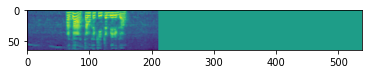

In [ ]:
plt.figure(figsize=(20, 5))
torch.autograd.set_detect_anomaly(False)
learning_rate = 0.5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.93, 0.9995),)
for epoch in range(100):
    learning_rate = learning_rate / 2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.93, 0.9995),)
    average_cer = AverageMeter()
    average_wer = AverageMeter()
    average_loss = AverageMeter()
    model.train()
    with Timer('epoch') as epoch_t:
        for i, batch in islice(enumerate(tqdm(train_dataloader)), 400):
            with Timer('iteration') as iteration_t:
                model.float()  # add this here
                x = batch['specs'].to(DEVICE)
                y = batch['labels'].to(DEVICE)
                x_lengths =  batch['specs length'].to(DEVICE)
                y_lengths =  batch['labels lengths'].to(DEVICE)
                
                log_probs =  F.log_softmax(model(x),dim=1) # N C T
                log_probs = log_probs.permute(2, 0, 1) # T N C
                loss = criterion(log_probs, y, x_lengths, y_lengths) 
            history['time_per_iter'].append(iteration_t.t)
            optimizer.zero_grad()
            loss.backward()
            model.float() # add this here

            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            if bool(torch.isnan(norm)):
                print("\n","*"*150)
                continue
            optimizer.step()

            argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

            train_cer, train_wer, pairs  = calculate_cer(y, argmax_decoding, y_lengths, x_lengths)
            average_cer.update(train_cer)
            average_wer.update(train_wer)
            average_loss.update(loss.item())
            history['loss'].append(average_loss.avg)
            history['cer'].append(average_cer.avg)
            history['wer'].append(average_wer.avg)
            print('Train cer=', train_cer)
            print('Train wer', train_wer)
            wandb.log({
            "loss": loss.item(),
            "cer": train_cer,
            "wer": train_wer,
            "norm": norm})
            if ( i  % 50 == 0 ):
                wandb.log({
                    "Audio train every n step": [wandb.Audio(batch['wavs'][0], caption="Audio with aug", sample_rate=16000)],
                    "Spec train ": [wandb.Image(plt.imshow(batch['specs'][0]), caption="Spec with aug")],
                    })

        history['time_per_epoch'].append(epoch_t.t)
    print('--'*100)


    validation_loss_meter = AverageMeter()
    val_average_cer = AverageMeter()
    val_average_wer = AverageMeter()
    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 100):
        x = batch['specs'].to(DEVICE)
        y = batch['labels'].to(DEVICE)
        x_lengths =  batch['specs length'].to(DEVICE)
        y_lengths =  batch['labels lengths'].to(DEVICE)
        with torch.no_grad():
                val_log_probs = F.log_softmax(model(x),dim=1)# N C T
                val_cer_beam, val_wer_beam, _ = calculate_cer_beam(y, beam_serch_eval(val_log_probs),y_lengths)
                print("\nVall cer (beam search)=", val_cer_beam)
                print("Vall wer (beam search) =", val_wer_beam)
                val_log_probs = val_log_probs.permute(2, 0, 1) # T N C
                val_loss = criterion(val_log_probs, y, x_lengths, y_lengths)
                argmax_decoding = val_log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)
                val_cer, val_wer, pairs  = calculate_cer(y, argmax_decoding, y_lengths, x_lengths)
                val_average_cer.update(val_cer)
                val_average_wer.update(val_wer)
                validation_loss_meter.update(val_loss.item())
        print("Vall cer (argmax)=", val_cer)
        print("Vall wer (argmax) =", val_wer)

        wandb.log({
            "val_loss": val_loss.item(),
            "val_cer": val_cer,
            "val_wer": val_wer})
        if ( i  % 10 == 0  ):
            wandb.log({
                "Audio valid every n step": [wandb.Audio(batch['wavs'][0], caption="Audio with aug", sample_rate=16000)],
                "Spec valid ": [wandb.Image(plt.imshow(batch['specs'][0]), caption="Spec with aug")]
                })
    display.clear_output()
    print(f'Epoch: {epoch}')

    
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten()
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    
    axes[2].plot(history['time_per_iter'], label='iter')
    axes[2].legend(); axes[2].grid()
    axes[3].plot(history['wer'], label='WER')
    axes[3].legend(); axes[3].grid()
    
    plt.show()

In [ ]:
list(model.parameters())

In [ ]:
for name, param in model.named_parameters():
    print(name, torch.max(abs(param.grad)).all())

In [ ]:
x

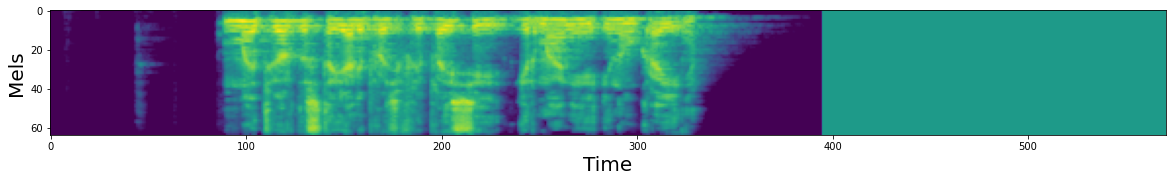

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(x[13].to("cpu").squeeze())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
(model(x))# N C T

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part2.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part3.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part3_then_golos1.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part4_plus_added_valid_datasetforeval.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part5_plus_added_valid_datasetforeval.pt') 23-24

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part6_plus_added_valid_datasetforeval.pt')  24 afternoon

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part7_plus_added_valid_datasetforeval.pt')  24 evening

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part8_plus_added_valid_datasetforeval.pt') night22:59

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part9_plus_aug_in_spec.pt')

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part10.pt')

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part10__added_Aadam.pt')

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part11__added_Aadam_lr_0_00005.pt')

In [ ]:
# torch.save(model.state_dict(),'/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part12__added_Aadam_lr_0_00005_del_to_every_2_iter.pt')

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Oct 25 20:34:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |   7079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 50):
        x = batch['specs'].to(DEVICE)
        y = batch['labels'].to(DEVICE)
        x_lengths =  batch['specs length'].to(DEVICE)
        y_lengths =  batch['labels lengths'].to(DEVICE)
        with torch.no_grad():
                val_log_probs = model(x) # N C T
                val_cer_beam, val_wer_beam, _ = calculate_cer_beam(y, beam_serch_eval(val_log_probs))
                print("\nVall cer (beam search)=", val_cer_beam)
                print("Vall wer (beam search) =", val_wer_beam)
                val_log_probs = val_log_probs.permute(2, 0, 1) # T N C
                val_loss = criterion(val_log_probs, y, x_lengths, y_lengths)
                argmax_decoding = val_log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)
                val_cer, val_wer, pairs  = calculate_cer(y, argmax_decoding, y_lengths, x_lengths)
                val_average_cer.update(val_cer)
                val_average_wer.update(val_wer)
                validation_loss_meter.update(val_loss.item())
        print("Vall cer (argmax)=", val_cer)
        print("Vall wer (argmax) =", val_wer)

  0%|          | 0/249 [00:06<?, ?it/s]


TypeError: ignored

## TEST

In [ ]:
TEST_DS = AudioMnistDataset(Main_path, path_to_csv_test)

In [ ]:
test_dataloader = DataLoader(
    TEST_DS, batch_size=80, shuffle=True,
    collate_fn=Collator(),
    num_workers=2, pin_memory=False, drop_last=True
)

In [ ]:
from collections import defaultdict
history = defaultdict(list)

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/AUDIO_DLA/asr_last_week/state_dict_model_commonvoice_part12__added_Aadam_lr_0_00005_del_to_every_2_iter.pt'))

<All keys matched successfully>

In [ ]:
    validation_loss_meter = AverageMeter()
    val_average_cer = AverageMeter()
    val_average_wer = AverageMeter()
    model.eval()
    for i, batch in islice(enumerate(tqdm(test_dataloader)), 150):
        x = batch['specs'].to(DEVICE)
        y = batch['labels'].to(DEVICE)
        x_lengths =  batch['specs length'].to(DEVICE)
        y_lengths =  batch['labels lengths'].to(DEVICE)
        with torch.no_grad():
                val_log_probs = F.log_softmax(model(x),dim=1)# N C T
                val_cer_beam, val_wer_beam, _ = calculate_cer_beam(y, beam_serch_eval(val_log_probs),y_lengths)
                print("\nVall cer (beam search)=", val_cer_beam)
                print("Vall wer (beam search) =", val_wer_beam)
                val_log_probs = val_log_probs.permute(2, 0, 1) # T N C
                val_loss = criterion(val_log_probs, y, x_lengths, y_lengths)
                argmax_decoding = val_log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)
                val_cer, val_wer, pairs  = calculate_cer(y, argmax_decoding, y_lengths, x_lengths)
                val_average_cer.update(val_cer)
                val_average_wer.update(val_wer)
                validation_loss_meter.update(val_loss.item())
                history['cer'].append(val_average_cer.avg)
                history['wer'].append(val_average_wer.avg)
        print("Vall cer (argmax)=", val_cer)
        print("Vall wer (argmax) =", val_wer)

  1%|          | 1/105 [00:11<19:59, 11.53s/it]


Vall cer (beam search)= 0.3330640817821794
Vall wer (beam search) = 0.8248576423576424

True:  колумбия готова и преисполнена решимости принять всестороннее участие в этом процессе 
 Predic:  колунби готова и присполнина решимости приняткся стороннемучастие  в этом процесси

True:  за океаны 
 Predic:  закин
Vall cer (argmax)= 0.2989644705542568
Vall wer (argmax) = 0.837431734931735


  2%|▏         | 2/105 [00:17<14:40,  8.55s/it]


Vall cer (beam search)= 0.3397034149279596
Vall wer (beam search) = 0.8347596153846155

True:  в конечном счете важен прогресс по существу проблемы 
 Predic:  в конечно сча т важем прорес послущество проблемы

True:  проблемы с которыми сталкиваются женщины в постконфликтных ситуациях поистине огромны 
 Predic:  проблемы с который ми сталковетя женщины посконкитктных ситуации поести не огромны
Vall cer (argmax)= 0.30351143633408756
Vall wer (argmax) = 0.8217574092574089


  3%|▎         | 3/105 [00:22<11:37,  6.84s/it]


Vall cer (beam search)= 0.34954923795629445
Vall wer (beam search) = 0.7789830308580308

True:  позвольте мне сказать о некоторых важных аспектах своего опыта как президента 
 Predic:  позлоти м сказато некоторых важны х остесо своего пытоко приидентх

True:  в пятницу обе стороны подтвердили свое стремление к достижению мира на основе переговоров 
 Predic:  этьн со босторно подтрделисву асторевления достижени мира насноеи переговоров
Vall cer (argmax)= 0.27423647804157164
Vall wer (argmax) = 0.7934564393939393


  4%|▍         | 4/105 [00:27<10:08,  6.03s/it]


Vall cer (beam search)= 0.27970774618157734
Vall wer (beam search) = 0.8155674533799534

True:  мы привержены им и решительно настроены на их утверждение 
 Predic:  мы приверженыем и решитця на настроенны на ихотвроржданния

True:  вот почему мы организовали серию консультаций как глобального так и регионального характера 
 Predic:  вакуточему моргани завалиселюконсулзтации крак голобольного токрегионально характера
Vall cer (argmax)= 0.2639874911226567
Vall wer (argmax) = 0.8203098290598291


  5%|▍         | 5/105 [00:32<09:17,  5.57s/it]


Vall cer (beam search)= 0.3158708563065965
Vall wer (beam search) = 0.8041571622821622

True:  генерал покачал головою с видом недоверчивости 
 Predic:  гинерал пукачела кголово сиво недавртчсти

True:  наша страна поддерживает щедрую поддержку оказанную нам некоторыми из наших партнеров 
 Predic:  наша страна поддерживает сче друю поддержку оказынныю нам некоторымиз наших варнеров
Vall cer (argmax)= 0.2897215991896278
Vall wer (argmax) = 0.825343996281496


  6%|▌         | 6/105 [00:37<08:43,  5.29s/it]


Vall cer (beam search)= 0.29897483308009487
Vall wer (beam search) = 0.8238991563991563

True:  две недели тому назад было получено кающееся письмо степана аркадьича к долли 
 Predic:  двлене терь этому назад былополученнакающеясе питсмонстипонаркалити чектарли

True:  опасно конечно опасно но риск как говорится 
 Predic:  апасно конечно опасно морискаговорить
Vall cer (argmax)= 0.27354290111366397
Vall wer (argmax) = 0.815473797036297


  7%|▋         | 7/105 [00:41<08:19,  5.10s/it]


Vall cer (beam search)= 0.313596689636434
Vall wer (beam search) = 0.791849678099678

True:  толя самая лучшая кандидатура 
 Predic:  толя самоушак диотора

True:  стороной тут является созывающая сторона которая и несет ответственность 
 Predic:  стороно этут является связывающе сторона каторые и иесе тответственость
Vall cer (argmax)= 0.26154393781384366
Vall wer (argmax) = 0.7687143065268065


  8%|▊         | 8/105 [00:46<08:03,  4.99s/it]


Vall cer (beam search)= 0.28545172592249485
Vall wer (beam search) = 0.7970128829503826

True:  рассчитываем что лига арабских государств предпримет соответствующие усилия 
 Predic:  рассчитыа что лига рабсих государст предпримять сответствующе усилия

True:  такая интеграция будет эффективно и поновому способствовать нынешней динамике в арабском мире 
 Predic:  о интограция бо эфоективна ни подоламы соспособсвя п ешне денламикиго аравбском би
Vall cer (argmax)= 0.2551081860882186
Vall wer (argmax) = 0.7801146076146075


  9%|▊         | 9/105 [00:51<07:47,  4.87s/it]


Vall cer (beam search)= 0.3644387403654942
Vall wer (beam search) = 0.8238682498057498

True:  сексуальные надругательства являются пожалуй наиболее бесчеловечным преступлением которое известно человечеству 
 Predic:  сексуальны на драваеть ства является пожалй на иболее бечловичьни пеступлени которые извезотеоеческа

True:  а черт 
 Predic:  ерт
Vall cer (argmax)= 0.2838966938800271
Vall wer (argmax) = 0.8446563159063158


 10%|▉         | 10/105 [00:56<07:42,  4.87s/it]


Vall cer (beam search)= 0.32811825949581674
Vall wer (beam search) = 0.8409852300477297

True:   жаль его хороший был офицер 
 Predic:  чар его хопоше быво фице

True:  первый комитет принял проект резолюции без голосования 
 Predic:  ервый комитет принял проект резолюции бе з голосований
Vall cer (argmax)= 0.2864026540413256
Vall wer (argmax) = 0.8319299103674098


 10%|█         | 11/105 [01:00<07:38,  4.87s/it]


Vall cer (beam search)= 0.29898482267918935
Vall wer (beam search) = 0.8120681748806742

True:  лесото готово сыграть свою роль в выполнении этого плана действий 
 Predic:  ресотакготово сеграть свою роль выполвени этого панодействий

True:  если терроризм угрожает тысячам людей то распространение ядерного оружия несет угрозу миллионам 
 Predic:  еслетероризмуброшать тысячим люде п распростанене ядерного оруже несет гроза меллиона
Vall cer (argmax)= 0.2823453490523294
Vall wer (argmax) = 0.8255667943167939


 11%|█▏        | 12/105 [01:05<07:33,  4.88s/it]


Vall cer (beam search)= 0.31869690556966146
Vall wer (beam search) = 0.7681009615384613

True:  сперва нам надо уточнить входит ли это в конце концов в состав работы конференции 
 Predic:  ваонда надо уточнить входекли это в конце конциов состав работы конференции

True:  слыхали мы эту песню много раз 
 Predic:  слыхали мы тупестнем ногораз
Vall cer (argmax)= 0.26869133082919605
Vall wer (argmax) = 0.8179040750915749


 12%|█▏        | 13/105 [01:10<07:25,  4.84s/it]


Vall cer (beam search)= 0.31686961644918893
Vall wer (beam search) = 0.8447930541680542

True:  а сейчас слово имеет представитель российской федерации 
 Predic:  асейчас слово имеет представитель рочиь кситеер

True:  урегулирование конфликта на ближнем востоке является как никогда актуальным 
 Predic:  егулирования коприктано ближне остватиявляются катни ко дороткпльном
Vall cer (argmax)= 0.2886871436031663
Vall wer (argmax) = 0.8429091394716393


 13%|█▎        | 14/105 [01:15<07:18,  4.82s/it]


Vall cer (beam search)= 0.3238033028152338
Vall wer (beam search) = 0.816444805194805

True:  неприемлемая политика двойных стандартов стала постоянным атрибутом тех держав которые открыто стремятся к гегемонии 
 Predic:  не приемвлемоя полити катвойьных стондартов стало постояннымотребутом текдержа которыйе открыто стримятся кеимани

True:  позиция канады по этому вопросу хорошо известна 
 Predic:  позиция корадый по этому вопрусу хорошуо известано
Vall cer (argmax)= 0.25966601565645653
Vall wer (argmax) = 0.8080139305139304


 14%|█▍        | 15/105 [01:19<07:08,  4.76s/it]


Vall cer (beam search)= 0.2933572080766036
Vall wer (beam search) = 0.781758553946054

True:  недавние исследования проводимые в нашей стране указывают на некоторые новые очаги инфицирования 
 Predic:  в гажны и вслетогаонен провотима в нашей стране указе лянаектоле новрочедим нестиова

True:  наша страна также принимала всестороннее участие в совместных научноисследовательских проектах 
 Predic:  наша страноа такче принимало с сторони участи в сов мнесных ночномо седосеских провеэктах
Vall cer (argmax)= 0.27708767498253706
Vall wer (argmax) = 0.80213643994894


 15%|█▌        | 16/105 [01:24<07:07,  4.81s/it]


Vall cer (beam search)= 0.2887134021643386
Vall wer (beam search) = 0.8258627483627485

True:  в настоящее время уставом предусмотрены только две категории членов 
 Predic:  насторесеявлемя ставо предусмотенны полько двекати гори тля

True:   ну прыгнули  прыгнули 
 Predic:  ну пргноли првигнули
Vall cer (argmax)= 0.2755365524176083
Vall wer (argmax) = 0.8511636627261627


 16%|█▌        | 17/105 [01:29<06:59,  4.76s/it]


Vall cer (beam search)= 0.29540537633146646
Vall wer (beam search) = 0.8404571470196469

True:  я призываю все государствачлены присоединиться к этим усилиям 
 Predic:  я призываю все госудаствачен ну прдсотдниться к тим усибя

True:  кознышев в сопровождении левина отправляется на рыбную ловлю 
 Predic:  коздмо шаею всто провоеждени леле откравляются нерлгн зовлю
Vall cer (argmax)= 0.28361971323970336
Vall wer (argmax) = 0.8527997696747697


 17%|█▋        | 18/105 [01:34<06:50,  4.72s/it]


Vall cer (beam search)= 0.2869391468871972
Vall wer (beam search) = 0.7924993756243756

True:  и мы настоятельно призываем их работать и дальше 
 Predic:  мв растоясел на призываем и хработат идальше

True:  мы настоятельно призываем тех кто этого еще не сделал внести взнос в целевой фонд 
 Predic:  мы настрятельно призываем тех ктор этогоюще не сделал внести в знос к целегой фонт
Vall cer (argmax)= 0.2632272404915918
Vall wer (argmax) = 0.8042614330114329


 18%|█▊        | 19/105 [01:38<06:46,  4.72s/it]


Vall cer (beam search)= 0.2932557623660613
Vall wer (beam search) = 0.7910067016317013

True:  лошади поскакали народ на улице останавливался и кланялся в пояс 
 Predic:  воша ди поскакали народ новлися останалиал ся иехквланялся в порес

True:  однажды удалось мне написать песенку которой был я доволен 
 Predic:  однато вудовожне на пте питзинко которы и пово я доволека
Vall cer (argmax)= 0.2705840979651849
Vall wer (argmax) = 0.8202877677877675


 19%|█▉        | 20/105 [01:43<06:42,  4.74s/it]


Vall cer (beam search)= 0.28785722779257295
Vall wer (beam search) = 0.7743859959484957

True:  активизированной конференции по разоружению не может быть без расширенной конференции по разоружению 
 Predic:  акти зированны конференции по разоружению не может быть безвраширенных конференции по разоружения

True:  мы заслушали всех кто хотел выступить по мотивам голосования до голосования 
 Predic:  вызаслушалит всех втохотелвысьтупеть помотем глосования доголосования
Vall cer (argmax)= 0.2619206545858982
Vall wer (argmax) = 0.786190164002664


 20%|██        | 21/105 [01:48<06:36,  4.72s/it]


Vall cer (beam search)= 0.2991407412416734
Vall wer (beam search) = 0.8285034063159061

True:  и даже эти правила применяются пока еще слишком редко 
 Predic:  и даже эти правилва применяются покаяющее вс лишком ретка

True:  тихий переулок милая вдова 
 Predic:  нхи пи еговык нилае дова
Vall cer (argmax)= 0.2774664960241323
Vall wer (argmax) = 0.821858558108558


 21%|██        | 22/105 [01:52<06:29,  4.69s/it]


Vall cer (beam search)= 0.301435549748326
Vall wer (beam search) = 0.8093929334554331

True:  они должны подводить нас к повышению темпов многостороннего разоружения а также к сокращению распространения 
 Predic:  онен должны подвудитсь ноасвопорушению там пот иногосторонего разоружению о такжет сяокращению распространение

True:  эти революции подтверждают всеобщие устремления к осуществлению прав человека 
 Predic:  эте революции подтврждаеют всеобщие устрамленияе косуществление прав человек
Vall cer (argmax)= 0.26315692793603895
Vall wer (argmax) = 0.8193651140526139


 22%|██▏       | 23/105 [01:57<06:24,  4.69s/it]


Vall cer (beam search)= 0.27613210056944343
Vall wer (beam search) = 0.7260233863358865

True:  я хочу сделать все как следует 
 Predic:  я хочу сделать все ка седует

True:  в этом контексте в договор о расщепляющемся материале нужно будет включить следующие элементы 
 Predic:  п этом конте всевдегувора орасшеляюшимся натереале роже бвыетвключитсья вседующлеэлименты
Vall cer (argmax)= 0.24811927490317892
Vall wer (argmax) = 0.7379072316572316


 23%|██▎       | 24/105 [02:02<06:24,  4.75s/it]


Vall cer (beam search)= 0.31706637819044864
Vall wer (beam search) = 0.7908475205350204

True:  издалека показался быстро приближающийся огонь 
 Predic:  изталита по азался быстропридлесавющихмсякор

True:  как я рада 
 Predic:  как ет
Vall cer (argmax)= 0.2860562404509539
Vall wer (argmax) = 0.8098943764568766


 24%|██▍       | 25/105 [02:07<06:19,  4.74s/it]


Vall cer (beam search)= 0.30343030541295324
Vall wer (beam search) = 0.791725878288378

True:  крайне необходимой считаем также мобилизацию достаточных предсказуемых своевременно предоставляемых и гибких ресурсов 
 Predic:  крак необходимно считаем полже но белизатии послатощни ре сказумы своревмеено достанвгляена и гепы ресурсов

True:  именно в этом контексте проводится наше сегодняшнее обсуждение 
 Predic:  именно в этом контексти проводитсея наше сегодняшне обсуждения
Vall cer (argmax)= 0.2663127585028557
Vall wer (argmax) = 0.7886567599067599


 25%|██▍       | 26/105 [02:11<06:08,  4.67s/it]


Vall cer (beam search)= 0.3066104238257787
Vall wer (beam search) = 0.7960422910422913

True:  надо еще и подгонять подбирать параметры какойто исходной теории 
 Predic:  надо йще поденять поддираь параме трукокут и сходной теореи

True:  оставаться нет необходимости 
 Predic:  оставаться нет необподимости
Vall cer (argmax)= 0.27121835673608896
Vall wer (argmax) = 0.8179443473193473


 26%|██▌       | 27/105 [02:16<06:06,  4.70s/it]


Vall cer (beam search)= 0.2857410033587837
Vall wer (beam search) = 0.7959465534465534

True:  основой наших действий является стремление добиться национального примирения 
 Predic:  основа нашим действи является страмление добися национально го применения

True:  для обеспечения доступа нам необходимы новые механизмы стимулирования исследований и разработок 
 Predic:  для обеспечение тоступолна необходимо новыйевех обизмостим улировамия и следовани и разработак
Vall cer (argmax)= 0.25014657397520773
Vall wer (argmax) = 0.8053018509268508


 27%|██▋       | 28/105 [02:21<06:03,  4.72s/it]


Vall cer (beam search)= 0.30726878928780504
Vall wer (beam search) = 0.872720820845821

True:  я благодарю членов конференции по разоружению и государстванаблюдатели которые участвовали в этом мероприятии 
 Predic:  я благодарит членов кунференци п разоружения государсто ну блюдателикатору често е вотьноые радвие

True:  мы глубоко разочарованы этой неудачей 
 Predic:  на глу бокразы чиролана эфи не мутаче
Vall cer (argmax)= 0.2971972542208028
Vall wer (argmax) = 0.8768596334221334


 28%|██▊       | 29/105 [02:25<05:58,  4.71s/it]


Vall cer (beam search)= 0.32014718341297044
Vall wer (beam search) = 0.75886824980575

True:  горькой правдой является то что молодежь и власть нередко плохо понимают друг друга 
 Predic:  бворто прадряивлается то что мылодежливлас нее каплахо понимает деудруга

True:  он положил ей букет на книгу 
 Predic:  о пожелае бык т нак нику
Vall cer (argmax)= 0.2676512357008062
Vall wer (argmax) = 0.7831826506826507


 29%|██▊       | 30/105 [02:30<05:58,  4.78s/it]


Vall cer (beam search)= 0.32423977384480596
Vall wer (beam search) = 0.7830568736818735

True:  почти вся оказываемая канадой помощь включая продовольственную помощь не обставлена никакими условиями 
 Predic:  почти всеокразнмы кана одыпомощлчае поноольтени понжк необставленна некакини условими

True:  нет  отвечал он  поздно мне каяться 
 Predic:  нетат ечам поздно мне кается
Vall cer (argmax)= 0.2652278202554085
Vall wer (argmax) = 0.7858892149517149


 30%|██▉       | 31/105 [02:35<05:55,  4.80s/it]


Vall cer (beam search)= 0.2923676038872503
Vall wer (beam search) = 0.7823561854811854

True:  это нелегкая тема 
 Predic:  это невекаятема

True:  я не могу уйти 
 Predic:  я не могудити
Vall cer (argmax)= 0.2661687372429039
Vall wer (argmax) = 0.7853762556887556


 30%|███       | 32/105 [02:40<05:57,  4.89s/it]


Vall cer (beam search)= 0.29495311157713533
Vall wer (beam search) = 0.7946740412365412

True:  программному комплексу совершенно не принципиально какая файловая система подключается к контейнеру 
 Predic:  програмно мопом приссоажена не принципняньна кака прьова система подкучатся каконтерймеру

True:  всего лучшего анна марковна 
 Predic:  сего лучшео анно маркуа
Vall cer (argmax)= 0.255571445608981
Vall wer (argmax) = 0.8074041583416586


 31%|███▏      | 33/105 [02:45<05:52,  4.89s/it]


Vall cer (beam search)= 0.3042018105390054
Vall wer (beam search) = 0.7988307178932176

True:  усиливается влияние механизмов привлечения к ответственности на усилия по посредничеству 
 Predic:  ус силивает сявближения миханизмов пявлючение кответствности но усилия попосредничество

True:  разоружение  это одна из самых жизненно важных задач организации объединенных наций 
 Predic:  разружение эподнаеи самух жизненно важных задач организации объединенных наций
Vall cer (argmax)= 0.26147337441713236
Vall wer (argmax) = 0.8148606948606949


 32%|███▏      | 34/105 [02:50<05:44,  4.85s/it]


Vall cer (beam search)= 0.3063819316299092
Vall wer (beam search) = 0.7907701673326671

True:   ну если бы еще мне было лет сорок или хотя бы тридцать 
 Predic:  ну есдри быещем не былолет срок и ле хотя бытрицеть

True:  поэтому туркменистан первостепенное значение придает урегулированию любых ситуаций мирными средствами и методами 
 Predic:  оэто торьк мине стан первостепенное значения предает уре унирова либы ситуаций мирныймие средств иметудами
Vall cer (argmax)= 0.25401223982299215
Vall wer (argmax) = 0.8032587204462205


 33%|███▎      | 35/105 [02:55<05:40,  4.87s/it]


Vall cer (beam search)= 0.29295882790556177
Vall wer (beam search) = 0.8193352133977129

True:  обладание оружием продиктовано законной заинтересованностью государств в обеспечении своей собственной безопасности 
 Predic:  обладания оружи подектовна законной заинтересовностю государств п обеспечени свои собтвенный безопасности

True:  нарушается международный правопорядок а своевольные и бесцеремонные действия некоторых стран порождают недоверие 
 Predic:  нырашается международно прав пряда свогорня иесимолисни пех стран прождаеют нетоивере
Vall cer (argmax)= 0.2679733260677115
Vall wer (argmax) = 0.8215636100011098


 34%|███▍      | 36/105 [03:00<05:38,  4.90s/it]


Vall cer (beam search)= 0.3472802637877494
Vall wer (beam search) = 0.8182709651459648

True:  сейчас я предоставляю слово представителю германии 
 Predic:  сейчас предоставляю слово представителю гиермания

True:  мы привержены этому делу однако речь идет разумеется о коллективной ответственности 
 Predic:  мы примержены этому дену ажнакоряде ис празумется а клактимоя опетсвенности
Vall cer (argmax)= 0.27355176787679575
Vall wer (argmax) = 0.8220626942501941


 35%|███▌      | 37/105 [03:04<05:23,  4.76s/it]


Vall cer (beam search)= 0.32646206385401366
Vall wer (beam search) = 0.8168418387168384

True:  для окончательного завершения разработки таких проектов требуется дополнительная и устойчивая поддержка 
 Predic:  для кончасеьно в завершение разработи таких проектостребуется топлнителрное и устойчивае поддержку

True:  в этой связи нас воодушевляет решение большинства неправительственных организаций продолжать участвовать в работе процесса 
 Predic:  в этойсвязино свадущевляет решения бльшинствани правителйственныхорганизации продолжать ейчаствовать в работе процесса
Vall cer (argmax)= 0.27811251186551755
Vall wer (argmax) = 0.8197344669219666


 36%|███▌      | 38/105 [03:09<05:21,  4.80s/it]


Vall cer (beam search)= 0.3113021205597425
Vall wer (beam search) = 0.8002414599289598

True:  тимур 
 Predic:  тимур

True:  полномочия представителей на шестьдесят пятой сессии генеральной ассамблеи 
 Predic:  полномучая представители ношеидесят этый сассили генеральный поссамблеи
Vall cer (argmax)= 0.2499160280728276
Vall wer (argmax) = 0.8130142773892771


 37%|███▋      | 39/105 [03:14<05:13,  4.76s/it]


Vall cer (beam search)= 0.31358231082713334
Vall wer (beam search) = 0.8173585095460092

True:  пусть джоуи пойдет с тобой 
 Predic:  унов и поьбе побыл

True:  у нас есть два основных пункта повестки дня 
 Predic:  насесьтевасналых ункты повес и га
Vall cer (argmax)= 0.28577819065719917
Vall wer (argmax) = 0.8238808066933062


 38%|███▊      | 40/105 [03:19<05:11,  4.79s/it]


Vall cer (beam search)= 0.33231766490811326
Vall wer (beam search) = 0.8173681179931179

True:  я подписала приказ о вашем назначении начальником отдела 
 Predic:  я подкисоо прикас оваошмн значения начени компдела

True:  эту позицию определяет ключевой принцип неделимости безопасности 
 Predic:  эту позиция приделяет крлючемо о принцитьныителимости безопасностьи
Vall cer (argmax)= 0.27653503117906125
Vall wer (argmax) = 0.8035919289044291


 39%|███▉      | 41/105 [03:24<05:08,  4.82s/it]


Vall cer (beam search)= 0.3122648388662311
Vall wer (beam search) = 0.8225978882228884

True:  вслед за арабской весной наступит и время арабского вызова 
 Predic:  свлет за рабскй несной настовлити время арабского вызова

True:  он отстаивал интересы инвалидов и молодежи 
 Predic:  о настаиво интересоиьаетов и нолодеше
Vall cer (argmax)= 0.2658495066133634
Vall wer (argmax) = 0.8371152805527805


 40%|████      | 42/105 [03:28<05:02,  4.81s/it]


Vall cer (beam search)= 0.31767579508015076
Vall wer (beam search) = 0.8281517787767785

True:  зима без трех подзимков не живет 
 Predic:  симаместеях подо  зимку в нижет по

True:  сейчас я предоставляю слово господину стуббу 
 Predic:  сейчас  я предоставлю стлоко госпадььнустому
Vall cer (argmax)= 0.2809864702810442
Vall wer (argmax) = 0.8234785353535351


 41%|████      | 43/105 [03:33<04:58,  4.82s/it]


Vall cer (beam search)= 0.3035271692079998
Vall wer (beam search) = 0.7854358141858142

True:  могу ли я считать что генеральная ассамблея намерена принять к сведению доклад шестого комитета 
 Predic:  буд я считать что генеральноя ассамблея на мерено принеть к сбегие доклочестого комитеу

True:  кризис в сомали является проблемой которой кения занимается в течение многих лет 
 Predic:  крзис в сомали является проблемы которые кение занимается в течениемногих лет
Vall cer (argmax)= 0.2637038928489489
Vall wer (argmax) = 0.7906426906426904


 42%|████▏     | 44/105 [03:38<04:54,  4.82s/it]


Vall cer (beam search)= 0.2959654148618228
Vall wer (beam search) = 0.8039073426573428

True:  япония также на протяжении ряда десятилетий твердо призывает к полной ликвидации ядерного оружия 
 Predic:  ипоня также но претежениерядрдисятиритит моэтопризывает ко полной дикитации недногоружия

True:  я надеюсь что более широкий форум конференции по разоружению будет способствовать повышению роли конференции 
 Predic:  я надеесь чтобоеешиюрокей форум конференциипогороазоруженю пуеть способтсвать повишению рогие конференции
Vall cer (argmax)= 0.26451884681027116
Vall wer (argmax) = 0.8081514665889665


 43%|████▎     | 45/105 [03:43<04:48,  4.81s/it]


Vall cer (beam search)= 0.3102116437919978
Vall wer (beam search) = 0.818440587190587

True:  такое положение дел представляется абсолютно сюрреалистичным безумным и неприемлемым 
 Predic:  такое положениидел представляется обсолитна сирелисстичным иу и непреемлема

True:  уровень безработицы среди женщин в египте в три раза выше чем среди мужчин 
 Predic:  оров ьбезоабоця средие жа нщим едикев триразовысе чем средимущим
Vall cer (argmax)= 0.27362074277593795
Vall wer (argmax) = 0.8187604062604061


 44%|████▍     | 46/105 [03:48<04:43,  4.80s/it]


Vall cer (beam search)= 0.2906874792204698
Vall wer (beam search) = 0.8017824536574534

True:  немножко терпкое но я 
 Predic:  не мнош потерка но я

True:  этот вопрос также обсуждался в ходе двух предыдущих циклов работы комиссии 
 Predic:  этот вопрос также обсуждался в ходит двух предущих циглов работы комссии
Vall cer (argmax)= 0.263739140845067
Vall wer (argmax) = 0.7974755452880451


 45%|████▍     | 47/105 [03:53<04:40,  4.84s/it]


Vall cer (beam search)= 0.27229628266958855
Vall wer (beam search) = 0.8205790737040738

True:  однако национальные усилия в этой связи должны быть поддержаны международным сообществом 
 Predic:  однаконациональна сили в эт й свяди далжны быть поддержнымежнародном сообщесква

True:  святой престол также обеспокоен событиями происходящими в некоторых странах северной африки и ближнего востока 
 Predic:  светое присталтакже оеспакон событими происходящеины некоторых страла всеврной африти и ближнем постока
Vall cer (argmax)= 0.25545402760940294
Vall wer (argmax) = 0.8461211011211007


 46%|████▌     | 48/105 [03:57<04:33,  4.80s/it]


Vall cer (beam search)= 0.28815354741252386
Vall wer (beam search) = 0.7946945068820068

True:  в них  слагаемые нашего общего успеха 
 Predic:  вних слогаемыи нашего общега успеха

True:  вот о чем спрашивал господин альбарадеи 
 Predic:  годточм спрашво гесподина и бораде
Vall cer (argmax)= 0.2579873611553547
Vall wer (argmax) = 0.8092850205350203


 47%|████▋     | 49/105 [04:02<04:27,  4.77s/it]


Vall cer (beam search)= 0.2806592753758702
Vall wer (beam search) = 0.8089585067710068

True:  демократия  это то чего они боятся больше всего 
 Predic:  демократве это точеване боятся больше сиего

True:  вот почему венесуэла решительно поддерживает глобальную контртеррористическую стратегию организации объединенных наций 
 Predic:  вот почеуо е несаего решительно поддерживат глобальную конпевтирронистическог стротию в организации объединегоснаций
Vall cer (argmax)= 0.259006437424238
Vall wer (argmax) = 0.7925031565656563


 48%|████▊     | 50/105 [04:07<04:22,  4.78s/it]


Vall cer (beam search)= 0.2832917727306842
Vall wer (beam search) = 0.7996338036963035

True:  опятьтаки мы можем изменить ситуацию 
 Predic:  опяот стаки мы можеме измеме сикуадю

True:  мы призываем все государства принять участие в работе этой конференции 
 Predic:  мы призываем все гошсударство принят участьи работее эт йэконференции
Vall cer (argmax)= 0.25910559488466983
Vall wer (argmax) = 0.8254350857475858


 49%|████▊     | 51/105 [04:12<04:17,  4.77s/it]


Vall cer (beam search)= 0.2697277601330637
Vall wer (beam search) = 0.8146402555777552

True:  ага вот записка 
 Predic:  ога от записка

True:  особую актуальность на современном этапе приобретает проблема обеспечения международной информационной безопасности 
 Predic:  особы актуальность на собременноны табо приопиаеть проблема обеспечения международныонацонныйх безопасности
Vall cer (argmax)= 0.24881400998782044
Vall wer (argmax) = 0.8206693306693307


 50%|████▉     | 52/105 [04:16<04:10,  4.72s/it]


Vall cer (beam search)= 0.3036072257413793
Vall wer (beam search) = 0.7867146395271396

True:  эти слова стали практически синонимами 
 Predic:  эти слова стали практически семо не моми

True:  считаем что пора предпринять дополнительные шаги включая и отмену бесполетной зоны 
 Predic:  считаек что пана препринят дыпалнител нешагив ключа ия отмнена госполетиязвны
Vall cer (argmax)= 0.27772324142052696
Vall wer (argmax) = 0.7903050074925073


 50%|█████     | 53/105 [04:21<04:07,  4.76s/it]


Vall cer (beam search)= 0.28093809193602526
Vall wer (beam search) = 0.7794067044067042

True:  он глубоко несчастлив поверь мне презирать его  грешно 
 Predic:  глулоконесчастрев поверо мня презиратьего грешно

True:  именно поэтому нам необходимо изменить политику во многих странах 
 Predic:  именно поэтому но необходимо измнит полити к вомогих страных
Vall cer (argmax)= 0.24701899186259818
Vall wer (argmax) = 0.7861205461205458


 51%|█████▏    | 54/105 [04:26<04:03,  4.78s/it]


Vall cer (beam search)= 0.29530298964433405
Vall wer (beam search) = 0.7581798409923408

True:  выступление премьерминистра соломоновых островов господина дэнни филипа 
 Predic:  ны ступренди прнениясваманахориолавнос и нодоитин

True:  а меня и во сне не проси не поеду 
 Predic:  обменя ивоснене пош не поеды
Vall cer (argmax)= 0.27398819514090933
Vall wer (argmax) = 0.7740745018870017


 52%|█████▏    | 55/105 [04:31<03:58,  4.78s/it]


Vall cer (beam search)= 0.2945358793033092
Vall wer (beam search) = 0.7854378607503607

True:  васька поклонился дамам и взглянул на них но только на одну секунду 
 Predic:  вас ка поколанилусядамом и взгляно на них но толькона о дносий кунду

True:  этот настрой отразила соответствующая резолюция принятая в прошлом году генеральной ассамблеей организации объединенных наций 
 Predic:  этотд настрой опрзивла соответствуюеще резолюция принятавпрошом годугенеральной ассамблеа организации объединонныхнаций
Vall cer (argmax)= 0.27299325891759085
Vall wer (argmax) = 0.8118412837162838


 53%|█████▎    | 56/105 [04:35<03:51,  4.72s/it]


Vall cer (beam search)= 0.2932336360772466
Vall wer (beam search) = 0.8099007936507936

True:  все кудато спешат все кудато опаздывают 
 Predic:  всегора пнаспешелт всегдодно опросноват

True:  китай и куба поддерживают нормальные экономические торговые отношения и способствуют контактам между людьми 
 Predic:  китайви кубу поддерживает корбарьной экономические тарговмое отношени испособствует коантактом междулазми
Vall cer (argmax)= 0.27540980830305994
Vall wer (argmax) = 0.8189324564324563


 54%|█████▍    | 57/105 [04:40<03:44,  4.68s/it]


Vall cer (beam search)= 0.30344079450805767
Vall wer (beam search) = 0.8419847513597514

True:  простота процесса выделения вычислительных мощностей пользователю 
 Predic:  тростетаопроцессоводеления воь чисвительнох нмочно се польоватл

True:  мы приветствуем публикацию этого доклада 
 Predic:  гыдрибут кодут требе тринат
Vall cer (argmax)= 0.2797197445997289
Vall wer (argmax) = 0.8342815864690862


 55%|█████▌    | 58/105 [04:45<03:41,  4.72s/it]


Vall cer (beam search)= 0.3190781690821648
Vall wer (beam search) = 0.8926159604284603

True:  так давайте же будем дерзкими в наших мечтах и смелыми в наших действиях 
 Predic:  когдовайте же будем дескимы наших меьчтах и смелание в нашиех действиях

True:  предпринимаемые некоторыми попытки возвращения утраченной имперской славы путем злоупотребления полномочиями совета многим представляются отвратительными 
 Predic:  препримаемо некоторный по пыттив озващение отраченем пердспесиавы поутем употремент о ногоким совета ногинмпреиставлятся отвратителными
Vall cer (argmax)= 0.30268664493755204
Vall wer (argmax) = 0.8796953393828394


 56%|█████▌    | 59/105 [04:49<03:37,  4.74s/it]


Vall cer (beam search)= 0.32911134488362187
Vall wer (beam search) = 0.7970804542679542

True:  армения камерун китай демократическая республика конго сальвадор индия пакистан самоа тонга уганда 
 Predic:  ормени комерун кита немопкратическо республика кон га целеводор и инди пакистансамоа тонгагванды

True:  один чемодан на улице 
 Predic:  один чемо данно вулисе
Vall cer (argmax)= 0.2827514430206141
Vall wer (argmax) = 0.7936319583194582


 57%|█████▋    | 60/105 [04:54<03:33,  4.74s/it]


Vall cer (beam search)= 0.2919847984408991
Vall wer (beam search) = 0.7735093378843377

True:  я пустился в город без милосердия пришпоривая бедного моего коня 
 Predic:  я пустилсе в горот бизмулас серде пришпориваетбедного моегоканя

True:  эту мрачную главу нашей истории мы никогда не должны забывать 
 Predic:  этом рашою глобл нашей стори мо никодани дожны забывать
Vall cer (argmax)= 0.25746427890769125
Vall wer (argmax) = 0.7849025627150625


 58%|█████▊    | 61/105 [04:59<03:31,  4.80s/it]


Vall cer (beam search)= 0.32357849658758486
Vall wer (beam search) = 0.814829129204129

True:  переговоры в генеральной ассамблее были неожиданно прерваны в марте этого года 
 Predic:  переговоры генерально самблии пыненеожедана прерводы мартие этого года

True:  это же дело выеденного яйца не стоит 
 Predic:  это жедемло выеденого ейцане спожит
Vall cer (argmax)= 0.27310131472518917
Vall wer (argmax) = 0.8110875235875235


 59%|█████▉    | 62/105 [05:04<03:23,  4.72s/it]


Vall cer (beam search)= 0.29950111595379036
Vall wer (beam search) = 0.7834040612165614

True:  хвалю халву 
 Predic:  хвалю халго

True:  однако времени у нас немного и я считаю что полезнее будет выслушать государствачлены 
 Predic:  однако времене нас немног я счита чтоп полезне бодет во слушать государствачлены
Vall cer (argmax)= 0.25320957366165187
Vall wer (argmax) = 0.7793678543678544


 60%|██████    | 63/105 [05:08<03:18,  4.73s/it]


Vall cer (beam search)= 0.33623394238450877
Vall wer (beam search) = 0.793583916083916

True:  признать такую ситуацию нормальной мы не можем 
 Predic:  признать такуситуацсу нормаьине мы не можн

True:  я соображаю о ком вы говорите 
 Predic:  я саображаю аконногонорит
Vall cer (argmax)= 0.28822352773199855
Vall wer (argmax) = 0.8190982281607282


 61%|██████    | 64/105 [05:13<03:17,  4.81s/it]


Vall cer (beam search)= 0.3568629061263828
Vall wer (beam search) = 0.815568598068598

True:  такая светленькая с косой 
 Predic:  такаясет нкискасоь

True:  это к тому же один из важнейших элементов собственно режима нераспространения 
 Predic:  это томо жаедини з важне юсих олементов собстван режимонераспространения
Vall cer (argmax)= 0.274920152860012
Vall wer (argmax) = 0.8049143564768565


 62%|██████▏   | 65/105 [05:18<03:09,  4.74s/it]


Vall cer (beam search)= 0.30673051116644395
Vall wer (beam search) = 0.7903471528471526

True:  надеюсь что он обращается с этой просьбой в порядке проявления поддержки в мой адрес 
 Predic:  мы дее что мныбращась соты посьтрйт в пореки проявленя поддержких моатес

True:  дело в том что милитаризация космического пространства вызывает озабоченности по причине соответствующих крупных рисков 
 Predic:  дены чтом что би е призации космическогоу предстранство вызоврает зобоаченностю повещений соответствующих крутныхричса
Vall cer (argmax)= 0.2711172674108976
Vall wer (argmax) = 0.8030745643245641


 63%|██████▎   | 66/105 [05:23<03:05,  4.76s/it]


Vall cer (beam search)= 0.31028230281206143
Vall wer (beam search) = 0.8198205613830611

True:  не лучше полицейских или чернопегих 
 Predic:  я вучше полицеских лечеоно прегих

True:  мы также заявляем что суверенитет проистекает из воли народа 
 Predic:  выл также заявлале стосулелиникент проиститай изволе народе
Vall cer (argmax)= 0.27775067154626887
Vall wer (argmax) = 0.8224734293484289


 64%|██████▍   | 67/105 [05:28<03:02,  4.81s/it]


Vall cer (beam search)= 0.31630012244668937
Vall wer (beam search) = 0.8191856754356751

True:  черные с желтым отливом глаза его осторожно шмыгали по комнате наблюдая господ 
 Predic:  чердны желтомо тин глазнаегос торожношмы клрепокон людай гоасту

True:  мы должны учитывать взаимозависимость трех аспектов устойчивого развития социального экономического и экологического 
 Predic:  мы должны учиттывать заимо зависилмност крехоспектов ускойчивог разви соцальноо  экономического и экологическа
Vall cer (argmax)= 0.26910100824002414
Vall wer (argmax) = 0.8254352244977244


 65%|██████▍   | 68/105 [05:32<02:58,  4.82s/it]


Vall cer (beam search)= 0.2759399267147638
Vall wer (beam search) = 0.7946796259296256

True:  и у нас все еще нет обязательного соглашения 
 Predic:  и унас все ещене побиязательногос соглашения

True:  и как раз в этом контексте конференция и имеет особую роль и ответственность 
 Predic:  и кок расмв этом контексти конференциии и мею особоюр роль и ответсененност
Vall cer (argmax)= 0.25529002892814795
Vall wer (argmax) = 0.8007086316461315


 66%|██████▌   | 69/105 [05:37<02:48,  4.69s/it]


Vall cer (beam search)= 0.3128539873994791
Vall wer (beam search) = 0.8159112068487067

True:  они помчались за ним вдогонку громко спрашивая нет ли у него спичек 
 Predic:  они помчалеиь за ним догорку громко спрашига ет ливне успечетк

True:  я считаю что все государства во всем мире могут достичь аналогичных результатов 
 Predic:  я считаю чо все го сударсв во всем нир мого достичеконугоничных зуьатов
Vall cer (argmax)= 0.27643213980413284
Vall wer (argmax) = 0.8398324245199245


 67%|██████▋   | 70/105 [05:41<02:43,  4.66s/it]


Vall cer (beam search)= 0.2742049244878166
Vall wer (beam search) = 0.8113906926406926

True:  международное сообщество не может обуславливать свои превентивные действия фактическим вооруженным насилием между братскими странами 
 Predic:  междуародное собщество не может обысавляватьсяои бринективне дести патическим руженнна сили между быроцскоми страннами

True:  статистика которую мы слышали в течение всей недели подтверждает это но сохраняются серьезные проблемы 
 Predic:  с татистека котороемы слышлетечение все недел потверждает ето носохранятсяусерьезный проблемы
Vall cer (argmax)= 0.25289972770046837
Vall wer (argmax) = 0.8128445165945166


 68%|██████▊   | 71/105 [05:46<02:39,  4.69s/it]


Vall cer (beam search)= 0.29890413210630523
Vall wer (beam search) = 0.7756641622266622

True:  мы подготовили необходимые документы досье бумаги и наши предложения 
 Predic:  мы подкготовирле необходимо документы в досиея длуманки и наше предложения

True:  текущая сессия взяла многообещающее начало 
 Predic:  тикущая сесевзела нагдовющающе начала
Vall cer (argmax)= 0.25348111131508866
Vall wer (argmax) = 0.7587122946497942


 69%|██████▊   | 72/105 [05:51<02:32,  4.63s/it]


Vall cer (beam search)= 0.28803914948834486
Vall wer (beam search) = 0.8122815379065376

True:  необходимо проводить различие между борьбой с терроризмом и нераспространением 
 Predic:  необходимо проводить различи между борьболстер ролизмом и неаспространением

True:  палестинцы имеют право знать в чем состоит территориальная основа их государства 
 Predic:  палестинця имет право знать в чомсостает еретеральноя основоех государства
Vall cer (argmax)= 0.2771453368199268
Vall wer (argmax) = 0.8381930222555223


 70%|██████▉   | 73/105 [05:55<02:29,  4.68s/it]


Vall cer (beam search)= 0.2716620352557399
Vall wer (beam search) = 0.7982163322788322

True:  время действовать пришло 
 Predic:  вре дествительно высло

True:  мы как и прежде благодарны кубинскому правительству за предлагаемую помощь 
 Predic:  но кэтой прежде блгедарьны кубинскогмоу правительству за предлагаем помоь
Vall cer (argmax)= 0.25553757498612295
Vall wer (argmax) = 0.8025420412920411


 70%|███████   | 74/105 [06:00<02:27,  4.75s/it]


Vall cer (beam search)= 0.28898583630616487
Vall wer (beam search) = 0.81730738011988

True:  мы благодарны за поддержку которую получили и вновь благодарим всех за оказанную помощь 
 Predic:  мы благодарнае за поддержку попороу получивие и внов благодарин всев за оказанно пома

True:  сергей иванович не телеграфировал брату чтобы высылать за ним 
 Predic:  сене ванычнытрегроферовал грату что высолзанию
Vall cer (argmax)= 0.24947322534428285
Vall wer (argmax) = 0.8165832778332778


 71%|███████▏  | 75/105 [06:05<02:23,  4.79s/it]


Vall cer (beam search)= 0.29912581130391813
Vall wer (beam search) = 0.8128585303585301

True:  качество издания радует  плотная бумага хорошая четкая печать 
 Predic:  качуство и здане радут от нрбомага хорошле четкриичет

True:  эта идея отражена в представленных нам сегодня проектах резолюций за что мы благодарны 
 Predic:  это дел отржна пиставныет кам сегодя продит резолюций  чтомы благодатны
Vall cer (argmax)= 0.25980117793152135
Vall wer (argmax) = 0.8174672549672544


 72%|███████▏  | 76/105 [06:10<02:17,  4.75s/it]


Vall cer (beam search)= 0.27673736317783026
Vall wer (beam search) = 0.8089632589632586

True:  не все стриги что растет 
 Predic:  не все стрыги что расте

True:  это никоим образом не означает что мы игнорируем усилия прилагавшиеся египтом в этот период 
 Predic:  этоа никоюе б образовм не означает чтомы и гнорируем усилия прелагавшися зидиптом пов этот переи
Vall cer (argmax)= 0.2603869558663977
Vall wer (argmax) = 0.8045756673881673


 73%|███████▎  | 77/105 [06:15<02:12,  4.73s/it]


Vall cer (beam search)= 0.3008047382804766
Vall wer (beam search) = 0.8149634046509047

True:  бутылку вина 
 Predic:  воты кулина

True:  я искренне признательна генеральному секретарю за эту инициативу 
 Predic:  ярйскои не признательные генеральноу секретаре за этонициатсило
Vall cer (argmax)= 0.2607799237278895
Vall wer (argmax) = 0.8104887473637474


 74%|███████▍  | 78/105 [06:19<02:08,  4.76s/it]


Vall cer (beam search)= 0.2775052159893647
Vall wer (beam search) = 0.7714100135975134

True:  я благодарю делегатов за их усердие и сотрудничество 
 Predic:  я благодю делегат ов с их вусербе и сотруднчествоа

True:  бангладеш присоединяется к заявлению с которым выступил представитель индонезии от имени стран движения неприсоединения 
 Predic:  мобогодаш по садиняется к заявлению с которо гуспивол представителянподазини отоминиста арижане ие присоедимемие
Vall cer (argmax)= 0.2563612820126274
Vall wer (argmax) = 0.8051894633144631


 75%|███████▌  | 79/105 [06:24<02:03,  4.76s/it]


Vall cer (beam search)= 0.28239247923088184
Vall wer (beam search) = 0.7846218364968365

True:  эта авария нанесла японии и ее народу громадный ущерб 
 Predic:  это варена не смодякпони и ие внаролу драмадные  уще

True:  я никогда ни с кем не говорил об этом 
 Predic:  у мникодарвмискенидовориллагоцем
Vall cer (argmax)= 0.25046438683101824
Vall wer (argmax) = 0.7724867840492837


 76%|███████▌  | 80/105 [06:29<01:59,  4.76s/it]


Vall cer (beam search)= 0.28505303034659535
Vall wer (beam search) = 0.8180362345987346

True:  при оказании гуманитарной помощи израиль руководствуется всеобъемлющим подходом 
 Predic:  роказани гомнитарн помощи израилт руководствустце все объемующим подходам

True:  примите господин министр уверение в совершеннейшем к вам почтении 
 Predic:  примите госпоти мении сторувления севершенийшим кламп обестени
Vall cer (argmax)= 0.25474451430953776
Vall wer (argmax) = 0.8255360958485956


 77%|███████▋  | 81/105 [06:34<01:55,  4.83s/it]


Vall cer (beam search)= 0.3198256505807583
Vall wer (beam search) = 0.8140472027972028

True:  поэтому мы считаем что главное в данном процессе  это проверка на благонадежность 
 Predic:  поэтому мы считае что гыламная данном процессти это проверка на погоа надежнность

True:  мы надеемся на усиление сотрудничества с программой организации объединенных наций касающейся молодежи 
 Predic:  мы надеемся нанаселение сотрудничества страглраммаю организацииобъединенны наций косающиесяногодежи
Vall cer (argmax)= 0.2878724096042958
Vall wer (argmax) = 0.827759185259185


 78%|███████▊  | 82/105 [06:38<01:48,  4.73s/it]


Vall cer (beam search)= 0.2976765403676523
Vall wer (beam search) = 0.7794137806637804

True:  однако при этом гвинея придает большое значение необходимости позитивного урегулирования братоубийственного конфликта в сомали 
 Predic:  однакоперяпредмвене обрядают польщесчененеобходимости оиьсагядговурегулиода ниеброатоо нийстие неокомфикт осомали

True:  мороз и железо рвет и на лету птицу бьет 
 Predic:  марос ижеле зоралют и н риту птихсублета
Vall cer (argmax)= 0.25611417567134986
Vall wer (argmax) = 0.7880180930180927


 79%|███████▉  | 83/105 [06:43<01:43,  4.71s/it]


Vall cer (beam search)= 0.2681249989200137
Vall wer (beam search) = 0.8069969960594963

True:  вы так смотрите вы подозреваете что это я приволок этот веник 
 Predic:  вы ток смотрете мы подозриеваете что это я приволо к этотленик

True:  мы готовы обсудить эту идею с заинтересованными сторонами 
 Predic:  гото а обсу деть это хиде изаинти висованнымистороннами
Vall cer (argmax)= 0.264448292491434
Vall wer (argmax) = 0.8218765956265954


 80%|████████  | 84/105 [06:48<01:40,  4.77s/it]


Vall cer (beam search)= 0.30157212348625884
Vall wer (beam search) = 0.8296851412476413

True:  как насчет верности тем кто погиб 
 Predic:  как начеотверности тем ктопозип

True:  он принял спящего джентльмена за колю а седой джентльмен конечно принял его за жулика 
 Predic:  он принялуспеящиво тентрумену заколил асидо че трме коешна приняеголазжилика
Vall cer (argmax)= 0.2784047821636429
Vall wer (argmax) = 0.8193855103230104


 81%|████████  | 85/105 [06:53<01:35,  4.77s/it]


Vall cer (beam search)= 0.2934612598432642
Vall wer (beam search) = 0.8495686951936949

True:  а ты должен вживаться в ту или иную эпоху 
 Predic:  это должен джрваться тв тоыли знупоу

True:  самым важным событием в жизни нашей страны стал начавшийся в июле переходный процесс 
 Predic:  самым важным собыием жизни нашей страны сталнначаши ся ы ели переходый процерсс
Vall cer (argmax)= 0.27608414802065545
Vall wer (argmax) = 0.8540888972138969


 82%|████████▏ | 86/105 [06:57<01:29,  4.72s/it]


Vall cer (beam search)= 0.28632073287187976
Vall wer (beam search) = 0.7949029095904097

True:   мать у меня в горах в тайге очень далеко братья в армии сестер нет 
 Predic:  мы теме гарах вто ги очень далеко насеварми сестье в нет

True:   я спал 
 Predic:  я стал
Vall cer (argmax)= 0.26862312626596213
Vall wer (argmax) = 0.8067416611166609


 83%|████████▎ | 87/105 [07:02<01:25,  4.75s/it]


Vall cer (beam search)= 0.31552130525913213
Vall wer (beam search) = 0.7716459928959926

True:  оба приятеля удалились 
 Predic:  опа приятеля удолилелсь

True:  человек безусловно имеет право сопротивляться внушению когда его пытаются подчинить этим путем 
 Predic:  челорен безусловный имеет трано сопраеглятьс в нашению когда его пытается починит этим бытем
Vall cer (argmax)= 0.2700946155769635
Vall wer (argmax) = 0.7721984265734262


 84%|████████▍ | 88/105 [07:07<01:21,  4.77s/it]


Vall cer (beam search)= 0.2675337017455295
Vall wer (beam search) = 0.8231218781218779

True:  лицо ее было тревожно но в то же время выражало решимость 
 Predic:  лицовя было тереможно на втожевримя ыражал решимость

True:  мы полностью поддерживаем эти мероприятия и продолжаем вносить свой вклад в этот процесс 
 Predic:  ма полность поддержим этивное приятиия и продолжаюм у насисвыю вклад вв этот процесс
Vall cer (argmax)= 0.25413035539363216
Vall wer (argmax) = 0.8178036199911201


 85%|████████▍ | 89/105 [07:12<01:16,  4.78s/it]


Vall cer (beam search)= 0.2856462161738883
Vall wer (beam search) = 0.782401313963814

True:  сирийские власти должны незамедлительно обеспечить полный и беспрепятственный доступ для доставки международной гуманитарной помощи 
 Predic:  сирийские власы должны езаметьлитьдено обеспечит полнои босприпятственныо доступдля доставки международно малитарноый пщ

True:  причем это должны быть рабочие места не только для мужчин 
 Predic:  печм это должны быть рабочень мистане только длямуще
Vall cer (argmax)= 0.25845148857562694
Vall wer (argmax) = 0.7933681249306248


 86%|████████▌ | 90/105 [07:17<01:11,  4.77s/it]


Vall cer (beam search)= 0.2890990357623576
Vall wer (beam search) = 0.8536089257964259

True:  без этого невозможно будет эффективно решать проблемы стоящие перед международным сообществом 
 Predic:  безяэтогони восможно будет эч ективнырьшеь проблемы стеящий перед нежтдународум соообщество

True:  контроль во всех его аспектах включая роль организации объединенных наций в области контроля 
 Predic:  онпроль во всех ево спектновключа роль организации объединенных ндаций в обласи конфрое
Vall cer (argmax)= 0.27404282934065705
Vall wer (argmax) = 0.8596008505383506


 87%|████████▋ | 91/105 [07:21<01:05,  4.67s/it]


Vall cer (beam search)= 0.2788669345015905
Vall wer (beam search) = 0.8061258186258187

True:  как гений чистой красоты 
 Predic:  кондени чистойь кросопроий

True:  не хохо а трудолюбивым работником 
 Predic:  нехухо оторыйбурегило м работико
Vall cer (argmax)= 0.2596440447223056
Vall wer (argmax) = 0.8239503205128201


 88%|████████▊ | 92/105 [07:26<01:00,  4.63s/it]


Vall cer (beam search)= 0.29458148175084026
Vall wer (beam search) = 0.7935658785658785

True:  мы должны создать условия благоприятствующие политическому урегулированию и политическому диалогу который должен начаться незамедлительно 
 Predic:  ны тоснесоздать условие нагоприряатьствлущи политическогму уле улирони иполитическом ндиалову потой долженначаться незамедетельно

True:  однако ее политика нацеленная на то чтобы монополизировать ядерное оружие остается неизменной 
 Predic:  однак я поетика нацелнне на то чтобы мыдо пеезироватьетятдел но оружеям простоетя неизменны
Vall cer (argmax)= 0.27196728309124174
Vall wer (argmax) = 0.8036908924408921


 89%|████████▊ | 93/105 [07:30<00:55,  4.64s/it]


Vall cer (beam search)= 0.2837295516175855
Vall wer (beam search) = 0.8008925796425794

True:  в начале текущего года там свершился целый ряд революций 
 Predic:  адти ущей гокоратам свершвлся  целывйряд реваниси

True:  специальный посланник игнорирует официальные позиции ливанского правительства которое отрицает его заявления 
 Predic:  тони посла никои нарируетофвцарьный позицвилреванскопроевство которыя отрицает его заявление
Vall cer (argmax)= 0.26143583903632367
Vall wer (argmax) = 0.8224751984126986


 90%|████████▉ | 94/105 [07:35<00:51,  4.70s/it]


Vall cer (beam search)= 0.2980266941726569
Vall wer (beam search) = 0.8114859099234097

True:  решения принятые советом безопасности в этой связи не содействуют решению проблемы 
 Predic:  решение принятые совета безопасност в этой слядиение содействают решению проблемы

True:  я убеждена что под их умелым руководством мы проведем плодотворные обсуждения 
 Predic:  я убеждено что бы дых умел мы ководствнмыпрвгем бл гослорные обсуждение
Vall cer (argmax)= 0.26847120546955144
Vall wer (argmax) = 0.8012031718281719


 90%|█████████ | 95/105 [07:40<00:47,  4.70s/it]


Vall cer (beam search)= 0.3097918428220044
Vall wer (beam search) = 0.840413024475524

True:  большую активность в активизации руководящей роли стран подчеркнули мы необходимо проявлять гражданскому обществу 
 Predic:  больше октивностронфевации ро ководяжневнали стран потермулима необходимо появляль бажеданског общества

True:  украина не исключение 
 Predic:  украйимане исключене
Vall cer (argmax)= 0.2632494720209856
Vall wer (argmax) = 0.8203928710178706


 91%|█████████▏| 96/105 [07:44<00:41,  4.61s/it]


Vall cer (beam search)= 0.285530205508561
Vall wer (beam search) = 0.8100641025641024

True:  кто любит земле кланяться  без добычи не останется 
 Predic:  ктоле бсемле кланися бесдобоче нея стависи

True:  некоторые расплачиваются за это своими жизнями 
 Predic:  никоторы р сплочиватся зает свими жизни
Vall cer (argmax)= 0.25849716730047106
Vall wer (argmax) = 0.8084510975135976


 92%|█████████▏| 97/105 [07:49<00:36,  4.59s/it]


Vall cer (beam search)= 0.3080948235007454
Vall wer (beam search) = 0.7766091894216893

True:  время между нажатием клавиши на клиентском устройстве и отображением результата нажатия 
 Predic:  време межтду нажать еиовкаврешинокренскво кустроьвтве и тображению в резуктоаттанажатьия

True:  достижению поставленных задач в области развития могут способствовать также международная торговля и прямые инвестиции 
 Predic:  до сиреане посальных садачиву пусть развитим о стососвть таке междуномное торговля и прям инмстиции
Vall cer (argmax)= 0.2639077219998374
Vall wer (argmax) = 0.8071458055833054


 93%|█████████▎| 98/105 [07:53<00:32,  4.65s/it]


Vall cer (beam search)= 0.28243660891005257
Vall wer (beam search) = 0.7655277708402708

True:  рассчитываем на скорейшее начало предметной работы над российскокитайским проектом 
 Predic:  росситемв наскрыше начало примнетый работау натрофискамкиетайским проект

True:  международное сообщество должным образом признало и одобрило перемены происходящие в мьянме 
 Predic:  международное сообщества должны м образом признава дя добре пелеменный присхедаще мнямия
Vall cer (argmax)= 0.2366688364417179
Vall wer (argmax) = 0.7978097943722943


 94%|█████████▍| 99/105 [07:58<00:28,  4.72s/it]


Vall cer (beam search)= 0.3127854778268815
Vall wer (beam search) = 0.8142559176934178

True:  недопустимо чтобы как все эти годы нас водили за нос одними обещаниями 
 Predic:  негдопостимо чтобы как серэти году на сводилисанция неби оещани

True:  против вредоносных программ использующих такие векторы атаки невозможно защититься 
 Predic:  потьвуедо носны окра исподзующих в такивекторытаки ьну возможны сщице
Vall cer (argmax)= 0.2868645721705304
Vall wer (argmax) = 0.8276199148074147


 95%|█████████▌| 100/105 [08:03<00:23,  4.70s/it]


Vall cer (beam search)= 0.3181144469406003
Vall wer (beam search) = 0.81328484015984

True:  мы имеем достаточное количество ресурсов чтобы обеспечить основу для экономического роста 
 Predic:  мы имеем достаточна крличито ресуросо что бы обеспечиты основу пре экрномического растом

True:  под головой у жени лежала теперь мягкая кожаная подушка 
 Predic:  о гловой ужене лежалать перьмягкай коженая подушка
Vall cer (argmax)= 0.28378756746842543
Vall wer (argmax) = 0.8323243423243423


 96%|█████████▌| 101/105 [08:08<00:18,  4.72s/it]


Vall cer (beam search)= 0.29735846793284904
Vall wer (beam search) = 0.8304592282717278

True:  но оля  я с тобой не разговариваю 
 Predic:  ноу коно  стобой не разгиваре

True:  господин председатель я хотел бы поблагодарить вас за оказанное мне доверие в этой связи 
 Predic:  гы сползинм преседатеель вия о хотелбы поблагодарить воазако вазные мледо верияваэто связи
Vall cer (argmax)= 0.28004336065565777
Vall wer (argmax) = 0.856038059163059


 97%|█████████▋| 102/105 [08:11<00:12,  4.29s/it]


Vall cer (beam search)= 0.301242625199275
Vall wer (beam search) = 0.8440749181374179

True:  но как же это ломать не зная даже почему 
 Predic:  мукак жетоламочь не зна доже плчем

True:  когда пришло это сообщение в центре управления началась лихорадка 
 Predic:  кокда пришлов еэто сообщения в сентвупрблениму чиеласих хараноам
Vall cer (argmax)= 0.2758833162714014
Vall wer (argmax) = 0.8289332889332887


 98%|█████████▊| 103/105 [08:15<00:08,  4.04s/it]


Vall cer (beam search)= 0.29778139132853476
Vall wer (beam search) = 0.783978105228105

True:  кроме того сам израиль также еще не присоединился к конвенции 
 Predic:  краме того самы ризраиелть также рещение присет динилсоркте конвемаци

True:  наконец я хочу повторить что моя дверь открыта для всех вас 
 Predic:  накометя хотул ор чтомаятьврт бинадля всех вас
Vall cer (argmax)= 0.26147471168136105
Vall wer (argmax) = 0.7881398115773112


 99%|█████████▉| 104/105 [08:18<00:03,  3.81s/it]


Vall cer (beam search)= 0.2868576600589769
Vall wer (beam search) = 0.8017074592074593

True:  эти реформы осуществлялись и осуществляются многими развивающимися странами включая мою страну 
 Predic:  эте реформы посущесв лялис свиесущствляетсяоноймеравимвающимгсостраави мечамы истрову

True:   будь спокоен  отряхиваясь от раздумья сказала тимуру ольга 
 Predic:  буотд спокоем отряежимасетраздуме сказала тигуру ольгка
Vall cer (argmax)= 0.2548973200670239
Vall wer (argmax) = 0.7886370226995227


100%|██████████| 105/105 [08:21<00:00,  4.78s/it]


Vall cer (beam search)= 0.3066326886072154
Vall wer (beam search) = 0.8370520451770453

True:  чтобы продвинуть нашу работу мы будем говорить поанглийски  это красивый язык 
 Predic:  так чтобы продлниать наше работу будем говритьи панлиски это касивыизы

True:  не использование или менее чем оптимальное использование этого потенциала может сдерживать прогресс общества 
 Predic:  неспользовани иименечим оптимальной спользовани этго поточиа можен сздевать прогле спобщества
Vall cer (argmax)= 0.27332236245971875
Vall wer (argmax) = 0.8311885683760682


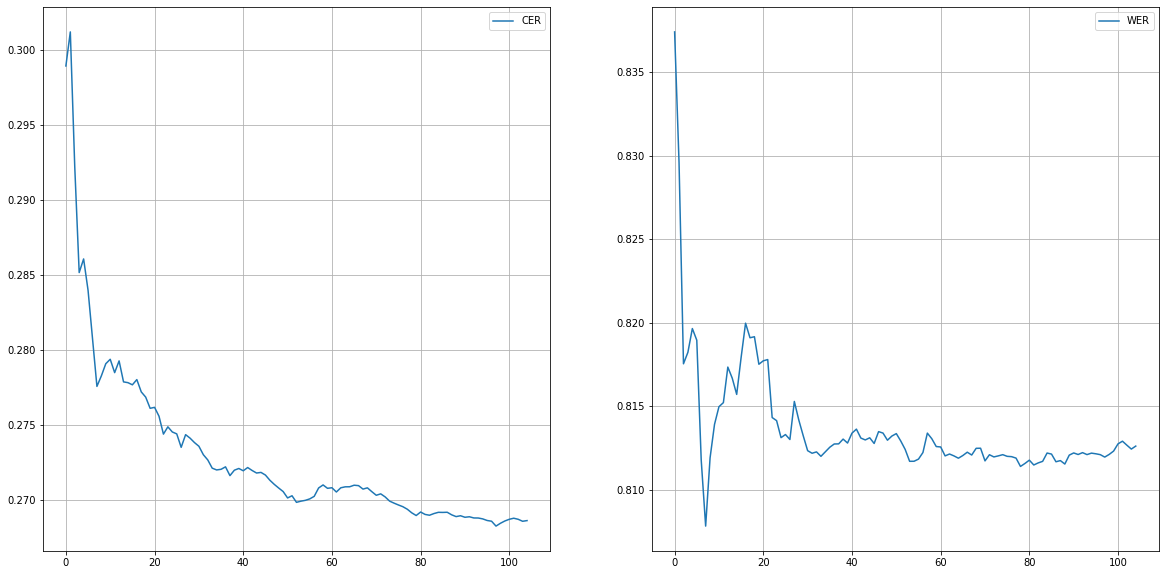

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()
axes[0].plot(history['cer'], label='CER')
axes[0].legend(); axes[0].grid()

axes[1].plot(history['wer'], label='WER')
axes[1].legend(); axes[1].grid()

In [ ]:
sum(history['cer'])/105

0.27290668446743843

In [ ]:
sum(history['wer'])/105

0.8136446539961318